In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV3'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.freehand_v3(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 128, 16)        64        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800 

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/146 [..............................] - ETA: 34:14 - loss: 2.9922

  2/146 [..............................] - ETA: 9s - loss: 2.8991   

  3/146 [..............................] - ETA: 9s - loss: 2.8259

  4/146 [..............................] - ETA: 9s - loss: 2.7671

  5/146 [>.............................] - ETA: 9s - loss: 2.7193

  6/146 [>.............................] - ETA: 9s - loss: 2.6792

  7/146 [>.............................] - ETA: 9s - loss: 2.6433

  8/146 [>.............................] - ETA: 9s - loss: 2.6125

  9/146 [>.............................] - ETA: 8s - loss: 2.5849

 10/146 [=>............................] - ETA: 8s - loss: 2.5599

 11/146 [=>............................] - ETA: 8s - loss: 2.5369

 12/146 [=>............................] - ETA: 8s - loss: 2.5163

 13/146 [=>............................] - ETA: 8s - loss: 2.4976

 14/146 [=>............................] - ETA: 8s - loss: 2.4800

 15/146 [==>...........................] - ETA: 8s - loss: 2.4636

 16/146 [==>...........................] - ETA: 8s - loss: 2.4481

 17/146 [==>...........................] - ETA: 8s - loss: 2.4333

 18/146 [==>...........................] - ETA: 8s - loss: 2.4192

 19/146 [==>...........................] - ETA: 8s - loss: 2.4060

 20/146 [===>..........................] - ETA: 8s - loss: 2.3935

 21/146 [===>..........................] - ETA: 8s - loss: 2.3816

 22/146 [===>..........................] - ETA: 8s - loss: 2.3703

 23/146 [===>..........................] - ETA: 8s - loss: 2.3596

 24/146 [===>..........................] - ETA: 7s - loss: 2.3493

 25/146 [====>.........................] - ETA: 7s - loss: 2.3393

 26/146 [====>.........................] - ETA: 7s - loss: 2.3298

 27/146 [====>.........................] - ETA: 7s - loss: 2.3206



 28/146 [====>.........................] - ETA: 7s - loss: 2.3116



 29/146 [====>.........................] - ETA: 7s - loss: 2.3030



 30/146 [=====>........................] - ETA: 7s - loss: 2.2948

 31/146 [=====>........................] - ETA: 7s - loss: 2.2868

 32/146 [=====>........................] - ETA: 7s - loss: 2.2792

 33/146 [=====>........................] - ETA: 7s - loss: 2.2718

 34/146 [=====>........................] - ETA: 7s - loss: 2.2646

 35/146 [======>.......................] - ETA: 7s - loss: 2.2577

 36/146 [======>.......................] - ETA: 7s - loss: 2.2510

 37/146 [======>.......................] - ETA: 7s - loss: 2.2445

 38/146 [======>.......................] - ETA: 7s - loss: 2.2382

 39/146 [=======>......................] - ETA: 6s - loss: 2.2322

 40/146 [=======>......................] - ETA: 6s - loss: 2.2263

 41/146 [=======>......................] - ETA: 6s - loss: 2.2206

 42/146 [=======>......................] - ETA: 6s - loss: 2.2150

 43/146 [=======>......................] - ETA: 6s - loss: 2.2096

 44/146 [========>.....................] - ETA: 6s - loss: 2.2043

 45/146 [========>.....................] - ETA: 6s - loss: 2.1991



 46/146 [========>.....................] - ETA: 6s - loss: 2.1941

 47/146 [========>.....................] - ETA: 6s - loss: 2.1892

 48/146 [========>.....................] - ETA: 6s - loss: 2.1844

 49/146 [=========>....................] - ETA: 6s - loss: 2.1797

 50/146 [=========>....................] - ETA: 6s - loss: 2.1751

 51/146 [=========>....................] - ETA: 6s - loss: 2.1707

 52/146 [=========>....................] - ETA: 6s - loss: 2.1663

 53/146 [=========>....................] - ETA: 6s - loss: 2.1621

 54/146 [==========>...................] - ETA: 6s - loss: 2.1579

 55/146 [==========>...................] - ETA: 5s - loss: 2.1539

 56/146 [==========>...................] - ETA: 5s - loss: 2.1499

 57/146 [==========>...................] - ETA: 5s - loss: 2.1461

 58/146 [==========>...................] - ETA: 5s - loss: 2.1423

 59/146 [===========>..................] - ETA: 5s - loss: 2.1385

 60/146 [===========>..................] - ETA: 5s - loss: 2.1349

 61/146 [===========>..................] - ETA: 5s - loss: 2.1313

 62/146 [===========>..................] - ETA: 5s - loss: 2.1278

 63/146 [===========>..................] - ETA: 5s - loss: 2.1244



 64/146 [============>.................] - ETA: 5s - loss: 2.1211

 65/146 [============>.................] - ETA: 5s - loss: 2.1178

 66/146 [============>.................] - ETA: 5s - loss: 2.1145

 67/146 [============>.................] - ETA: 5s - loss: 2.1113

 68/146 [============>.................] - ETA: 5s - loss: 2.1082

 69/146 [=============>................] - ETA: 5s - loss: 2.1051

 70/146 [=============>................] - ETA: 4s - loss: 2.1020

 71/146 [=============>................] - ETA: 4s - loss: 2.0990

 72/146 [=============>................] - ETA: 4s - loss: 2.0961

 73/146 [==============>...............] - ETA: 4s - loss: 2.0932

 74/146 [==============>...............] - ETA: 4s - loss: 2.0904

 75/146 [==============>...............] - ETA: 4s - loss: 2.0876

 76/146 [==============>...............] - ETA: 4s - loss: 2.0849

 77/146 [==============>...............] - ETA: 4s - loss: 2.0822

 78/146 [===============>..............] - ETA: 4s - loss: 2.0795

 79/146 [===============>..............] - ETA: 4s - loss: 2.0769

 80/146 [===============>..............] - ETA: 4s - loss: 2.0743

 81/146 [===============>..............] - ETA: 4s - loss: 2.0718

 82/146 [===============>..............] - ETA: 4s - loss: 2.0693

 83/146 [================>.............] - ETA: 4s - loss: 2.0669

 84/146 [================>.............] - ETA: 4s - loss: 2.0644



 85/146 [================>.............] - ETA: 3s - loss: 2.0620

 86/146 [================>.............] - ETA: 3s - loss: 2.0597

 87/146 [================>.............] - ETA: 3s - loss: 2.0574



 88/146 [=================>............] - ETA: 3s - loss: 2.0551



 89/146 [=================>............] - ETA: 3s - loss: 2.0528



 90/146 [=================>............] - ETA: 3s - loss: 2.0506

 91/146 [=================>............] - ETA: 3s - loss: 2.0484

 92/146 [=================>............] - ETA: 3s - loss: 2.0463



 93/146 [==================>...........] - ETA: 3s - loss: 2.0442

 94/146 [==================>...........] - ETA: 3s - loss: 2.0421

 95/146 [==================>...........] - ETA: 3s - loss: 2.0400

 96/146 [==================>...........] - ETA: 3s - loss: 2.0380

 97/146 [==================>...........] - ETA: 3s - loss: 2.0360

 98/146 [===================>..........] - ETA: 3s - loss: 2.0340

 99/146 [===================>..........] - ETA: 3s - loss: 2.0320

100/146 [===================>..........] - ETA: 3s - loss: 2.0301

101/146 [===================>..........] - ETA: 2s - loss: 2.0282

102/146 [===================>..........] - ETA: 2s - loss: 2.0263

103/146 [====================>.........] - ETA: 2s - loss: 2.0245

104/146 [====================>.........] - ETA: 2s - loss: 2.0226

105/146 [====================>.........] - ETA: 2s - loss: 2.0208

106/146 [====================>.........] - ETA: 2s - loss: 2.0190

107/146 [====================>.........] - ETA: 2s - loss: 2.0173

108/146 [=====================>........] - ETA: 2s - loss: 2.0155

109/146 [=====================>........] - ETA: 2s - loss: 2.0138

110/146 [=====================>........] - ETA: 2s - loss: 2.0121

111/146 [=====================>........] - ETA: 2s - loss: 2.0104

112/146 [======================>.......] - ETA: 2s - loss: 2.0088

113/146 [======================>.......] - ETA: 2s - loss: 2.0071

114/146 [======================>.......] - ETA: 2s - loss: 2.0055

115/146 [======================>.......] - ETA: 2s - loss: 2.0039

116/146 [======================>.......] - ETA: 1s - loss: 2.0023

117/146 [=======================>......] - ETA: 1s - loss: 2.0007

118/146 [=======================>......] - ETA: 1s - loss: 1.9992

119/146 [=======================>......] - ETA: 1s - loss: 1.9976

120/146 [=======================>......] - ETA: 1s - loss: 1.9961

121/146 [=======================>......] - ETA: 1s - loss: 1.9946

122/146 [========================>.....] - ETA: 1s - loss: 1.9931

123/146 [========================>.....] - ETA: 1s - loss: 1.9916

124/146 [========================>.....] - ETA: 1s - loss: 1.9901

125/146 [========================>.....] - ETA: 1s - loss: 1.9887

126/146 [========================>.....] - ETA: 1s - loss: 1.9872

127/146 [=========================>....] - ETA: 1s - loss: 1.9858

128/146 [=========================>....] - ETA: 1s - loss: 1.9844

129/146 [=========================>....] - ETA: 1s - loss: 1.9830

130/146 [=========================>....] - ETA: 1s - loss: 1.9816

131/146 [=========================>....] - ETA: 0s - loss: 1.9803

132/146 [==========================>...] - ETA: 0s - loss: 1.9789

133/146 [==========================>...] - ETA: 0s - loss: 1.9776

134/146 [==========================>...] - ETA: 0s - loss: 1.9762

135/146 [==========================>...] - ETA: 0s - loss: 1.9749

136/146 [==========================>...] - ETA: 0s - loss: 1.9736

137/146 [===========================>..] - ETA: 0s - loss: 1.9723

138/146 [===========================>..] - ETA: 0s - loss: 1.9711

139/146 [===========================>..] - ETA: 0s - loss: 1.9698

140/146 [===========================>..] - ETA: 0s - loss: 1.9686

141/146 [===========================>..] - ETA: 0s - loss: 1.9673

142/146 [============================>.] - ETA: 0s - loss: 1.9661

143/146 [============================>.] - ETA: 0s - loss: 1.9649

144/146 [============================>.] - ETA: 0s - loss: 1.9637

145/146 [============================>.] - ETA: 0s - loss: 1.9625

146/146 [==============================] - ETA: 0s - loss: 1.9613

146/146 [==============================] - 25s 72ms/step - loss: 1.9602 - val_loss: 5.9959


Epoch 2/100
  1/146 [..............................] - ETA: 9s - loss: 1.6757

  2/146 [..............................] - ETA: 9s - loss: 1.6961

  3/146 [..............................] - ETA: 9s - loss: 1.7026

  4/146 [..............................] - ETA: 9s - loss: 1.7025

  5/146 [>.............................] - ETA: 9s - loss: 1.7013

  6/146 [>.............................] - ETA: 9s - loss: 1.7011

  7/146 [>.............................]

 - ETA: 9s - loss: 1.7000

  8/146 [>.............................] - ETA: 9s - loss: 1.6993

  9/146 [>.............................] - ETA: 8s - loss: 1.6983

 10/146 [=>............................] - ETA: 8s - loss: 1.6974

 11/146 [=>............................]

 - ETA: 8s - loss: 1.6966

 12/146 [=>............................] - ETA: 8s - loss: 1.6959

 13/146 [=>............................] - ETA: 8s - loss: 1.6950

 14/146 [=>............................] - ETA: 8s - loss: 1.6940

 15/146 [==>...........................] - ETA: 8s - loss: 1.6928

 16/146 [==>...........................] - ETA: 8s - loss: 1.6919



 17/146 [==>...........................] - ETA: 8s - loss: 1.6910

 18/146 [==>...........................] - ETA: 8s - loss: 1.6901

 19/146 [==>...........................] - ETA: 8s - loss: 1.6894

 20/146 [===>..........................] - ETA: 8s - loss: 1.6886

 21/146 [===>..........................] - ETA: 8s - loss: 1.6879

 22/146 [===>..........................] - ETA: 8s - loss: 1.6873

 23/146 [===>..........................] - ETA: 8s - loss: 1.6867

 24/146 [===>..........................] - ETA: 8s - loss: 1.6861

 25/146 [====>.........................] - ETA: 7s - loss: 1.6856

 26/146 [====>.........................] - ETA: 7s - loss: 1.6851

 27/146 [====>.........................] - ETA: 7s - loss: 1.6846



 28/146 [====>.........................] - ETA: 7s - loss: 1.6841

 29/146 [====>.........................] - ETA: 7s - loss: 1.6837

 30/146 [=====>........................] - ETA: 7s - loss: 1.6834

 31/146 [=====>........................] - ETA: 7s - loss: 1.6830

 32/146 [=====>........................] - ETA: 7s - loss: 1.6827



 33/146 [=====>........................] - ETA: 7s - loss: 1.6823

 34/146 [=====>........................] - ETA: 7s - loss: 1.6819

 35/146 [======>.......................] - ETA: 7s - loss: 1.6814

 36/146 [======>.......................] - ETA: 7s - loss: 1.6810

 37/146 [======>.......................] - ETA: 7s - loss: 1.6806

 38/146 [======>.......................] - ETA: 7s - loss: 1.6802

 39/146 [=======>......................] - ETA: 7s - loss: 1.6798

 40/146 [=======>......................] - ETA: 6s - loss: 1.6794

 41/146 [=======>......................] - ETA: 6s - loss: 1.6790

 42/146 [=======>......................] - ETA: 6s - loss: 1.6787

 43/146 [=======>......................] - ETA: 6s - loss: 1.6783

 44/146 [========>.....................] - ETA: 6s - loss: 1.6780

 45/146 [========>.....................] - ETA: 6s - loss: 1.6777

 46/146 [========>.....................] - ETA: 6s - loss: 1.6774

 47/146 [========>.....................] - ETA: 6s - loss: 1.6770

 48/146 [========>.....................] - ETA: 6s - loss: 1.6767

 49/146 [=========>....................] - ETA: 6s - loss: 1.6764

 50/146 [=========>....................] - ETA: 6s - loss: 1.6761

 51/146 [=========>....................] - ETA: 6s - loss: 1.6758

 52/146 [=========>....................] - ETA: 6s - loss: 1.6755

 53/146 [=========>....................] - ETA: 6s - loss: 1.6752

 54/146 [==========>...................] - ETA: 6s - loss: 1.6749

 55/146 [==========>...................] - ETA: 5s - loss: 1.6746

 56/146 [==========>...................] - ETA: 5s - loss: 1.6744

 57/146 [==========>...................] - ETA: 5s - loss: 1.6741

 58/146 [==========>...................] - ETA: 5s - loss: 1.6738

 59/146 [===========>..................] - ETA: 5s - loss: 1.6736

 60/146 [===========>..................] - ETA: 5s - loss: 1.6733

 61/146 [===========>..................] - ETA: 5s - loss: 1.6731

 62/146 [===========>..................] - ETA: 5s - loss: 1.6728

 63/146 [===========>..................] - ETA: 5s - loss: 1.6726

 64/146 [============>.................] - ETA: 5s - loss: 1.6723

 65/146 [============>.................] - ETA: 5s - loss: 1.6721

 66/146 [============>.................] - ETA: 5s - loss: 1.6719

 67/146 [============>.................] - ETA: 5s - loss: 1.6716

 68/146 [============>.................] - ETA: 5s - loss: 1.6714

 69/146 [=============>................] - ETA: 5s - loss: 1.6712

 70/146 [=============>................] - ETA: 4s - loss: 1.6709

 71/146 [=============>................] - ETA: 4s - loss: 1.6707

 72/146 [=============>................] - ETA: 4s - loss: 1.6704

 73/146 [==============>...............] - ETA: 4s - loss: 1.6702

 74/146 [==============>...............] - ETA: 4s - loss: 1.6700

 75/146 [==============>...............] - ETA: 4s - loss: 1.6697

 76/146 [==============>...............] - ETA: 4s - loss: 1.6695

 77/146 [==============>...............] - ETA: 4s - loss: 1.6693

 78/146 [===============>..............] - ETA: 4s - loss: 1.6691

 79/146 [===============>..............] - ETA: 4s - loss: 1.6689

 80/146 [===============>..............] - ETA: 4s - loss: 1.6687

 81/146 [===============>..............] - ETA: 4s - loss: 1.6685

 82/146 [===============>..............] - ETA: 4s - loss: 1.6683

 83/146 [================>.............] - ETA: 4s - loss: 1.6680

 84/146 [================>.............] - ETA: 4s - loss: 1.6678

 85/146 [================>.............] - ETA: 4s - loss: 1.6676

 86/146 [================>.............] - ETA: 3s - loss: 1.6674

 87/146 [================>.............] - ETA: 3s - loss: 1.6672

 88/146 [=================>............] - ETA: 3s - loss: 1.6670

 89/146 [=================>............] - ETA: 3s - loss: 1.6667

 90/146 [=================>............] - ETA: 3s - loss: 1.6665

 91/146 [=================>............] - ETA: 3s - loss: 1.6663

 92/146 [=================>............] - ETA: 3s - loss: 1.6661

 93/146 [==================>...........]

 - ETA: 3s - loss: 1.6659

 94/146 [==================>...........] - ETA: 3s - loss: 1.6657

 95/146 [==================>...........] - ETA: 3s - loss: 1.6655

 96/146 [==================>...........] - ETA: 3s - loss: 1.6653

 97/146 [==================>...........] - ETA: 3s - loss: 1.6651

 98/146 [===================>..........] - ETA: 3s - loss: 1.6649

 99/146 [===================>..........] - ETA: 3s - loss: 1.6647

100/146 [===================>..........] - ETA: 3s - loss: 1.6645

101/146 [===================>..........] - ETA: 2s - loss: 1.6643

102/146 [===================>..........] - ETA: 2s - loss: 1.6641

103/146 [====================>.........] - ETA: 2s - loss: 1.6639

104/146 [====================>.........] - ETA: 2s - loss: 1.6637

105/146 [====================>.........] - ETA: 2s - loss: 1.6635

106/146 [====================>.........] - ETA: 2s - loss: 1.6633

107/146 [====================>.........] - ETA: 2s - loss: 1.6631

108/146 [=====================>........] - ETA: 2s - loss: 1.6629

109/146 [=====================>........] - ETA: 2s - loss: 1.6627

110/146 [=====================>........] - ETA: 2s - loss: 1.6625

111/146 [=====================>........] - ETA: 2s - loss: 1.6623

112/146 [======================>.......] - ETA: 2s - loss: 1.6621

113/146 [======================>.......] - ETA: 2s - loss: 1.6619

114/146 [======================>.......] - ETA: 2s - loss: 1.6617

115/146 [======================>.......] - ETA: 2s - loss: 1.6615

116/146 [======================>.......] - ETA: 1s - loss: 1.6613

117/146 [=======================>......] - ETA: 1s - loss: 1.6611

118/146 [=======================>......] - ETA: 1s - loss: 1.6610

119/146 [=======================>......] - ETA: 1s - loss: 1.6608

120/146 [=======================>......] - ETA: 1s - loss: 1.6606

121/146 [=======================>......] - ETA: 1s - loss: 1.6604

122/146 [========================>.....] - ETA: 1s - loss: 1.6602

123/146 [========================>.....] - ETA: 1s - loss: 1.6601

124/146 [========================>.....] - ETA: 1s - loss: 1.6599

125/146 [========================>.....] - ETA: 1s - loss: 1.6597

126/146 [========================>.....] - ETA: 1s - loss: 1.6595

127/146 [=========================>....] - ETA: 1s - loss: 1.6594

128/146 [=========================>....] - ETA: 1s - loss: 1.6592

129/146 [=========================>....] - ETA: 1s - loss: 1.6590

130/146 [=========================>....] - ETA: 1s - loss: 1.6588

131/146 [=========================>....] - ETA: 0s - loss: 1.6587

132/146 [==========================>...] - ETA: 0s - loss: 1.6585

133/146 [==========================>...] - ETA: 0s - loss: 1.6583

134/146 [==========================>...] - ETA: 0s - loss: 1.6582

135/146 [==========================>...] - ETA: 0s - loss: 1.6580

136/146 [==========================>...] - ETA: 0s - loss: 1.6578

137/146 [===========================>..] - ETA: 0s - loss: 1.6577

138/146 [===========================>..] - ETA: 0s - loss: 1.6575

139/146 [===========================>..] - ETA: 0s - loss: 1.6574

140/146 [===========================>..] - ETA: 0s - loss: 1.6572

141/146 [===========================>..] - ETA: 0s - loss: 1.6570

142/146 [============================>.] - ETA: 0s - loss: 1.6569

143/146 [============================>.]

 - ETA: 0s - loss: 1.6567

144/146 [============================>.] - ETA: 0s - loss: 1.6565

145/146 [============================>.] - ETA: 0s - loss: 1.6564

146/146 [==============================] - 10s 68ms/step - loss: 1.6561 - val_loss: 6.6677


Epoch 3/100
  1/146 [..............................] - ETA: 9s - loss: 1.5717

  2/146 [..............................] - ETA: 9s - loss: 1.5865

  3/146 [..............................] - ETA: 9s - loss: 1.5968

  4/146 [..............................] - ETA: 9s - loss: 1.6078

  5/146 [>.............................] - ETA: 9s - loss: 1.6146

  6/146 [>.............................] - ETA: 9s - loss: 1.6183

  7/146 [>.............................] - ETA: 9s - loss: 1.6206

  8/146 [>.............................] - ETA: 9s - loss: 1.6220

  9/146 [>.............................] - ETA: 9s - loss: 1.6235

 10/146 [=>............................] - ETA: 8s - loss: 1.6249

 11/146 [=>............................] - ETA: 8s - loss: 1.6261

 12/146 [=>............................] - ETA: 8s - loss: 1.6269

 13/146 [=>............................] - ETA: 8s - loss: 1.6273

 14/146 [=>............................] - ETA: 8s - loss: 1.6275

 15/146 [==>...........................] - ETA: 8s - loss: 1.6278

 16/146 [==>...........................] - ETA: 8s - loss: 1.6280

 17/146 [==>...........................] - ETA: 8s - loss: 1.6282

 18/146 [==>...........................] - ETA: 8s - loss: 1.6284

 19/146 [==>...........................] - ETA: 8s - loss: 1.6284

 20/146 [===>..........................] - ETA: 8s - loss: 1.6284

 21/146 [===>..........................] - ETA: 8s - loss: 1.6283

 22/146 [===>..........................] - ETA: 8s - loss: 1.6281

 23/146 [===>..........................] - ETA: 8s - loss: 1.6278

 24/146 [===>..........................] - ETA: 8s - loss: 1.6274

 25/146 [====>.........................] - ETA: 7s - loss: 1.6270

 26/146 [====>.........................] - ETA: 7s - loss: 1.6266

 27/146 [====>.........................] - ETA: 7s - loss: 1.6261

 28/146 [====>.........................] - ETA: 7s - loss: 1.6257

 29/146 [====>.........................] - ETA: 7s - loss: 1.6253

 30/146 [=====>........................] - ETA: 7s - loss: 1.6248

 31/146 [=====>........................] - ETA: 7s - loss: 1.6243



 32/146 [=====>........................] - ETA: 7s - loss: 1.6239

 33/146 [=====>........................] - ETA: 7s - loss: 1.6234

 34/146 [=====>........................] - ETA: 7s - loss: 1.6229

 35/146 [======>.......................] - ETA: 7s - loss: 1.6225

 36/146 [======>.......................] - ETA: 7s - loss: 1.6220

 37/146 [======>.......................] - ETA: 7s - loss: 1.6215

 38/146 [======>.......................] - ETA: 7s - loss: 1.6211

 39/146 [=======>......................] - ETA: 7s - loss: 1.6206

 40/146 [=======>......................] - ETA: 6s - loss: 1.6201

 41/146 [=======>......................] - ETA: 6s - loss: 1.6197

 42/146 [=======>......................] - ETA: 6s - loss: 1.6192



 43/146 [=======>......................] - ETA: 6s - loss: 1.6188

 44/146 [========>.....................] - ETA: 6s - loss: 1.6184

 45/146 [========>.....................] - ETA: 6s - loss: 1.6180

 46/146 [========>.....................] - ETA: 6s - loss: 1.6176

 47/146 [========>.....................] - ETA: 6s - loss: 1.6172

 48/146 [========>.....................] - ETA: 6s - loss: 1.6168

 49/146 [=========>....................] - ETA: 6s - loss: 1.6164

 50/146 [=========>....................] - ETA: 6s - loss: 1.6160

 51/146 [=========>....................] - ETA: 6s - loss: 1.6156

 52/146 [=========>....................] - ETA: 6s - loss: 1.6153

 53/146 [=========>....................] - ETA: 6s - loss: 1.6149

 54/146 [==========>...................] - ETA: 6s - loss: 1.6146

 55/146 [==========>...................] - ETA: 5s - loss: 1.6142

 56/146 [==========>...................] - ETA: 5s - loss: 1.6139

 57/146 [==========>...................] - ETA: 5s - loss: 1.6135

 58/146 [==========>...................] - ETA: 5s - loss: 1.6132

 59/146 [===========>..................] - ETA: 5s - loss: 1.6128

 60/146 [===========>..................] - ETA: 5s - loss: 1.6125

 61/146 [===========>..................] - ETA: 5s - loss: 1.6122

 62/146 [===========>..................] - ETA: 5s - loss: 1.6119

 63/146 [===========>..................] - ETA: 5s - loss: 1.6116

 64/146 [============>.................] - ETA: 5s - loss: 1.6113

 65/146 [============>.................] - ETA: 5s - loss: 1.6110

 66/146 [============>.................] - ETA: 5s - loss: 1.6107

 67/146 [============>.................] - ETA: 5s - loss: 1.6104

 68/146 [============>.................] - ETA: 5s - loss: 1.6101



 69/146 [=============>................] - ETA: 5s - loss: 1.6099



 70/146 [=============>................] - ETA: 4s - loss: 1.6096

 71/146 [=============>................] - ETA: 4s - loss: 1.6093

 72/146 [=============>................] - ETA: 4s - loss: 1.6091

 73/146 [==============>...............] - ETA: 4s - loss: 1.6088

 74/146 [==============>...............] - ETA: 4s - loss: 1.6085

 75/146 [==============>...............] - ETA: 4s - loss: 1.6083

 76/146 [==============>...............] - ETA: 4s - loss: 1.6080

 77/146 [==============>...............] - ETA: 4s - loss: 1.6078

 78/146 [===============>..............] - ETA: 4s - loss: 1.6075

 79/146 [===============>..............] - ETA: 4s - loss: 1.6073

 80/146 [===============>..............] - ETA: 4s - loss: 1.6070

 81/146 [===============>..............] - ETA: 4s - loss: 1.6068

 82/146 [===============>..............] - ETA: 4s - loss: 1.6065

 83/146 [================>.............] - ETA: 4s - loss: 1.6063

 84/146 [================>.............] - ETA: 4s - loss: 1.6060

 85/146 [================>.............] - ETA: 4s - loss: 1.6058

 86/146 [================>.............] - ETA: 3s - loss: 1.6056

 87/146 [================>.............] - ETA: 3s - loss: 1.6053

 88/146 [=================>............] - ETA: 3s - loss: 1.6051

 89/146 [=================>............] - ETA: 3s - loss: 1.6048

 90/146 [=================>............] - ETA: 3s - loss: 1.6046

 91/146 [=================>............] - ETA: 3s - loss: 1.6044

 92/146 [=================>............] - ETA: 3s - loss: 1.6041

 93/146 [==================>...........] - ETA: 3s - loss: 1.6039

 94/146 [==================>...........] - ETA: 3s - loss: 1.6037

 95/146 [==================>...........] - ETA: 3s - loss: 1.6034

 96/146 [==================>...........] - ETA: 3s - loss: 1.6032

 97/146 [==================>...........] - ETA: 3s - loss: 1.6030

 98/146 [===================>..........] - ETA: 3s - loss: 1.6028

 99/146 [===================>..........] - ETA: 3s - loss: 1.6026

100/146 [===================>..........] - ETA: 3s - loss: 1.6023

101/146 [===================>..........] - ETA: 2s - loss: 1.6021

102/146 [===================>..........] - ETA: 2s - loss: 1.6019

103/146 [====================>.........] - ETA: 2s - loss: 1.6017

104/146 [====================>.........] - ETA: 2s - loss: 1.6015

105/146 [====================>.........] - ETA: 2s - loss: 1.6013

106/146 [====================>.........] - ETA: 2s - loss: 1.6011

107/146 [====================>.........] - ETA: 2s - loss: 1.6009

108/146 [=====================>........] - ETA: 2s - loss: 1.6007

109/146 [=====================>........] - ETA: 2s - loss: 1.6005

110/146 [=====================>........] - ETA: 2s - loss: 1.6003

111/146 [=====================>........] - ETA: 2s - loss: 1.6001

112/146 [======================>.......] - ETA: 2s - loss: 1.5998

113/146 [======================>.......] - ETA: 2s - loss: 1.5996



114/146 [======================>.......] - ETA: 2s - loss: 1.5995



115/146 [======================>.......] - ETA: 2s - loss: 1.5993

116/146 [======================>.......] - ETA: 1s - loss: 1.5991

117/146 [=======================>......] - ETA: 1s - loss: 1.5989

118/146 [=======================>......] - ETA: 1s - loss: 1.5987

119/146 [=======================>......] - ETA: 1s - loss: 1.5985

120/146 [=======================>......] - ETA: 1s - loss: 1.5984

121/146 [=======================>......] - ETA: 1s - loss: 1.5982

122/146 [========================>.....] - ETA: 1s - loss: 1.5980

123/146 [========================>.....] - ETA: 1s - loss: 1.5978

124/146 [========================>.....] - ETA: 1s - loss: 1.5977

125/146 [========================>.....] - ETA: 1s - loss: 1.5975

126/146 [========================>.....] - ETA: 1s - loss: 1.5973

127/146 [=========================>....] - ETA: 1s - loss: 1.5971

128/146 [=========================>....] - ETA: 1s - loss: 1.5969

129/146 [=========================>....] - ETA: 1s - loss: 1.5968

130/146 [=========================>....] - ETA: 1s - loss: 1.5966

131/146 [=========================>....] - ETA: 0s - loss: 1.5964

132/146 [==========================>...] - ETA: 0s - loss: 1.5963

133/146 [==========================>...] - ETA: 0s - loss: 1.5961

134/146 [==========================>...] - ETA: 0s - loss: 1.5959

135/146 [==========================>...] - ETA: 0s - loss: 1.5958

136/146 [==========================>...] - ETA: 0s - loss: 1.5956

137/146 [===========================>..] - ETA: 0s - loss: 1.5954



138/146 [===========================>..] - ETA: 0s - loss: 1.5953

139/146 [===========================>..] - ETA: 0s - loss: 1.5951

140/146 [===========================>..] - ETA: 0s - loss: 1.5949

141/146 [===========================>..] - ETA: 0s - loss: 1.5948

142/146 [============================>.] - ETA: 0s - loss: 1.5946

143/146 [============================>.] - ETA: 0s - loss: 1.5944

144/146 [============================>.] - ETA: 0s - loss: 1.5943

145/146 [============================>.] - ETA: 0s - loss: 1.5941

146/146 [==============================] - 10s 68ms/step - loss: 1.5938 - val_loss: 4.8766


Epoch 4/100
  1/146 [..............................] - ETA: 9s - loss: 1.4981

  2/146 [..............................] - ETA: 9s - loss: 1.5092

  3/146 [..............................] - ETA: 9s - loss: 1.5192

  4/146 [..............................] - ETA: 9s - loss: 1.5235

  5/146 [>.............................] - ETA: 9s - loss: 1.5265

  6/146 [>.............................] - ETA: 9s - loss: 1.5295

  7/146 [>.............................] - ETA: 9s - loss: 1.5316

  8/146 [>.............................] - ETA: 9s - loss: 1.5339



  9/146 [>.............................] - ETA: 9s - loss: 1.5359



 10/146 [=>............................] - ETA: 8s - loss: 1.5372



 11/146 [=>............................] - ETA: 8s - loss: 1.5386

 12/146 [=>............................] - ETA: 8s - loss: 1.5398

 13/146 [=>............................] - ETA: 8s - loss: 1.5406

 14/146 [=>............................] - ETA: 8s - loss: 1.5414

 15/146 [==>...........................] - ETA: 8s - loss: 1.5423

 16/146 [==>...........................] - ETA: 8s - loss: 1.5430

 17/146 [==>...........................] - ETA: 8s - loss: 1.5437

 18/146 [==>...........................] - ETA: 8s - loss: 1.5443

 19/146 [==>...........................] - ETA: 8s - loss: 1.5447

 20/146 [===>..........................] - ETA: 8s - loss: 1.5452

 21/146 [===>..........................] - ETA: 8s - loss: 1.5456

 22/146 [===>..........................] - ETA: 8s - loss: 1.5460

 23/146 [===>..........................] - ETA: 8s - loss: 1.5462

 24/146 [===>..........................] - ETA: 8s - loss: 1.5464

 25/146 [====>.........................] - ETA: 7s - loss: 1.5465

 26/146 [====>.........................] - ETA: 7s - loss: 1.5467

 27/146 [====>.........................] - ETA: 7s - loss: 1.5469

 28/146 [====>.........................] - ETA: 7s - loss: 1.5470

 29/146 [====>.........................] - ETA: 7s - loss: 1.5471

 30/146 [=====>........................] - ETA: 7s - loss: 1.5473

 31/146 [=====>........................] - ETA: 7s - loss: 1.5474

 32/146 [=====>........................] - ETA: 7s - loss: 1.5475

 33/146 [=====>........................] - ETA: 7s - loss: 1.5477

 34/146 [=====>........................] - ETA: 7s - loss: 1.5477

 35/146 [======>.......................] - ETA: 7s - loss: 1.5478

 36/146 [======>.......................] - ETA: 7s - loss: 1.5478

 37/146 [======>.......................] - ETA: 7s - loss: 1.5479

 38/146 [======>.......................] - ETA: 7s - loss: 1.5480

 39/146 [=======>......................] - ETA: 7s - loss: 1.5481

 40/146 [=======>......................] - ETA: 6s - loss: 1.5481

 41/146 [=======>......................] - ETA: 6s - loss: 1.5482

 42/146 [=======>......................] - ETA: 6s - loss: 1.5482

 43/146 [=======>......................] - ETA: 6s - loss: 1.5483

 44/146 [========>.....................] - ETA: 6s - loss: 1.5483

 45/146 [========>.....................] - ETA: 6s - loss: 1.5483

 46/146 [========>.....................] - ETA: 6s - loss: 1.5484

 47/146 [========>.....................] - ETA: 6s - loss: 1.5484

 48/146 [========>.....................] - ETA: 6s - loss: 1.5484

 49/146 [=========>....................] - ETA: 6s - loss: 1.5483

 50/146 [=========>....................] - ETA: 6s - loss: 1.5483

 51/146 [=========>....................] - ETA: 6s - loss: 1.5483

 52/146 [=========>....................] - ETA: 6s - loss: 1.5483

 53/146 [=========>....................] - ETA: 6s - loss: 1.5483

 54/146 [==========>...................] - ETA: 6s - loss: 1.5483

 55/146 [==========>...................] - ETA: 5s - loss: 1.5483

 56/146 [==========>...................] - ETA: 5s - loss: 1.5482

 57/146 [==========>...................] - ETA: 5s - loss: 1.5482

 58/146 [==========>...................] - ETA: 5s - loss: 1.5482

 59/146 [===========>..................] - ETA: 5s - loss: 1.5481

 60/146 [===========>..................] - ETA: 5s - loss: 1.5481

 61/146 [===========>..................] - ETA: 5s - loss: 1.5481

 62/146 [===========>..................] - ETA: 5s - loss: 1.5480

 63/146 [===========>..................] - ETA: 5s - loss: 1.5480

 64/146 [============>.................] - ETA: 5s - loss: 1.5479

 65/146 [============>.................] - ETA: 5s - loss: 1.5479

 66/146 [============>.................] - ETA: 5s - loss: 1.5479

 67/146 [============>.................] - ETA: 5s - loss: 1.5478

 68/146 [============>.................] - ETA: 5s - loss: 1.5478

 69/146 [=============>................] - ETA: 5s - loss: 1.5477

 70/146 [=============>................] - ETA: 5s - loss: 1.5477

 71/146 [=============>................] - ETA: 4s - loss: 1.5476

 72/146 [=============>................] - ETA: 4s - loss: 1.5476

 73/146 [==============>...............] - ETA: 4s - loss: 1.5475

 74/146 [==============>...............] - ETA: 4s - loss: 1.5475

 75/146 [==============>...............] - ETA: 4s - loss: 1.5474

 76/146 [==============>...............] - ETA: 4s - loss: 1.5474

 77/146 [==============>...............] - ETA: 4s - loss: 1.5473

 78/146 [===============>..............] - ETA: 4s - loss: 1.5473

 79/146 [===============>..............] - ETA: 4s - loss: 1.5472

 80/146 [===============>..............] - ETA: 4s - loss: 1.5471

 81/146 [===============>..............] - ETA: 4s - loss: 1.5471

 82/146 [===============>..............] - ETA: 4s - loss: 1.5470

 83/146 [================>.............] - ETA: 4s - loss: 1.5469

 84/146 [================>.............] - ETA: 4s - loss: 1.5469

 85/146 [================>.............] - ETA: 4s - loss: 1.5468

 86/146 [================>.............] - ETA: 3s - loss: 1.5467

 87/146 [================>.............] - ETA: 3s - loss: 1.5466

 88/146 [=================>............] - ETA: 3s - loss: 1.5466

 89/146 [=================>............] - ETA: 3s - loss: 1.5465

 90/146 [=================>............] - ETA: 3s - loss: 1.5464

 91/146 [=================>............] - ETA: 3s - loss: 1.5463

 92/146 [=================>............] - ETA: 3s - loss: 1.5463

 93/146 [==================>...........] - ETA: 3s - loss: 1.5462

 94/146 [==================>...........] - ETA: 3s - loss: 1.5461

 95/146 [==================>...........] - ETA: 3s - loss: 1.5461

 96/146 [==================>...........] - ETA: 3s - loss: 1.5460

 97/146 [==================>...........] - ETA: 3s - loss: 1.5459

 98/146 [===================>..........] - ETA: 3s - loss: 1.5459



 99/146 [===================>..........] - ETA: 3s - loss: 1.5458

100/146 [===================>..........] - ETA: 3s - loss: 1.5457

101/146 [===================>..........] - ETA: 2s - loss: 1.5457

102/146 [===================>..........] - ETA: 2s - loss: 1.5456

103/146 [====================>.........] - ETA: 2s - loss: 1.5455

104/146 [====================>.........] - ETA: 2s - loss: 1.5455

105/146 [====================>.........] - ETA: 2s - loss: 1.5454

106/146 [====================>.........] - ETA: 2s - loss: 1.5453

107/146 [====================>.........]

 - ETA: 2s - loss: 1.5453

108/146 [=====================>........] - ETA: 2s - loss: 1.5452

109/146 [=====================>........] - ETA: 2s - loss: 1.5451

110/146 [=====================>........] - ETA: 2s - loss: 1.5451

111/146 [=====================>........] - ETA: 2s - loss: 1.5450

112/146 [======================>.......] - ETA: 2s - loss: 1.5449

113/146 [======================>.......] - ETA: 2s - loss: 1.5448



114/146 [======================>.......] - ETA: 2s - loss: 1.5448

115/146 [======================>.......] - ETA: 2s - loss: 1.5447



116/146 [======================>.......] - ETA: 1s - loss: 1.5446



117/146 [=======================>......] - ETA: 1s - loss: 1.5445



118/146 [=======================>......] - ETA: 1s - loss: 1.5444



119/146 [=======================>......] - ETA: 1s - loss: 1.5444

120/146 [=======================>......] - ETA: 1s - loss: 1.5443

121/146 [=======================>......] - ETA: 1s - loss: 1.5442

122/146 [========================>.....] - ETA: 1s - loss: 1.5441

123/146 [========================>.....] - ETA: 1s - loss: 1.5440

124/146 [========================>.....] - ETA: 1s - loss: 1.5440

125/146 [========================>.....] - ETA: 1s - loss: 1.5439

126/146 [========================>.....] - ETA: 1s - loss: 1.5438

127/146 [=========================>....] - ETA: 1s - loss: 1.5437

128/146 [=========================>....] - ETA: 1s - loss: 1.5436

129/146 [=========================>....] - ETA: 1s - loss: 1.5436

130/146 [=========================>....] - ETA: 1s - loss: 1.5435



131/146 [=========================>....] - ETA: 0s - loss: 1.5434

132/146 [==========================>...] - ETA: 0s - loss: 1.5433

133/146 [==========================>...] - ETA: 0s - loss: 1.5433

134/146 [==========================>...] - ETA: 0s - loss: 1.5432

135/146 [==========================>...] - ETA: 0s - loss: 1.5431

136/146 [==========================>...] - ETA: 0s - loss: 1.5431

137/146 [===========================>..] - ETA: 0s - loss: 1.5430

138/146 [===========================>..] - ETA: 0s - loss: 1.5429

139/146 [===========================>..] - ETA: 0s - loss: 1.5428

140/146 [===========================>..] - ETA: 0s - loss: 1.5428

141/146 [===========================>..] - ETA: 0s - loss: 1.5427

142/146 [============================>.] - ETA: 0s - loss: 1.5426

143/146 [============================>.] - ETA: 0s - loss: 1.5426

144/146 [============================>.] - ETA: 0s - loss: 1.5425

145/146 [============================>.] - ETA: 0s - loss: 1.5424

146/146 [==============================] - 10s 68ms/step - loss: 1.5423 - val_loss: 3.2409


Epoch 5/100


  1/146 [..............................] - ETA: 9s - loss: 1.5296

  2/146 [..............................] - ETA: 9s - loss: 1.5436

  3/146 [..............................] - ETA: 9s - loss: 1.5467

  4/146 [..............................] - ETA: 9s - loss: 1.5474

  5/146 [>.............................] - ETA: 9s - loss: 1.5435

  6/146 [>.............................] - ETA: 9s - loss: 1.5404

  7/146 [>.............................] - ETA: 9s - loss: 1.5383

  8/146 [>.............................] - ETA: 9s - loss: 1.5373

  9/146 [>.............................] - ETA: 8s - loss: 1.5366

 10/146 [=>............................] - ETA: 8s - loss: 1.5361

 11/146 [=>............................] - ETA: 8s - loss: 1.5356

 12/146 [=>............................] - ETA: 8s - loss: 1.5352

 13/146 [=>............................] - ETA: 8s - loss: 1.5348

 14/146 [=>............................] - ETA: 8s - loss: 1.5343

 15/146 [==>...........................] - ETA: 8s - loss: 1.5337

 16/146 [==>...........................] - ETA: 8s - loss: 1.5330

 17/146 [==>...........................] - ETA: 8s - loss: 1.5326

 18/146 [==>...........................] - ETA: 8s - loss: 1.5322

 19/146 [==>...........................] - ETA: 8s - loss: 1.5317

 20/146 [===>..........................] - ETA: 8s - loss: 1.5312

 21/146 [===>..........................] - ETA: 8s - loss: 1.5306

 22/146 [===>..........................] - ETA: 8s - loss: 1.5301

 23/146 [===>..........................] - ETA: 8s - loss: 1.5296

 24/146 [===>..........................] - ETA: 8s - loss: 1.5292

 25/146 [====>.........................]

 - ETA: 7s - loss: 1.5287

 26/146 [====>.........................] - ETA: 7s - loss: 1.5283

 27/146 [====>.........................] - ETA: 7s - loss: 1.5279

 28/146 [====>.........................] - ETA: 7s - loss: 1.5275

 29/146 [====>.........................] - ETA: 7s - loss: 1.5271

 30/146 [=====>........................] - ETA: 7s - loss: 1.5267

 31/146 [=====>........................] - ETA: 7s - loss: 1.5264

 32/146 [=====>........................] - ETA: 7s - loss: 1.5261

 33/146 [=====>........................] - ETA: 7s - loss: 1.5258

 34/146 [=====>........................] - ETA: 7s - loss: 1.5256

 35/146 [======>.......................] - ETA: 7s - loss: 1.5253

 36/146 [======>.......................] - ETA: 7s - loss: 1.5249

 37/146 [======>.......................] - ETA: 7s - loss: 1.5246

 38/146 [======>.......................] - ETA: 7s - loss: 1.5243

 39/146 [=======>......................] - ETA: 7s - loss: 1.5239

 40/146 [=======>......................] - ETA: 6s - loss: 1.5236

 41/146 [=======>......................] - ETA: 6s - loss: 1.5233

 42/146 [=======>......................] - ETA: 6s - loss: 1.5229

 43/146 [=======>......................] - ETA: 6s - loss: 1.5227

 44/146 [========>.....................] - ETA: 6s - loss: 1.5224

 45/146 [========>.....................] - ETA: 6s - loss: 1.5221

 46/146 [========>.....................] - ETA: 6s - loss: 1.5219

 47/146 [========>.....................] - ETA: 6s - loss: 1.5216

 48/146 [========>.....................] - ETA: 6s - loss: 1.5214



 49/146 [=========>....................] - ETA: 6s - loss: 1.5212



 50/146 [=========>....................] - ETA: 6s - loss: 1.5210

 51/146 [=========>....................] - ETA: 6s - loss: 1.5208

 52/146 [=========>....................] - ETA: 6s - loss: 1.5206

 53/146 [=========>....................] - ETA: 6s - loss: 1.5204

 54/146 [==========>...................] - ETA: 6s - loss: 1.5202

 55/146 [==========>...................] - ETA: 5s - loss: 1.5200

 56/146 [==========>...................] - ETA: 5s - loss: 1.5199

 57/146 [==========>...................] - ETA: 5s - loss: 1.5198

 58/146 [==========>...................] - ETA: 5s - loss: 1.5196



 59/146 [===========>..................] - ETA: 5s - loss: 1.5195

 60/146 [===========>..................] - ETA: 5s - loss: 1.5193

 61/146 [===========>..................] - ETA: 5s - loss: 1.5192

 62/146 [===========>..................] - ETA: 5s - loss: 1.5191

 63/146 [===========>..................] - ETA: 5s - loss: 1.5190

 64/146 [============>.................] - ETA: 5s - loss: 1.5188

 65/146 [============>.................] - ETA: 5s - loss: 1.5187

 66/146 [============>.................] - ETA: 5s - loss: 1.5186

 67/146 [============>.................] - ETA: 5s - loss: 1.5185

 68/146 [============>.................] - ETA: 5s - loss: 1.5184

 69/146 [=============>................] - ETA: 5s - loss: 1.5183

 70/146 [=============>................] - ETA: 5s - loss: 1.5182

 71/146 [=============>................] - ETA: 4s - loss: 1.5181

 72/146 [=============>................] - ETA: 4s - loss: 1.5180

 73/146 [==============>...............] - ETA: 4s - loss: 1.5179

 74/146 [==============>...............] - ETA: 4s - loss: 1.5178

 75/146 [==============>...............] - ETA: 4s - loss: 1.5177

 76/146 [==============>...............] - ETA: 4s - loss: 1.5176

 77/146 [==============>...............] - ETA: 4s - loss: 1.5175

 78/146 [===============>..............] - ETA: 4s - loss: 1.5174

 79/146 [===============>..............] - ETA: 4s - loss: 1.5173

 80/146 [===============>..............] - ETA: 4s - loss: 1.5172

 81/146 [===============>..............] - ETA: 4s - loss: 1.5171

 82/146 [===============>..............] - ETA: 4s - loss: 1.5170

 83/146 [================>.............] - ETA: 4s - loss: 1.5170

 84/146 [================>.............] - ETA: 4s - loss: 1.5169

 85/146 [================>.............] - ETA: 4s - loss: 1.5168

 86/146 [================>.............] - ETA: 3s - loss: 1.5167

 87/146 [================>.............] - ETA: 3s - loss: 1.5166

 88/146 [=================>............] - ETA: 3s - loss: 1.5165

 89/146 [=================>............] - ETA: 3s - loss: 1.5164

 90/146 [=================>............] - ETA: 3s - loss: 1.5163

 91/146 [=================>............] - ETA: 3s - loss: 1.5162

 92/146 [=================>............] - ETA: 3s - loss: 1.5161

 93/146 [==================>...........] - ETA: 3s - loss: 1.5160

 94/146 [==================>...........] - ETA: 3s - loss: 1.5159

 95/146 [==================>...........] - ETA: 3s - loss: 1.5158

 96/146 [==================>...........] - ETA: 3s - loss: 1.5157

 97/146 [==================>...........] - ETA: 3s - loss: 1.5156

 98/146 [===================>..........] - ETA: 3s - loss: 1.5155

 99/146 [===================>..........] - ETA: 3s - loss: 1.5155

100/146 [===================>..........] - ETA: 3s - loss: 1.5154

101/146 [===================>..........] - ETA: 2s - loss: 1.5153

102/146 [===================>..........] - ETA: 2s - loss: 1.5152

103/146 [====================>.........] - ETA: 2s - loss: 1.5151

104/146 [====================>.........] - ETA: 2s - loss: 1.5150

105/146 [====================>.........] - ETA: 2s - loss: 1.5149

106/146 [====================>.........] - ETA: 2s - loss: 1.5148

107/146 [====================>.........] - ETA: 2s - loss: 1.5147

108/146 [=====================>........] - ETA: 2s - loss: 1.5146

109/146 [=====================>........] - ETA: 2s - loss: 1.5146

110/146 [=====================>........] - ETA: 2s - loss: 1.5145

111/146 [=====================>........] - ETA: 2s - loss: 1.5144

112/146 [======================>.......] - ETA: 2s - loss: 1.5143

113/146 [======================>.......] - ETA: 2s - loss: 1.5142

114/146 [======================>.......] - ETA: 2s - loss: 1.5141

115/146 [======================>.......] - ETA: 2s - loss: 1.5141

116/146 [======================>.......] - ETA: 1s - loss: 1.5140

117/146 [=======================>......] - ETA: 1s - loss: 1.5139

118/146 [=======================>......] - ETA: 1s - loss: 1.5138

119/146 [=======================>......] - ETA: 1s - loss: 1.5138

120/146 [=======================>......] - ETA: 1s - loss: 1.5137

121/146 [=======================>......] - ETA: 1s - loss: 1.5136

122/146 [========================>.....] - ETA: 1s - loss: 1.5135

123/146 [========================>.....] - ETA: 1s - loss: 1.5135

124/146 [========================>.....] - ETA: 1s - loss: 1.5134

125/146 [========================>.....] - ETA: 1s - loss: 1.5133

126/146 [========================>.....] - ETA: 1s - loss: 1.5133

127/146 [=========================>....]

 - ETA: 1s - loss: 1.5132

128/146 [=========================>....] - ETA: 1s - loss: 1.5131

129/146 [=========================>....] - ETA: 1s - loss: 1.5131

130/146 [=========================>....] - ETA: 1s - loss: 1.5130

131/146 [=========================>....] - ETA: 0s - loss: 1.5129

132/146 [==========================>...] - ETA: 0s - loss: 1.5129

133/146 [==========================>...] - ETA: 0s - loss: 1.5128

134/146 [==========================>...] - ETA: 0s - loss: 1.5127

135/146 [==========================>...] - ETA: 0s - loss: 1.5127

136/146 [==========================>...] - ETA: 0s - loss: 1.5126

137/146 [===========================>..] - ETA: 0s - loss: 1.5125

138/146 [===========================>..] - ETA: 0s - loss: 1.5124

139/146 [===========================>..] - ETA: 0s - loss: 1.5124

140/146 [===========================>..] - ETA: 0s - loss: 1.5123

141/146 [===========================>..] - ETA: 0s - loss: 1.5122

142/146 [============================>.] - ETA: 0s - loss: 1.5121

143/146 [============================>.] - ETA: 0s - loss: 1.5121

144/146 [============================>.] - ETA: 0s - loss: 1.5120

145/146 [============================>.] - ETA: 0s - loss: 1.5119

146/146 [==============================] - 10s 68ms/step - loss: 1.5118 - val_loss: 1.7737


Epoch 6/100
  1/146 [..............................] - ETA: 9s - loss: 1.5295

  2/146 [..............................] - ETA: 9s - loss: 1.5351



  3/146 [..............................] - ETA: 9s - loss: 1.5398

  4/146 [..............................] - ETA: 9s - loss: 1.5435

  5/146 [>.............................] - ETA: 9s - loss: 1.5456

  6/146 [>.............................] - ETA: 9s - loss: 1.5481

  7/146 [>.............................] - ETA: 9s - loss: 1.5501

  8/146 [>.............................] - ETA: 9s - loss: 1.5519

  9/146 [>.............................] - ETA: 9s - loss: 1.5527

 10/146 [=>............................] - ETA: 8s - loss: 1.5529

 11/146 [=>............................] - ETA: 8s - loss: 1.5522

 12/146 [=>............................] - ETA: 8s - loss: 1.5514

 13/146 [=>............................] - ETA: 8s - loss: 1.5508

 14/146 [=>............................] - ETA: 8s - loss: 1.5500

 15/146 [==>...........................] - ETA: 8s - loss: 1.5490

 16/146 [==>...........................] - ETA: 8s - loss: 1.5482

 17/146 [==>...........................] - ETA: 8s - loss: 1.5472

 18/146 [==>...........................] - ETA: 8s - loss: 1.5462

 19/146 [==>...........................] - ETA: 8s - loss: 1.5452

 20/146 [===>..........................] - ETA: 8s - loss: 1.5442

 21/146 [===>..........................] - ETA: 8s - loss: 1.5433

 22/146 [===>..........................] - ETA: 8s - loss: 1.5424

 23/146 [===>..........................] - ETA: 8s - loss: 1.5416

 24/146 [===>..........................] - ETA: 8s - loss: 1.5408

 25/146 [====>.........................] - ETA: 7s - loss: 1.5401

 26/146 [====>.........................] - ETA: 7s - loss: 1.5394

 27/146 [====>.........................] - ETA: 7s - loss: 1.5387

 28/146 [====>.........................] - ETA: 7s - loss: 1.5380

 29/146 [====>.........................] - ETA: 7s - loss: 1.5374

 30/146 [=====>........................] - ETA: 7s - loss: 1.5368

 31/146 [=====>........................] - ETA: 7s - loss: 1.5362

 32/146 [=====>........................] - ETA: 7s - loss: 1.5357

 33/146 [=====>........................] - ETA: 7s - loss: 1.5351

 34/146 [=====>........................] - ETA: 7s - loss: 1.5346

 35/146 [======>.......................] - ETA: 7s - loss: 1.5341

 36/146 [======>.......................] - ETA: 7s - loss: 1.5336

 37/146 [======>.......................]

 - ETA: 7s - loss: 1.5330

 38/146 [======>.......................] - ETA: 7s - loss: 1.5325

 39/146 [=======>......................] - ETA: 7s - loss: 1.5320

 40/146 [=======>......................] - ETA: 6s - loss: 1.5315

 41/146 [=======>......................] - ETA: 6s - loss: 1.5311

 42/146 [=======>......................] - ETA: 6s - loss: 1.5307

 43/146 [=======>......................] - ETA: 6s - loss: 1.5303

 44/146 [========>.....................] - ETA: 6s - loss: 1.5299

 45/146 [========>.....................] - ETA: 6s - loss: 1.5295

 46/146 [========>.....................] - ETA: 6s - loss: 1.5291

 47/146 [========>.....................] - ETA: 6s - loss: 1.5287

 48/146 [========>.....................] - ETA: 6s - loss: 1.5284

 49/146 [=========>....................] - ETA: 6s - loss: 1.5280

 50/146 [=========>....................] - ETA: 6s - loss: 1.5277

 51/146 [=========>....................] - ETA: 6s - loss: 1.5273

 52/146 [=========>....................] - ETA: 6s - loss: 1.5270

 53/146 [=========>....................] - ETA: 6s - loss: 1.5267

 54/146 [==========>...................] - ETA: 6s - loss: 1.5264

 55/146 [==========>...................] - ETA: 5s - loss: 1.5261

 56/146 [==========>...................] - ETA: 5s - loss: 1.5258

 57/146 [==========>...................] - ETA: 5s - loss: 1.5255

 58/146 [==========>...................] - ETA: 5s - loss: 1.5252

 59/146 [===========>..................] - ETA: 5s - loss: 1.5249

 60/146 [===========>..................] - ETA: 5s - loss: 1.5246

 61/146 [===========>..................] - ETA: 5s - loss: 1.5243

 62/146 [===========>..................] - ETA: 5s - loss: 1.5240

 63/146 [===========>..................] - ETA: 5s - loss: 1.5237

 64/146 [============>.................] - ETA: 5s - loss: 1.5235

 65/146 [============>.................] - ETA: 5s - loss: 1.5232

 66/146 [============>.................] - ETA: 5s - loss: 1.5229

 67/146 [============>.................] - ETA: 5s - loss: 1.5226



 68/146 [============>.................] - ETA: 5s - loss: 1.5224

 69/146 [=============>................] - ETA: 5s - loss: 1.5221

 70/146 [=============>................] - ETA: 5s - loss: 1.5218

 71/146 [=============>................] - ETA: 4s - loss: 1.5215



 72/146 [=============>................] - ETA: 4s - loss: 1.5213

 73/146 [==============>...............] - ETA: 4s - loss: 1.5210

 74/146 [==============>...............] - ETA: 4s - loss: 1.5208

 75/146 [==============>...............] - ETA: 4s - loss: 1.5205

 76/146 [==============>...............] - ETA: 4s - loss: 1.5203

 77/146 [==============>...............] - ETA: 4s - loss: 1.5200

 78/146 [===============>..............] - ETA: 4s - loss: 1.5198



 79/146 [===============>..............] - ETA: 4s - loss: 1.5196



 80/146 [===============>..............] - ETA: 4s - loss: 1.5193

 81/146 [===============>..............] - ETA: 4s - loss: 1.5191

 82/146 [===============>..............] - ETA: 4s - loss: 1.5188

 83/146 [================>.............] - ETA: 4s - loss: 1.5186

 84/146 [================>.............] - ETA: 4s - loss: 1.5184

 85/146 [================>.............] - ETA: 4s - loss: 1.5182

 86/146 [================>.............] - ETA: 3s - loss: 1.5179

 87/146 [================>.............] - ETA: 3s - loss: 1.5177

 88/146 [=================>............] - ETA: 3s - loss: 1.5175

 89/146 [=================>............] - ETA: 3s - loss: 1.5172

 90/146 [=================>............] - ETA: 3s - loss: 1.5170

 91/146 [=================>............] - ETA: 3s - loss: 1.5168

 92/146 [=================>............] - ETA: 3s - loss: 1.5166

 93/146 [==================>...........] - ETA: 3s - loss: 1.5164

 94/146 [==================>...........] - ETA: 3s - loss: 1.5161

 95/146 [==================>...........] - ETA: 3s - loss: 1.5159

 96/146 [==================>...........] - ETA: 3s - loss: 1.5157

 97/146 [==================>...........] - ETA: 3s - loss: 1.5155

 98/146 [===================>..........] - ETA: 3s - loss: 1.5153

 99/146 [===================>..........] - ETA: 3s - loss: 1.5151

100/146 [===================>..........] - ETA: 3s - loss: 1.5150

101/146 [===================>..........] - ETA: 2s - loss: 1.5148

102/146 [===================>..........] - ETA: 2s - loss: 1.5146

103/146 [====================>.........] - ETA: 2s - loss: 1.5144

104/146 [====================>.........] - ETA: 2s - loss: 1.5142

105/146 [====================>.........] - ETA: 2s - loss: 1.5140

106/146 [====================>.........] - ETA: 2s - loss: 1.5139

107/146 [====================>.........] - ETA: 2s - loss: 1.5137

108/146 [=====================>........] - ETA: 2s - loss: 1.5135

109/146 [=====================>........] - ETA: 2s - loss: 1.5133

110/146 [=====================>........] - ETA: 2s - loss: 1.5132

111/146 [=====================>........] - ETA: 2s - loss: 1.5130

112/146 [======================>.......] - ETA: 2s - loss: 1.5129

113/146 [======================>.......] - ETA: 2s - loss: 1.5127

114/146 [======================>.......] - ETA: 2s - loss: 1.5125

115/146 [======================>.......] - ETA: 2s - loss: 1.5124

116/146 [======================>.......] - ETA: 1s - loss: 1.5122

117/146 [=======================>......] - ETA: 1s - loss: 1.5121

118/146 [=======================>......] - ETA: 1s - loss: 1.5119

119/146 [=======================>......] - ETA: 1s - loss: 1.5117

120/146 [=======================>......] - ETA: 1s - loss: 1.5116

121/146 [=======================>......] - ETA: 1s - loss: 1.5115



122/146 [========================>.....] - ETA: 1s - loss: 1.5113



123/146 [========================>.....] - ETA: 1s - loss: 1.5112



124/146 [========================>.....] - ETA: 1s - loss: 1.5110

125/146 [========================>.....] - ETA: 1s - loss: 1.5109

126/146 [========================>.....] - ETA: 1s - loss: 1.5107

127/146 [=========================>....] - ETA: 1s - loss: 1.5106

128/146 [=========================>....] - ETA: 1s - loss: 1.5104

129/146 [=========================>....] - ETA: 1s - loss: 1.5103

130/146 [=========================>....] - ETA: 1s - loss: 1.5102

131/146 [=========================>....] - ETA: 0s - loss: 1.5100

132/146 [==========================>...] - ETA: 0s - loss: 1.5099

133/146 [==========================>...] - ETA: 0s - loss: 1.5097

134/146 [==========================>...] - ETA: 0s - loss: 1.5096

135/146 [==========================>...] - ETA: 0s - loss: 1.5095

136/146 [==========================>...] - ETA: 0s - loss: 1.5093

137/146 [===========================>..] - ETA: 0s - loss: 1.5092

138/146 [===========================>..] - ETA: 0s - loss: 1.5090

139/146 [===========================>..] - ETA: 0s - loss: 1.5089

140/146 [===========================>..] - ETA: 0s - loss: 1.5088

141/146 [===========================>..] - ETA: 0s - loss: 1.5086

142/146 [============================>.] - ETA: 0s - loss: 1.5085

143/146 [============================>.] - ETA: 0s - loss: 1.5084

144/146 [============================>.] - ETA: 0s - loss: 1.5082

145/146 [============================>.] - ETA: 0s - loss: 1.5081

146/146 [==============================] - 10s 68ms/step - loss: 1.5079 - val_loss: 1.4422


Epoch 7/100
  1/146 [..............................] - ETA: 9s - loss: 1.4712

  2/146 [..............................] - ETA: 9s - loss: 1.4763

  3/146 [..............................] - ETA: 9s - loss: 1.4918

  4/146 [..............................] - ETA: 9s - loss: 1.5013

  5/146 [>.............................] - ETA: 9s - loss: 1.5069

  6/146 [>.............................] - ETA: 9s - loss: 1.5108

  7/146 [>.............................] - ETA: 9s - loss: 1.5131

  8/146 [>.............................] - ETA: 9s - loss: 1.5147

  9/146 [>.............................] - ETA: 9s - loss: 1.5156

 10/146 [=>............................] - ETA: 8s - loss: 1.5166

 11/146 [=>............................] - ETA: 8s - loss: 1.5174

 12/146 [=>............................] - ETA: 8s - loss: 1.5181

 13/146 [=>............................] - ETA: 8s - loss: 1.5186

 14/146 [=>............................] - ETA: 8s - loss: 1.5190

 15/146 [==>...........................] - ETA: 8s - loss: 1.5192

 16/146 [==>...........................] - ETA: 8s - loss: 1.5196

 17/146 [==>...........................] - ETA: 8s - loss: 1.5198

 18/146 [==>...........................] - ETA: 8s - loss: 1.5198

 19/146 [==>...........................] - ETA: 8s - loss: 1.5196

 20/146 [===>..........................] - ETA: 8s - loss: 1.5195

 21/146 [===>..........................] - ETA: 8s - loss: 1.5193

 22/146 [===>..........................] - ETA: 8s - loss: 1.5191

 23/146 [===>..........................] - ETA: 8s - loss: 1.5190

 24/146 [===>..........................] - ETA: 8s - loss: 1.5188

 25/146 [====>.........................] - ETA: 7s - loss: 1.5186

 26/146 [====>.........................] - ETA: 7s - loss: 1.5185

 27/146 [====>.........................] - ETA: 7s - loss: 1.5182

 28/146 [====>.........................] - ETA: 7s - loss: 1.5180

 29/146 [====>.........................] - ETA: 7s - loss: 1.5178

 30/146 [=====>........................] - ETA: 7s - loss: 1.5176



 31/146 [=====>........................] - ETA: 7s - loss: 1.5174

 32/146 [=====>........................] - ETA: 7s - loss: 1.5171

 33/146 [=====>........................] - ETA: 7s - loss: 1.5169

 34/146 [=====>........................] - ETA: 7s - loss: 1.5167

 35/146 [======>.......................] - ETA: 7s - loss: 1.5165

 36/146 [======>.......................] - ETA: 7s - loss: 1.5162

 37/146 [======>.......................] - ETA: 7s - loss: 1.5160

 38/146 [======>.......................] - ETA: 7s - loss: 1.5158

 39/146 [=======>......................] - ETA: 7s - loss: 1.5155

 40/146 [=======>......................] - ETA: 6s - loss: 1.5153

 41/146 [=======>......................] - ETA: 6s - loss: 1.5150

 42/146 [=======>......................]

 - ETA: 6s - loss: 1.5148

 43/146 [=======>......................] - ETA: 6s - loss: 1.5145

 44/146 [========>.....................] - ETA: 6s - loss: 1.5142

 45/146 [========>.....................] - ETA: 6s - loss: 1.5140

 46/146 [========>.....................] - ETA: 6s - loss: 1.5137

 47/146 [========>.....................] - ETA: 6s - loss: 1.5134



 48/146 [========>.....................] - ETA: 6s - loss: 1.5131



 49/146 [=========>....................] - ETA: 6s - loss: 1.5128

 50/146 [=========>....................] - ETA: 6s - loss: 1.5125

 51/146 [=========>....................] - ETA: 6s - loss: 1.5123

 52/146 [=========>....................] - ETA: 6s - loss: 1.5120

 53/146 [=========>....................] - ETA: 6s - loss: 1.5117

 54/146 [==========>...................] - ETA: 6s - loss: 1.5115

 55/146 [==========>...................] - ETA: 5s - loss: 1.5112

 56/146 [==========>...................] - ETA: 5s - loss: 1.5110

 57/146 [==========>...................] - ETA: 5s - loss: 1.5107

 58/146 [==========>...................] - ETA: 5s - loss: 1.5105

 59/146 [===========>..................] - ETA: 5s - loss: 1.5102

 60/146 [===========>..................] - ETA: 5s - loss: 1.5100

 61/146 [===========>..................] - ETA: 5s - loss: 1.5098

 62/146 [===========>..................] - ETA: 5s - loss: 1.5096

 63/146 [===========>..................] - ETA: 5s - loss: 1.5093

 64/146 [============>.................] - ETA: 5s - loss: 1.5091

 65/146 [============>.................] - ETA: 5s - loss: 1.5089

 66/146 [============>.................] - ETA: 5s - loss: 1.5087

 67/146 [============>.................] - ETA: 5s - loss: 1.5085

 68/146 [============>.................] - ETA: 5s - loss: 1.5082

 69/146 [=============>................] - ETA: 5s - loss: 1.5080

 70/146 [=============>................] - ETA: 5s - loss: 1.5078

 71/146 [=============>................] - ETA: 4s - loss: 1.5076

 72/146 [=============>................] - ETA: 4s - loss: 1.5074

 73/146 [==============>...............] - ETA: 4s - loss: 1.5072

 74/146 [==============>...............] - ETA: 4s - loss: 1.5070

 75/146 [==============>...............] - ETA: 4s - loss: 1.5069

 76/146 [==============>...............] - ETA: 4s - loss: 1.5067

 77/146 [==============>...............] - ETA: 4s - loss: 1.5065

 78/146 [===============>..............] - ETA: 4s - loss: 1.5063

 79/146 [===============>..............] - ETA: 4s - loss: 1.5061

 80/146 [===============>..............] - ETA: 4s - loss: 1.5059

 81/146 [===============>..............] - ETA: 4s - loss: 1.5057

 82/146 [===============>..............] - ETA: 4s - loss: 1.5055

 83/146 [================>.............] - ETA: 4s - loss: 1.5053

 84/146 [================>.............] - ETA: 4s - loss: 1.5051

 85/146 [================>.............] - ETA: 4s - loss: 1.5049

 86/146 [================>.............] - ETA: 3s - loss: 1.5047

 87/146 [================>.............] - ETA: 3s - loss: 1.5045

 88/146 [=================>............] - ETA: 3s - loss: 1.5044

 89/146 [=================>............] - ETA: 3s - loss: 1.5042

 90/146 [=================>............] - ETA: 3s - loss: 1.5040

 91/146 [=================>............] - ETA: 3s - loss: 1.5038

 92/146 [=================>............] - ETA: 3s - loss: 1.5036

 93/146 [==================>...........] - ETA: 3s - loss: 1.5034

 94/146 [==================>...........] - ETA: 3s - loss: 1.5033

 95/146 [==================>...........] - ETA: 3s - loss: 1.5031

 96/146 [==================>...........] - ETA: 3s - loss: 1.5029

 97/146 [==================>...........] - ETA: 3s - loss: 1.5027

 98/146 [===================>..........] - ETA: 3s - loss: 1.5026

 99/146 [===================>..........] - ETA: 3s - loss: 1.5024

100/146 [===================>..........] - ETA: 3s - loss: 1.5022

101/146 [===================>..........] - ETA: 2s - loss: 1.5021

102/146 [===================>..........] - ETA: 2s - loss: 1.5019

103/146 [====================>.........] - ETA: 2s - loss: 1.5017

104/146 [====================>.........] - ETA: 2s - loss: 1.5016

105/146 [====================>.........] - ETA: 2s - loss: 1.5014

106/146 [====================>.........] - ETA: 2s - loss: 1.5012

107/146 [====================>.........] - ETA: 2s - loss: 1.5011

108/146 [=====================>........] - ETA: 2s - loss: 1.5009

109/146 [=====================>........] - ETA: 2s - loss: 1.5008

110/146 [=====================>........] - ETA: 2s - loss: 1.5006

111/146 [=====================>........] - ETA: 2s - loss: 1.5005

112/146 [======================>.......] - ETA: 2s - loss: 1.5003

113/146 [======================>.......] - ETA: 2s - loss: 1.5002

114/146 [======================>.......] - ETA: 2s - loss: 1.5001

115/146 [======================>.......] - ETA: 2s - loss: 1.4999

116/146 [======================>.......] - ETA: 1s - loss: 1.4998

117/146 [=======================>......] - ETA: 1s - loss: 1.4997

118/146 [=======================>......] - ETA: 1s - loss: 1.4995

119/146 [=======================>......] - ETA: 1s - loss: 1.4994

120/146 [=======================>......] - ETA: 1s - loss: 1.4992

121/146 [=======================>......] - ETA: 1s - loss: 1.4991

122/146 [========================>.....] - ETA: 1s - loss: 1.4990

123/146 [========================>.....] - ETA: 1s - loss: 1.4988

124/146 [========================>.....] - ETA: 1s - loss: 1.4987

125/146 [========================>.....] - ETA: 1s - loss: 1.4986

126/146 [========================>.....] - ETA: 1s - loss: 1.4985

127/146 [=========================>....] - ETA: 1s - loss: 1.4983

128/146 [=========================>....] - ETA: 1s - loss: 1.4982

129/146 [=========================>....] - ETA: 1s - loss: 1.4981

130/146 [=========================>....] - ETA: 1s - loss: 1.4980

131/146 [=========================>....] - ETA: 0s - loss: 1.4978

132/146 [==========================>...] - ETA: 0s - loss: 1.4977

133/146 [==========================>...] - ETA: 0s - loss: 1.4976

134/146 [==========================>...] - ETA: 0s - loss: 1.4975

135/146 [==========================>...] - ETA: 0s - loss: 1.4974

136/146 [==========================>...] - ETA: 0s - loss: 1.4972

137/146 [===========================>..] - ETA: 0s - loss: 1.4971

138/146 [===========================>..] - ETA: 0s - loss: 1.4970

139/146 [===========================>..] - ETA: 0s - loss: 1.4969

140/146 [===========================>..] - ETA: 0s - loss: 1.4968

141/146 [===========================>..] - ETA: 0s - loss: 1.4966

142/146 [============================>.] - ETA: 0s - loss: 1.4965

143/146 [============================>.] - ETA: 0s - loss: 1.4964

144/146 [============================>.] - ETA: 0s - loss: 1.4963

145/146 [============================>.] - ETA: 0s - loss: 1.4962

146/146 [==============================] - 10s 68ms/step - loss: 1.4959 - val_loss: 1.4483


Epoch 8/100
  1/146 [..............................] - ETA: 9s - loss: 1.4206

  2/146 [..............................] - ETA: 9s - loss: 1.4451

  3/146 [..............................] - ETA: 9s - loss: 1.4572

  4/146 [..............................] - ETA: 9s - loss: 1.4647

  5/146 [>.............................] - ETA: 9s - loss: 1.4697

  6/146 [>.............................] - ETA: 9s - loss: 1.4743

  7/146 [>.............................] - ETA: 9s - loss: 1.4765

  8/146 [>.............................] - ETA: 9s - loss: 1.4784

  9/146 [>.............................] - ETA: 8s - loss: 1.4795

 10/146 [=>............................] - ETA: 8s - loss: 1.4801

 11/146 [=>............................] - ETA: 8s - loss: 1.4807

 12/146 [=>............................] - ETA: 8s - loss: 1.4811

 13/146 [=>............................] - ETA: 8s - loss: 1.4814

 14/146 [=>............................] - ETA: 8s - loss: 1.4813

 15/146 [==>...........................] - ETA: 8s - loss: 1.4811

 16/146 [==>...........................] - ETA: 8s - loss: 1.4810

 17/146 [==>...........................] - ETA: 8s - loss: 1.4809

 18/146 [==>...........................] - ETA: 8s - loss: 1.4807

 19/146 [==>...........................] - ETA: 8s - loss: 1.4805

 20/146 [===>..........................] - ETA: 8s - loss: 1.4803

 21/146 [===>..........................] - ETA: 8s - loss: 1.4801

 22/146 [===>..........................] - ETA: 8s - loss: 1.4800

 23/146 [===>..........................] - ETA: 8s - loss: 1.4798

 24/146 [===>..........................] - ETA: 8s - loss: 1.4795

 25/146 [====>.........................] - ETA: 7s - loss: 1.4792

 26/146 [====>.........................] - ETA: 7s - loss: 1.4789

 27/146 [====>.........................] - ETA: 7s - loss: 1.4785

 28/146 [====>.........................] - ETA: 7s - loss: 1.4782

 29/146 [====>.........................] - ETA: 7s - loss: 1.4778

 30/146 [=====>........................] - ETA: 7s - loss: 1.4774

 31/146 [=====>........................] - ETA: 7s - loss: 1.4771

 32/146 [=====>........................] - ETA: 7s - loss: 1.4768

 33/146 [=====>........................] - ETA: 7s - loss: 1.4765

 34/146 [=====>........................] - ETA: 7s - loss: 1.4763

 35/146 [======>.......................] - ETA: 7s - loss: 1.4761

 36/146 [======>.......................] - ETA: 7s - loss: 1.4758

 37/146 [======>.......................] - ETA: 7s - loss: 1.4756

 38/146 [======>.......................] - ETA: 7s - loss: 1.4754

 39/146 [=======>......................] - ETA: 7s - loss: 1.4752

 40/146 [=======>......................] - ETA: 6s - loss: 1.4749

 41/146 [=======>......................] - ETA: 6s - loss: 1.4746

 42/146 [=======>......................] - ETA: 6s - loss: 1.4744

 43/146 [=======>......................] - ETA: 6s - loss: 1.4742

 44/146 [========>.....................] - ETA: 6s - loss: 1.4740

 45/146 [========>.....................] - ETA: 6s - loss: 1.4737

 46/146 [========>.....................] - ETA: 6s - loss: 1.4735

 47/146 [========>.....................] - ETA: 6s - loss: 1.4732

 48/146 [========>.....................] - ETA: 6s - loss: 1.4730

 49/146 [=========>....................] - ETA: 6s - loss: 1.4728

 50/146 [=========>....................] - ETA: 6s - loss: 1.4726

 51/146 [=========>....................] - ETA: 6s - loss: 1.4724

 52/146 [=========>....................] - ETA: 6s - loss: 1.4722

 53/146 [=========>....................] - ETA: 6s - loss: 1.4720

 54/146 [==========>...................] - ETA: 6s - loss: 1.4718

 55/146 [==========>...................] - ETA: 5s - loss: 1.4717

 56/146 [==========>...................] - ETA: 5s - loss: 1.4716

 57/146 [==========>...................] - ETA: 5s - loss: 1.4714

 58/146 [==========>...................] - ETA: 5s - loss: 1.4713

 59/146 [===========>..................] - ETA: 5s - loss: 1.4712

 60/146 [===========>..................] - ETA: 5s - loss: 1.4710

 61/146 [===========>..................] - ETA: 5s - loss: 1.4709

 62/146 [===========>..................] - ETA: 5s - loss: 1.4708

 63/146 [===========>..................] - ETA: 5s - loss: 1.4706

 64/146 [============>.................] - ETA: 5s - loss: 1.4705

 65/146 [============>.................] - ETA: 5s - loss: 1.4703

 66/146 [============>.................] - ETA: 5s - loss: 1.4702

 67/146 [============>.................] - ETA: 5s - loss: 1.4701

 68/146 [============>.................] - ETA: 5s - loss: 1.4699

 69/146 [=============>................] - ETA: 5s - loss: 1.4698

 70/146 [=============>................] - ETA: 4s - loss: 1.4697

 71/146 [=============>................] - ETA: 4s - loss: 1.4696

 72/146 [=============>................] - ETA: 4s - loss: 1.4695

 73/146 [==============>...............] - ETA: 4s - loss: 1.4694

 74/146 [==============>...............] - ETA: 4s - loss: 1.4693

 75/146 [==============>...............] - ETA: 4s - loss: 1.4692

 76/146 [==============>...............] - ETA: 4s - loss: 1.4691

 77/146 [==============>...............] - ETA: 4s - loss: 1.4691

 78/146 [===============>..............] - ETA: 4s - loss: 1.4690

 79/146 [===============>..............] - ETA: 4s - loss: 1.4689

 80/146 [===============>..............] - ETA: 4s - loss: 1.4688

 81/146 [===============>..............] - ETA: 4s - loss: 1.4687

 82/146 [===============>..............] - ETA: 4s - loss: 1.4686

 83/146 [================>.............] - ETA: 4s - loss: 1.4685

 84/146 [================>.............] - ETA: 4s - loss: 1.4684

 85/146 [================>.............] - ETA: 4s - loss: 1.4683

 86/146 [================>.............] - ETA: 3s - loss: 1.4682

 87/146 [================>.............] - ETA: 3s - loss: 1.4682

 88/146 [=================>............] - ETA: 3s - loss: 1.4681

 89/146 [=================>............] - ETA: 3s - loss: 1.4680

 90/146 [=================>............] - ETA: 3s - loss: 1.4679

 91/146 [=================>............] - ETA: 3s - loss: 1.4678

 92/146 [=================>............] - ETA: 3s - loss: 1.4677

 93/146 [==================>...........] - ETA: 3s - loss: 1.4676

 94/146 [==================>...........] - ETA: 3s - loss: 1.4675

 95/146 [==================>...........] - ETA: 3s - loss: 1.4674

 96/146 [==================>...........] - ETA: 3s - loss: 1.4673

 97/146 [==================>...........] - ETA: 3s - loss: 1.4672

 98/146 [===================>..........] - ETA: 3s - loss: 1.4671

 99/146 [===================>..........] - ETA: 3s - loss: 1.4670

100/146 [===================>..........] - ETA: 3s - loss: 1.4669

101/146 [===================>..........] - ETA: 2s - loss: 1.4669

102/146 [===================>..........] - ETA: 2s - loss: 1.4668

103/146 [====================>.........] - ETA: 2s - loss: 1.4667

104/146 [====================>.........] - ETA: 2s - loss: 1.4666

105/146 [====================>.........] - ETA: 2s - loss: 1.4666

106/146 [====================>.........] - ETA: 2s - loss: 1.4665

107/146 [====================>.........] - ETA: 2s - loss: 1.4664

108/146 [=====================>........] - ETA: 2s - loss: 1.4664

109/146 [=====================>........] - ETA: 2s - loss: 1.4663

110/146 [=====================>........] - ETA: 2s - loss: 1.4662

111/146 [=====================>........] - ETA: 2s - loss: 1.4661

112/146 [======================>.......] - ETA: 2s - loss: 1.4661



113/146 [======================>.......] - ETA: 2s - loss: 1.4660

114/146 [======================>.......] - ETA: 2s - loss: 1.4659

115/146 [======================>.......] - ETA: 2s - loss: 1.4659

116/146 [======================>.......] - ETA: 1s - loss: 1.4658

117/146 [=======================>......] - ETA: 1s - loss: 1.4657

118/146 [=======================>......] - ETA: 1s - loss: 1.4657

119/146 [=======================>......] - ETA: 1s - loss: 1.4656

120/146 [=======================>......] - ETA: 1s - loss: 1.4655

121/146 [=======================>......] - ETA: 1s - loss: 1.4655

122/146 [========================>.....] - ETA: 1s - loss: 1.4654



123/146 [========================>.....] - ETA: 1s - loss: 1.4653

124/146 [========================>.....] - ETA: 1s - loss: 1.4653

125/146 [========================>.....] - ETA: 1s - loss: 1.4652



126/146 [========================>.....] - ETA: 1s - loss: 1.4652

127/146 [=========================>....] - ETA: 1s - loss: 1.4651



128/146 [=========================>....] - ETA: 1s - loss: 1.4650

129/146 [=========================>....] - ETA: 1s - loss: 1.4650

130/146 [=========================>....] - ETA: 1s - loss: 1.4649

131/146 [=========================>....] - ETA: 0s - loss: 1.4649

132/146 [==========================>...] - ETA: 0s - loss: 1.4648

133/146 [==========================>...] - ETA: 0s - loss: 1.4647

134/146 [==========================>...] - ETA: 0s - loss: 1.4646

135/146 [==========================>...] - ETA: 0s - loss: 1.4646

136/146 [==========================>...] - ETA: 0s - loss: 1.4645

137/146 [===========================>..] - ETA: 0s - loss: 1.4644

138/146 [===========================>..] - ETA: 0s - loss: 1.4644

139/146 [===========================>..] - ETA: 0s - loss: 1.4643

140/146 [===========================>..] - ETA: 0s - loss: 1.4642

141/146 [===========================>..] - ETA: 0s - loss: 1.4642

142/146 [============================>.] - ETA: 0s - loss: 1.4641

143/146 [============================>.] - ETA: 0s - loss: 1.4640



144/146 [============================>.] - ETA: 0s - loss: 1.4640

145/146 [============================>.] - ETA: 0s - loss: 1.4639

146/146 [==============================] - 10s 68ms/step - loss: 1.4638 - val_loss: 1.3937


Epoch 9/100
  1/146 [..............................] - ETA: 9s - loss: 1.4308

  2/146 [..............................] - ETA: 9s - loss: 1.4390

  3/146 [..............................] - ETA: 9s - loss: 1.4472

  4/146 [..............................] - ETA: 9s - loss: 1.4502



  5/146 [>.............................] - ETA: 9s - loss: 1.4532

  6/146 [>.............................] - ETA: 9s - loss: 1.4542

  7/146 [>.............................] - ETA: 9s - loss: 1.4557

  8/146 [>.............................] - ETA: 9s - loss: 1.4570

  9/146 [>.............................] - ETA: 9s - loss: 1.4585

 10/146 [=>............................] - ETA: 8s - loss: 1.4602

 11/146 [=>............................] - ETA: 8s - loss: 1.4615

 12/146 [=>............................] - ETA: 8s - loss: 1.4626

 13/146 [=>............................] - ETA: 8s - loss: 1.4637

 14/146 [=>............................] - ETA: 8s - loss: 1.4648

 15/146 [==>...........................] - ETA: 8s - loss: 1.4657

 16/146 [==>...........................] - ETA: 8s - loss: 1.4661

 17/146 [==>...........................] - ETA: 8s - loss: 1.4666

 18/146 [==>...........................] - ETA: 8s - loss: 1.4671

 19/146 [==>...........................] - ETA: 8s - loss: 1.4675

 20/146 [===>..........................] - ETA: 8s - loss: 1.4680

 21/146 [===>..........................] - ETA: 8s - loss: 1.4683

 22/146 [===>..........................] - ETA: 8s - loss: 1.4686

 23/146 [===>..........................] - ETA: 8s - loss: 1.4688

 24/146 [===>..........................] - ETA: 8s - loss: 1.4689

 25/146 [====>.........................] - ETA: 7s - loss: 1.4689

 26/146 [====>.........................] - ETA: 7s - loss: 1.4690

 27/146 [====>.........................] - ETA: 7s - loss: 1.4690

 28/146 [====>.........................] - ETA: 7s - loss: 1.4689

 29/146 [====>.........................] - ETA: 7s - loss: 1.4688

 30/146 [=====>........................] - ETA: 7s - loss: 1.4687

 31/146 [=====>........................] - ETA: 7s - loss: 1.4686

 32/146 [=====>........................] - ETA: 7s - loss: 1.4684

 33/146 [=====>........................] - ETA: 7s - loss: 1.4683

 34/146 [=====>........................] - ETA: 7s - loss: 1.4682

 35/146 [======>.......................] - ETA: 7s - loss: 1.4680

 36/146 [======>.......................] - ETA: 7s - loss: 1.4679

 37/146 [======>.......................] - ETA: 7s - loss: 1.4677

 38/146 [======>.......................] - ETA: 7s - loss: 1.4675

 39/146 [=======>......................] - ETA: 7s - loss: 1.4673

 40/146 [=======>......................] - ETA: 6s - loss: 1.4671

 41/146 [=======>......................] - ETA: 6s - loss: 1.4668

 42/146 [=======>......................] - ETA: 6s - loss: 1.4666

 43/146 [=======>......................] - ETA: 6s - loss: 1.4664

 44/146 [========>.....................] - ETA: 6s - loss: 1.4661

 45/146 [========>.....................] - ETA: 6s - loss: 1.4659

 46/146 [========>.....................] - ETA: 6s - loss: 1.4657

 47/146 [========>.....................] - ETA: 6s - loss: 1.4654

 48/146 [========>.....................] - ETA: 6s - loss: 1.4652

 49/146 [=========>....................] - ETA: 6s - loss: 1.4650

 50/146 [=========>....................] - ETA: 6s - loss: 1.4648

 51/146 [=========>....................] - ETA: 6s - loss: 1.4645

 52/146 [=========>....................] - ETA: 6s - loss: 1.4643

 53/146 [=========>....................] - ETA: 6s - loss: 1.4642

 54/146 [==========>...................] - ETA: 6s - loss: 1.4639

 55/146 [==========>...................] - ETA: 5s - loss: 1.4637

 56/146 [==========>...................] - ETA: 5s - loss: 1.4636

 57/146 [==========>...................] - ETA: 5s - loss: 1.4634

 58/146 [==========>...................] - ETA: 5s - loss: 1.4632

 59/146 [===========>..................] - ETA: 5s - loss: 1.4630

 60/146 [===========>..................] - ETA: 5s - loss: 1.4628

 61/146 [===========>..................] - ETA: 5s - loss: 1.4627

 62/146 [===========>..................] - ETA: 5s - loss: 1.4625

 63/146 [===========>..................] - ETA: 5s - loss: 1.4623

 64/146 [============>.................] - ETA: 5s - loss: 1.4622

 65/146 [============>.................] - ETA: 5s - loss: 1.4620

 66/146 [============>.................] - ETA: 5s - loss: 1.4619

 67/146 [============>.................] - ETA: 5s - loss: 1.4617

 68/146 [============>.................] - ETA: 5s - loss: 1.4615

 69/146 [=============>................] - ETA: 5s - loss: 1.4614

 70/146 [=============>................] - ETA: 5s - loss: 1.4612

 71/146 [=============>................] - ETA: 4s - loss: 1.4611

 72/146 [=============>................] - ETA: 4s - loss: 1.4610

 73/146 [==============>...............] - ETA: 4s - loss: 1.4609

 74/146 [==============>...............] - ETA: 4s - loss: 1.4607

 75/146 [==============>...............] - ETA: 4s - loss: 1.4606

 76/146 [==============>...............] - ETA: 4s - loss: 1.4605

 77/146 [==============>...............]

 - ETA: 4s - loss: 1.4604

 78/146 [===============>..............] - ETA: 4s - loss: 1.4603

 79/146 [===============>..............] - ETA: 4s - loss: 1.4602

 80/146 [===============>..............] - ETA: 4s - loss: 1.4601

 81/146 [===============>..............] - ETA: 4s - loss: 1.4600

 82/146 [===============>..............] - ETA: 4s - loss: 1.4599

 83/146 [================>.............] - ETA: 4s - loss: 1.4598

 84/146 [================>.............] - ETA: 4s - loss: 1.4597

 85/146 [================>.............] - ETA: 4s - loss: 1.4596

 86/146 [================>.............] - ETA: 3s - loss: 1.4595

 87/146 [================>.............] - ETA: 3s - loss: 1.4594

 88/146 [=================>............] - ETA: 3s - loss: 1.4593

 89/146 [=================>............] - ETA: 3s - loss: 1.4592



 90/146 [=================>............] - ETA: 3s - loss: 1.4590

 91/146 [=================>............] - ETA: 3s - loss: 1.4589

 92/146 [=================>............] - ETA: 3s - loss: 1.4588

 93/146 [==================>...........] - ETA: 3s - loss: 1.4587

 94/146 [==================>...........] - ETA: 3s - loss: 1.4587

 95/146 [==================>...........] - ETA: 3s - loss: 1.4586

 96/146 [==================>...........] - ETA: 3s - loss: 1.4585

 97/146 [==================>...........] - ETA: 3s - loss: 1.4584

 98/146 [===================>..........] - ETA: 3s - loss: 1.4583

 99/146 [===================>..........] - ETA: 3s - loss: 1.4582

100/146 [===================>..........] - ETA: 3s - loss: 1.4581

101/146 [===================>..........] - ETA: 3s - loss: 1.4580



102/146 [===================>..........] - ETA: 2s - loss: 1.4579



103/146 [====================>.........] - ETA: 2s - loss: 1.4578

104/146 [====================>.........] - ETA: 2s - loss: 1.4578

105/146 [====================>.........] - ETA: 2s - loss: 1.4577

106/146 [====================>.........] - ETA: 2s - loss: 1.4576

107/146 [====================>.........] - ETA: 2s - loss: 1.4575

108/146 [=====================>........] - ETA: 2s - loss: 1.4574

109/146 [=====================>........] - ETA: 2s - loss: 1.4573

110/146 [=====================>........] - ETA: 2s - loss: 1.4572

111/146 [=====================>........] - ETA: 2s - loss: 1.4571

112/146 [======================>.......] - ETA: 2s - loss: 1.4571

113/146 [======================>.......] - ETA: 2s - loss: 1.4570

114/146 [======================>.......] - ETA: 2s - loss: 1.4569

115/146 [======================>.......] - ETA: 2s - loss: 1.4568

116/146 [======================>.......] - ETA: 2s - loss: 1.4568

117/146 [=======================>......] - ETA: 1s - loss: 1.4567

118/146 [=======================>......] - ETA: 1s - loss: 1.4566

119/146 [=======================>......] - ETA: 1s - loss: 1.4565

120/146 [=======================>......] - ETA: 1s - loss: 1.4565



121/146 [=======================>......] - ETA: 1s - loss: 1.4564

122/146 [========================>.....] - ETA: 1s - loss: 1.4563

123/146 [========================>.....] - ETA: 1s - loss: 1.4563

124/146 [========================>.....] - ETA: 1s - loss: 1.4562

125/146 [========================>.....] - ETA: 1s - loss: 1.4561

126/146 [========================>.....] - ETA: 1s - loss: 1.4561

127/146 [=========================>....] - ETA: 1s - loss: 1.4560

128/146 [=========================>....] - ETA: 1s - loss: 1.4559

129/146 [=========================>....] - ETA: 1s - loss: 1.4559

130/146 [=========================>....] - ETA: 1s - loss: 1.4558

131/146 [=========================>....] - ETA: 1s - loss: 1.4557

132/146 [==========================>...] - ETA: 0s - loss: 1.4557

133/146 [==========================>...] - ETA: 0s - loss: 1.4556

134/146 [==========================>...] - ETA: 0s - loss: 1.4555

135/146 [==========================>...] - ETA: 0s - loss: 1.4554

136/146 [==========================>...] - ETA: 0s - loss: 1.4554

137/146 [===========================>..] - ETA: 0s - loss: 1.4553

138/146 [===========================>..] - ETA: 0s - loss: 1.4553

139/146 [===========================>..] - ETA: 0s - loss: 1.4552

140/146 [===========================>..] - ETA: 0s - loss: 1.4551

141/146 [===========================>..] - ETA: 0s - loss: 1.4551

142/146 [============================>.] - ETA: 0s - loss: 1.4550

143/146 [============================>.] - ETA: 0s - loss: 1.4549

144/146 [============================>.] - ETA: 0s - loss: 1.4549

145/146 [============================>.] - ETA: 0s - loss: 1.4548

146/146 [==============================] - 10s 69ms/step - loss: 1.4547 - val_loss: 1.5396


Epoch 10/100
  1/146 [..............................] - ETA: 9s - loss: 1.5104

  2/146 [..............................] - ETA: 9s - loss: 1.5168

  3/146 [..............................] - ETA: 9s - loss: 1.5198

  4/146 [..............................] - ETA: 9s - loss: 1.5211

  5/146 [>.............................] - ETA: 9s - loss: 1.5221

  6/146 [>.............................] - ETA: 9s - loss: 1.5243

  7/146 [>.............................] - ETA: 9s - loss: 1.5266

  8/146 [>.............................] - ETA: 9s - loss: 1.5279

  9/146 [>.............................] - ETA: 8s - loss: 1.5285

 10/146 [=>............................] - ETA: 8s - loss: 1.5287

 11/146 [=>............................] - ETA: 8s - loss: 1.5284

 12/146 [=>............................] - ETA: 8s - loss: 1.5285

 13/146 [=>............................] - ETA: 8s - loss: 1.5286

 14/146 [=>............................] - ETA: 8s - loss: 1.5286

 15/146 [==>...........................] - ETA: 8s - loss: 1.5286

 16/146 [==>...........................] - ETA: 8s - loss: 1.5289

 17/146 [==>...........................] - ETA: 8s - loss: 1.5293

 18/146 [==>...........................] - ETA: 8s - loss: 1.5295

 19/146 [==>...........................] - ETA: 8s - loss: 1.5296

 20/146 [===>..........................] - ETA: 8s - loss: 1.5294

 21/146 [===>..........................] - ETA: 8s - loss: 1.5294

 22/146 [===>..........................] - ETA: 8s - loss: 1.5295

 23/146 [===>..........................] - ETA: 8s - loss: 1.5295

 24/146 [===>..........................] - ETA: 7s - loss: 1.5294

 25/146 [====>.........................] - ETA: 7s - loss: 1.5293

 26/146 [====>.........................] - ETA: 7s - loss: 1.5291

 27/146 [====>.........................] - ETA: 7s - loss: 1.5289

 28/146 [====>.........................] - ETA: 7s - loss: 1.5287

 29/146 [====>.........................] - ETA: 7s - loss: 1.5284

 30/146 [=====>........................] - ETA: 7s - loss: 1.5281

 31/146 [=====>........................] - ETA: 7s - loss: 1.5277

 32/146 [=====>........................]

 - ETA: 7s - loss: 1.5274

 33/146 [=====>........................] - ETA: 7s - loss: 1.5271

 34/146 [=====>........................] - ETA: 7s - loss: 1.5268

 35/146 [======>.......................] - ETA: 7s - loss: 1.5264

 36/146 [======>.......................] - ETA: 7s - loss: 1.5260

 37/146 [======>.......................] - ETA: 7s - loss: 1.5256

 38/146 [======>.......................] - ETA: 7s - loss: 1.5252

 39/146 [=======>......................] - ETA: 7s - loss: 1.5247

 40/146 [=======>......................] - ETA: 6s - loss: 1.5243

 41/146 [=======>......................] - ETA: 6s - loss: 1.5238

 42/146 [=======>......................] - ETA: 6s - loss: 1.5234

 43/146 [=======>......................] - ETA: 6s - loss: 1.5229

 44/146 [========>.....................] - ETA: 6s - loss: 1.5224

 45/146 [========>.....................] - ETA: 6s - loss: 1.5219

 46/146 [========>.....................] - ETA: 6s - loss: 1.5214

 47/146 [========>.....................] - ETA: 6s - loss: 1.5209

 48/146 [========>.....................] - ETA: 6s - loss: 1.5204

 49/146 [=========>....................] - ETA: 6s - loss: 1.5199

 50/146 [=========>....................] - ETA: 6s - loss: 1.5194

 51/146 [=========>....................] - ETA: 6s - loss: 1.5190

 52/146 [=========>....................] - ETA: 6s - loss: 1.5185

 53/146 [=========>....................] - ETA: 6s - loss: 1.5180

 54/146 [==========>...................] - ETA: 6s - loss: 1.5176

 55/146 [==========>...................] - ETA: 5s - loss: 1.5171

 56/146 [==========>...................] - ETA: 5s - loss: 1.5167

 57/146 [==========>...................] - ETA: 5s - loss: 1.5162

 58/146 [==========>...................] - ETA: 5s - loss: 1.5158

 59/146 [===========>..................] - ETA: 5s - loss: 1.5153

 60/146 [===========>..................] - ETA: 5s - loss: 1.5149

 61/146 [===========>..................] - ETA: 5s - loss: 1.5145

 62/146 [===========>..................] - ETA: 5s - loss: 1.5141

 63/146 [===========>..................] - ETA: 5s - loss: 1.5137

 64/146 [============>.................] - ETA: 5s - loss: 1.5133



 65/146 [============>.................] - ETA: 5s - loss: 1.5129

 66/146 [============>.................] - ETA: 5s - loss: 1.5125

 67/146 [============>.................] - ETA: 5s - loss: 1.5121

 68/146 [============>.................] - ETA: 5s - loss: 1.5118

 69/146 [=============>................] - ETA: 5s - loss: 1.5114

 70/146 [=============>................] - ETA: 4s - loss: 1.5111

 71/146 [=============>................] - ETA: 4s - loss: 1.5108

 72/146 [=============>................] - ETA: 4s - loss: 1.5104

 73/146 [==============>...............] - ETA: 4s - loss: 1.5101

 74/146 [==============>...............] - ETA: 4s - loss: 1.5098

 75/146 [==============>...............] - ETA: 4s - loss: 1.5094



 76/146 [==============>...............] - ETA: 4s - loss: 1.5091

 77/146 [==============>...............] - ETA: 4s - loss: 1.5088

 78/146 [===============>..............] - ETA: 4s - loss: 1.5085

 79/146 [===============>..............] - ETA: 4s - loss: 1.5082

 80/146 [===============>..............] - ETA: 4s - loss: 1.5079

 81/146 [===============>..............] - ETA: 4s - loss: 1.5076

 82/146 [===============>..............] - ETA: 4s - loss: 1.5073

 83/146 [================>.............] - ETA: 4s - loss: 1.5070



 84/146 [================>.............] - ETA: 4s - loss: 1.5067

 85/146 [================>.............] - ETA: 4s - loss: 1.5064

 86/146 [================>.............] - ETA: 3s - loss: 1.5062

 87/146 [================>.............] - ETA: 3s - loss: 1.5059

 88/146 [=================>............] - ETA: 3s - loss: 1.5056

 89/146 [=================>............] - ETA: 3s - loss: 1.5053

 90/146 [=================>............] - ETA: 3s - loss: 1.5050

 91/146 [=================>............] - ETA: 3s - loss: 1.5047

 92/146 [=================>............] - ETA: 3s - loss: 1.5045

 93/146 [==================>...........] - ETA: 3s - loss: 1.5042

 94/146 [==================>...........] - ETA: 3s - loss: 1.5039

 95/146 [==================>...........] - ETA: 3s - loss: 1.5036

 96/146 [==================>...........] - ETA: 3s - loss: 1.5034

 97/146 [==================>...........] - ETA: 3s - loss: 1.5031

 98/146 [===================>..........] - ETA: 3s - loss: 1.5028

 99/146 [===================>..........] - ETA: 3s - loss: 1.5026

100/146 [===================>..........] - ETA: 3s - loss: 1.5023

101/146 [===================>..........] - ETA: 2s - loss: 1.5021

102/146 [===================>..........] - ETA: 2s - loss: 1.5018

103/146 [====================>.........] - ETA: 2s - loss: 1.5016

104/146 [====================>.........] - ETA: 2s - loss: 1.5013

105/146 [====================>.........] - ETA: 2s - loss: 1.5011

106/146 [====================>.........] - ETA: 2s - loss: 1.5008

107/146 [====================>.........] - ETA: 2s - loss: 1.5006

108/146 [=====================>........] - ETA: 2s - loss: 1.5003

109/146 [=====================>........] - ETA: 2s - loss: 1.5001

110/146 [=====================>........] - ETA: 2s - loss: 1.4998

111/146 [=====================>........] - ETA: 2s - loss: 1.4996

112/146 [======================>.......] - ETA: 2s - loss: 1.4993

113/146 [======================>.......] - ETA: 2s - loss: 1.4991

114/146 [======================>.......] - ETA: 2s - loss: 1.4989

115/146 [======================>.......] - ETA: 2s - loss: 1.4986

116/146 [======================>.......] - ETA: 1s - loss: 1.4984

117/146 [=======================>......] - ETA: 1s - loss: 1.4981

118/146 [=======================>......] - ETA: 1s - loss: 1.4979

119/146 [=======================>......] - ETA: 1s - loss: 1.4977

120/146 [=======================>......] - ETA: 1s - loss: 1.4975

121/146 [=======================>......] - ETA: 1s - loss: 1.4972

122/146 [========================>.....] - ETA: 1s - loss: 1.4970

123/146 [========================>.....] - ETA: 1s - loss: 1.4968

124/146 [========================>.....] - ETA: 1s - loss: 1.4966

125/146 [========================>.....] - ETA: 1s - loss: 1.4964

126/146 [========================>.....] - ETA: 1s - loss: 1.4962

127/146 [=========================>....] - ETA: 1s - loss: 1.4959

128/146 [=========================>....] - ETA: 1s - loss: 1.4957

129/146 [=========================>....] - ETA: 1s - loss: 1.4955

130/146 [=========================>....] - ETA: 1s - loss: 1.4953

131/146 [=========================>....] - ETA: 0s - loss: 1.4951

132/146 [==========================>...] - ETA: 0s - loss: 1.4949

133/146 [==========================>...] - ETA: 0s - loss: 1.4947

134/146 [==========================>...] - ETA: 0s - loss: 1.4945



135/146 [==========================>...] - ETA: 0s - loss: 1.4943



136/146 [==========================>...] - ETA: 0s - loss: 1.4941

137/146 [===========================>..] - ETA: 0s - loss: 1.4939

138/146 [===========================>..] - ETA: 0s - loss: 1.4937

139/146 [===========================>..] - ETA: 0s - loss: 1.4935

140/146 [===========================>..] - ETA: 0s - loss: 1.4933

141/146 [===========================>..] - ETA: 0s - loss: 1.4931

142/146 [============================>.] - ETA: 0s - loss: 1.4929

143/146 [============================>.] - ETA: 0s - loss: 1.4927

144/146 [============================>.] - ETA: 0s - loss: 1.4926

145/146 [============================>.] - ETA: 0s - loss: 1.4924

146/146 [==============================] - 10s 68ms/step - loss: 1.4920 - val_loss: 1.4862


Epoch 11/100
  1/146 [..............................] - ETA: 9s - loss: 1.4194

  2/146 [..............................] - ETA: 9s - loss: 1.4287

  3/146 [..............................] - ETA: 9s - loss: 1.4359

  4/146 [..............................] - ETA: 9s - loss: 1.4384

  5/146 [>.............................] - ETA: 9s - loss: 1.4388

  6/146 [>.............................] - ETA: 9s - loss: 1.4395

  7/146 [>.............................] - ETA: 9s - loss: 1.4412

  8/146 [>.............................] - ETA: 9s - loss: 1.4426

  9/146 [>.............................] - ETA: 8s - loss: 1.4433

 10/146 [=>............................] - ETA: 8s - loss: 1.4437

 11/146 [=>............................] - ETA: 8s - loss: 1.4440

 12/146 [=>............................] - ETA: 8s - loss: 1.4443

 13/146 [=>............................] - ETA: 8s - loss: 1.4442

 14/146 [=>............................] - ETA: 8s - loss: 1.4442

 15/146 [==>...........................] - ETA: 8s - loss: 1.4441

 16/146 [==>...........................] - ETA: 8s - loss: 1.4440

 17/146 [==>...........................] - ETA: 8s - loss: 1.4439

 18/146 [==>...........................] - ETA: 8s - loss: 1.4436

 19/146 [==>...........................] - ETA: 8s - loss: 1.4432

 20/146 [===>..........................] - ETA: 8s - loss: 1.4431

 21/146 [===>..........................] - ETA: 8s - loss: 1.4428

 22/146 [===>..........................] - ETA: 8s - loss: 1.4426

 23/146 [===>..........................] - ETA: 8s - loss: 1.4425

 24/146 [===>..........................] - ETA: 8s - loss: 1.4423

 25/146 [====>.........................] - ETA: 7s - loss: 1.4422

 26/146 [====>.........................] - ETA: 7s - loss: 1.4421

 27/146 [====>.........................] - ETA: 7s - loss: 1.4419

 28/146 [====>.........................] - ETA: 7s - loss: 1.4417

 29/146 [====>.........................] - ETA: 7s - loss: 1.4416

 30/146 [=====>........................] - ETA: 7s - loss: 1.4415

 31/146 [=====>........................] - ETA: 7s - loss: 1.4414

 32/146 [=====>........................] - ETA: 7s - loss: 1.4412

 33/146 [=====>........................] - ETA: 7s - loss: 1.4410

 34/146 [=====>........................] - ETA: 7s - loss: 1.4408

 35/146 [======>.......................] - ETA: 7s - loss: 1.4406

 36/146 [======>.......................] - ETA: 7s - loss: 1.4405

 37/146 [======>.......................] - ETA: 7s - loss: 1.4403

 38/146 [======>.......................] - ETA: 7s - loss: 1.4402

 39/146 [=======>......................] - ETA: 7s - loss: 1.4401

 40/146 [=======>......................] - ETA: 6s - loss: 1.4399

 41/146 [=======>......................] - ETA: 6s - loss: 1.4398

 42/146 [=======>......................] - ETA: 6s - loss: 1.4397

 43/146 [=======>......................] - ETA: 6s - loss: 1.4396

 44/146 [========>.....................] - ETA: 6s - loss: 1.4395

 45/146 [========>.....................] - ETA: 6s - loss: 1.4393

 46/146 [========>.....................] - ETA: 6s - loss: 1.4392

 47/146 [========>.....................] - ETA: 6s - loss: 1.4391

 48/146 [========>.....................] - ETA: 6s - loss: 1.4390

 49/146 [=========>....................] - ETA: 6s - loss: 1.4389

 50/146 [=========>....................] - ETA: 6s - loss: 1.4388

 51/146 [=========>....................] - ETA: 6s - loss: 1.4388

 52/146 [=========>....................] - ETA: 6s - loss: 1.4387

 53/146 [=========>....................] - ETA: 6s - loss: 1.4386

 54/146 [==========>...................] - ETA: 6s - loss: 1.4385

 55/146 [==========>...................] - ETA: 5s - loss: 1.4384



 56/146 [==========>...................] - ETA: 5s - loss: 1.4384

 57/146 [==========>...................] - ETA: 5s - loss: 1.4383

 58/146 [==========>...................] - ETA: 5s - loss: 1.4382

 59/146 [===========>..................] - ETA: 5s - loss: 1.4381

 60/146 [===========>..................] - ETA: 5s - loss: 1.4380

 61/146 [===========>..................] - ETA: 5s - loss: 1.4379

 62/146 [===========>..................] - ETA: 5s - loss: 1.4378

 63/146 [===========>..................] - ETA: 5s - loss: 1.4378

 64/146 [============>.................] - ETA: 5s - loss: 1.4377

 65/146 [============>.................] - ETA: 5s - loss: 1.4376

 66/146 [============>.................] - ETA: 5s - loss: 1.4375

 67/146 [============>.................] - ETA: 5s - loss: 1.4375

 68/146 [============>.................] - ETA: 5s - loss: 1.4374

 69/146 [=============>................] - ETA: 5s - loss: 1.4374

 70/146 [=============>................] - ETA: 4s - loss: 1.4373

 71/146 [=============>................] - ETA: 4s - loss: 1.4373

 72/146 [=============>................] - ETA: 4s - loss: 1.4373

 73/146 [==============>...............] - ETA: 4s - loss: 1.4372

 74/146 [==============>...............] - ETA: 4s - loss: 1.4372

 75/146 [==============>...............] - ETA: 4s - loss: 1.4372

 76/146 [==============>...............] - ETA: 4s - loss: 1.4372

 77/146 [==============>...............] - ETA: 4s - loss: 1.4371

 78/146 [===============>..............] - ETA: 4s - loss: 1.4371

 79/146 [===============>..............] - ETA: 4s - loss: 1.4371

 80/146 [===============>..............] - ETA: 4s - loss: 1.4370

 81/146 [===============>..............] - ETA: 4s - loss: 1.4370

 82/146 [===============>..............] - ETA: 4s - loss: 1.4370

 83/146 [================>.............] - ETA: 4s - loss: 1.4370

 84/146 [================>.............] - ETA: 4s - loss: 1.4369

 85/146 [================>.............] - ETA: 3s - loss: 1.4369

 86/146 [================>.............] - ETA: 3s - loss: 1.4369

 87/146 [================>.............] - ETA: 3s - loss: 1.4369

 88/146 [=================>............] - ETA: 3s - loss: 1.4369

 89/146 [=================>............] - ETA: 3s - loss: 1.4368

 90/146 [=================>............] - ETA: 3s - loss: 1.4368

 91/146 [=================>............] - ETA: 3s - loss: 1.4368

 92/146 [=================>............] - ETA: 3s - loss: 1.4368

 93/146 [==================>...........] - ETA: 3s - loss: 1.4367

 94/146 [==================>...........] - ETA: 3s - loss: 1.4367

 95/146 [==================>...........] - ETA: 3s - loss: 1.4367

 96/146 [==================>...........] - ETA: 3s - loss: 1.4366

 97/146 [==================>...........] - ETA: 3s - loss: 1.4366

 98/146 [===================>..........] - ETA: 3s - loss: 1.4366

 99/146 [===================>..........] - ETA: 3s - loss: 1.4365

100/146 [===================>..........] - ETA: 3s - loss: 1.4365

101/146 [===================>..........] - ETA: 2s - loss: 1.4365

102/146 [===================>..........] - ETA: 2s - loss: 1.4364

103/146 [====================>.........] - ETA: 2s - loss: 1.4364

104/146 [====================>.........] - ETA: 2s - loss: 1.4364

105/146 [====================>.........] - ETA: 2s - loss: 1.4364

106/146 [====================>.........] - ETA: 2s - loss: 1.4363

107/146 [====================>.........] - ETA: 2s - loss: 1.4363

108/146 [=====================>........] - ETA: 2s - loss: 1.4363

109/146 [=====================>........] - ETA: 2s - loss: 1.4362

110/146 [=====================>........] - ETA: 2s - loss: 1.4362

111/146 [=====================>........] - ETA: 2s - loss: 1.4362

112/146 [======================>.......] - ETA: 2s - loss: 1.4362

113/146 [======================>.......] - ETA: 2s - loss: 1.4361

114/146 [======================>.......] - ETA: 2s - loss: 1.4361

115/146 [======================>.......] - ETA: 2s - loss: 1.4361

116/146 [======================>.......] - ETA: 1s - loss: 1.4361

117/146 [=======================>......] - ETA: 1s - loss: 1.4360

118/146 [=======================>......] - ETA: 1s - loss: 1.4360

119/146 [=======================>......] - ETA: 1s - loss: 1.4360

120/146 [=======================>......] - ETA: 1s - loss: 1.4360

121/146 [=======================>......] - ETA: 1s - loss: 1.4360

122/146 [========================>.....] - ETA: 1s - loss: 1.4359

123/146 [========================>.....] - ETA: 1s - loss: 1.4359

124/146 [========================>.....] - ETA: 1s - loss: 1.4359

125/146 [========================>.....] - ETA: 1s - loss: 1.4359

126/146 [========================>.....] - ETA: 1s - loss: 1.4358

127/146 [=========================>....] - ETA: 1s - loss: 1.4358

128/146 [=========================>....] - ETA: 1s - loss: 1.4358

129/146 [=========================>....] - ETA: 1s - loss: 1.4358

130/146 [=========================>....] - ETA: 1s - loss: 1.4358

131/146 [=========================>....] - ETA: 0s - loss: 1.4358

132/146 [==========================>...] - ETA: 0s - loss: 1.4357

133/146 [==========================>...] - ETA: 0s - loss: 1.4357

134/146 [==========================>...] - ETA: 0s - loss: 1.4357

135/146 [==========================>...] - ETA: 0s - loss: 1.4357

136/146 [==========================>...] - ETA: 0s - loss: 1.4357

137/146 [===========================>..] - ETA: 0s - loss: 1.4357

138/146 [===========================>..] - ETA: 0s - loss: 1.4356

139/146 [===========================>..] - ETA: 0s - loss: 1.4356

140/146 [===========================>..] - ETA: 0s - loss: 1.4356

141/146 [===========================>..] - ETA: 0s - loss: 1.4356

142/146 [============================>.] - ETA: 0s - loss: 1.4356

143/146 [============================>.] - ETA: 0s - loss: 1.4356

144/146 [============================>.] - ETA: 0s - loss: 1.4356

145/146 [============================>.] - ETA: 0s - loss: 1.4355

146/146 [==============================] - 10s 68ms/step - loss: 1.4355 - val_loss: 1.3892


Epoch 12/100
  1/146 [..............................] - ETA: 9s - loss: 1.4553

  2/146 [..............................] - ETA: 9s - loss: 1.4604

  3/146 [..............................] - ETA: 9s - loss: 1.4706

  4/146 [..............................] - ETA: 9s - loss: 1.4812

  5/146 [>.............................] - ETA: 9s - loss: 1.4880

  6/146 [>.............................] - ETA: 9s - loss: 1.4906

  7/146 [>.............................] - ETA: 9s - loss: 1.4918

  8/146 [>.............................] - ETA: 9s - loss: 1.4929

  9/146 [>.............................] - ETA: 8s - loss: 1.4940

 10/146 [=>............................] - ETA: 8s - loss: 1.4945

 11/146 [=>............................] - ETA: 8s - loss: 1.4955

 12/146 [=>............................] - ETA: 8s - loss: 1.4964



 13/146 [=>............................] - ETA: 8s - loss: 1.4969



 14/146 [=>............................] - ETA: 8s - loss: 1.4974

 15/146 [==>...........................] - ETA: 8s - loss: 1.4974

 16/146 [==>...........................] - ETA: 8s - loss: 1.4972

 17/146 [==>...........................] - ETA: 8s - loss: 1.4972

 18/146 [==>...........................] - ETA: 8s - loss: 1.4969

 19/146 [==>...........................] - ETA: 8s - loss: 1.4966

 20/146 [===>..........................]

 - ETA: 8s - loss: 1.4962

 21/146 [===>..........................] - ETA: 8s - loss: 1.4958

 22/146 [===>..........................] - ETA: 8s - loss: 1.4953

 23/146 [===>..........................] - ETA: 8s - loss: 1.4947

 24/146 [===>..........................] - ETA: 8s - loss: 1.4941

 25/146 [====>.........................] - ETA: 7s - loss: 1.4936

 26/146 [====>.........................] - ETA: 7s - loss: 1.4930

 27/146 [====>.........................] - ETA: 7s - loss: 1.4924

 28/146 [====>.........................] - ETA: 7s - loss: 1.4918



 29/146 [====>.........................] - ETA: 7s - loss: 1.4912

 30/146 [=====>........................] - ETA: 7s - loss: 1.4906

 31/146 [=====>........................] - ETA: 7s - loss: 1.4900

 32/146 [=====>........................] - ETA: 7s - loss: 1.4894

 33/146 [=====>........................] - ETA: 7s - loss: 1.4887

 34/146 [=====>........................] - ETA: 7s - loss: 1.4881

 35/146 [======>.......................] - ETA: 7s - loss: 1.4875

 36/146 [======>.......................] - ETA: 7s - loss: 1.4869

 37/146 [======>.......................] - ETA: 7s - loss: 1.4863

 38/146 [======>.......................] - ETA: 7s - loss: 1.4857

 39/146 [=======>......................] - ETA: 7s - loss: 1.4851

 40/146 [=======>......................] - ETA: 6s - loss: 1.4845

 41/146 [=======>......................] - ETA: 6s - loss: 1.4840

 42/146 [=======>......................] - ETA: 6s - loss: 1.4834

 43/146 [=======>......................]

 - ETA: 6s - loss: 1.4829

 44/146 [========>.....................] - ETA: 6s - loss: 1.4823

 45/146 [========>.....................] - ETA: 6s - loss: 1.4818

 46/146 [========>.....................] - ETA: 6s - loss: 1.4813

 47/146 [========>.....................] - ETA: 6s - loss: 1.4808

 48/146 [========>.....................] - ETA: 6s - loss: 1.4803

 49/146 [=========>....................] - ETA: 6s - loss: 1.4799

 50/146 [=========>....................] - ETA: 6s - loss: 1.4794

 51/146 [=========>....................] - ETA: 6s - loss: 1.4789

 52/146 [=========>....................] - ETA: 6s - loss: 1.4784

 53/146 [=========>....................] - ETA: 6s - loss: 1.4780



 54/146 [==========>...................] - ETA: 6s - loss: 1.4775



 55/146 [==========>...................] - ETA: 5s - loss: 1.4771



 56/146 [==========>...................] - ETA: 5s - loss: 1.4766

 57/146 [==========>...................] - ETA: 5s - loss: 1.4762

 58/146 [==========>...................] - ETA: 5s - loss: 1.4757



 59/146 [===========>..................] - ETA: 5s - loss: 1.4753



 60/146 [===========>..................] - ETA: 5s - loss: 1.4749

 61/146 [===========>..................] - ETA: 5s - loss: 1.4745

 62/146 [===========>..................] - ETA: 5s - loss: 1.4741

 63/146 [===========>..................] - ETA: 5s - loss: 1.4738

 64/146 [============>.................] - ETA: 5s - loss: 1.4734

 65/146 [============>.................] - ETA: 5s - loss: 1.4730



 66/146 [============>.................] - ETA: 5s - loss: 1.4727



 67/146 [============>.................] - ETA: 5s - loss: 1.4723



 68/146 [============>.................] - ETA: 5s - loss: 1.4720



 69/146 [=============>................] - ETA: 5s - loss: 1.4717

 70/146 [=============>................] - ETA: 4s - loss: 1.4713

 71/146 [=============>................] - ETA: 4s - loss: 1.4710

 72/146 [=============>................] - ETA: 4s - loss: 1.4707

 73/146 [==============>...............] - ETA: 4s - loss: 1.4704

 74/146 [==============>...............] - ETA: 4s - loss: 1.4702

 75/146 [==============>...............] - ETA: 4s - loss: 1.4699

 76/146 [==============>...............] - ETA: 4s - loss: 1.4696

 77/146 [==============>...............] - ETA: 4s - loss: 1.4693

 78/146 [===============>..............] - ETA: 4s - loss: 1.4690

 79/146 [===============>..............] - ETA: 4s - loss: 1.4688

 80/146 [===============>..............] - ETA: 4s - loss: 1.4685

 81/146 [===============>..............] - ETA: 4s - loss: 1.4682

 82/146 [===============>..............] - ETA: 4s - loss: 1.4680

 83/146 [================>.............] - ETA: 4s - loss: 1.4677

 84/146 [================>.............] - ETA: 4s - loss: 1.4674

 85/146 [================>.............] - ETA: 3s - loss: 1.4671

 86/146 [================>.............] - ETA: 3s - loss: 1.4669

 87/146 [================>.............] - ETA: 3s - loss: 1.4666

 88/146 [=================>............] - ETA: 3s - loss: 1.4663

 89/146 [=================>............] - ETA: 3s - loss: 1.4661

 90/146 [=================>............] - ETA: 3s - loss: 1.4658

 91/146 [=================>............] - ETA: 3s - loss: 1.4656

 92/146 [=================>............] - ETA: 3s - loss: 1.4653

 93/146 [==================>...........] - ETA: 3s - loss: 1.4651

 94/146 [==================>...........] - ETA: 3s - loss: 1.4649



 95/146 [==================>...........] - ETA: 3s - loss: 1.4647

 96/146 [==================>...........] - ETA: 3s - loss: 1.4644

 97/146 [==================>...........] - ETA: 3s - loss: 1.4642

 98/146 [===================>..........] - ETA: 3s - loss: 1.4640

 99/146 [===================>..........] - ETA: 3s - loss: 1.4638



100/146 [===================>..........] - ETA: 3s - loss: 1.4636

101/146 [===================>..........] - ETA: 2s - loss: 1.4634

102/146 [===================>..........] - ETA: 2s - loss: 1.4631

103/146 [====================>.........] - ETA: 2s - loss: 1.4629

104/146 [====================>.........] - ETA: 2s - loss: 1.4627



105/146 [====================>.........] - ETA: 2s - loss: 1.4626



106/146 [====================>.........] - ETA: 2s - loss: 1.4624



107/146 [====================>.........] - ETA: 2s - loss: 1.4622



108/146 [=====================>........] - ETA: 2s - loss: 1.4620



109/146 [=====================>........] - ETA: 2s - loss: 1.4618



110/146 [=====================>........] - ETA: 2s - loss: 1.4616



111/146 [=====================>........] - ETA: 2s - loss: 1.4615



112/146 [======================>.......] - ETA: 2s - loss: 1.4613



113/146 [======================>.......] - ETA: 2s - loss: 1.4611



114/146 [======================>.......] - ETA: 2s - loss: 1.4609



115/146 [======================>.......] - ETA: 2s - loss: 1.4608

116/146 [======================>.......] - ETA: 1s - loss: 1.4606

117/146 [=======================>......] - ETA: 1s - loss: 1.4604

118/146 [=======================>......] - ETA: 1s - loss: 1.4603

119/146 [=======================>......] - ETA: 1s - loss: 1.4601

120/146 [=======================>......] - ETA: 1s - loss: 1.4600



121/146 [=======================>......] - ETA: 1s - loss: 1.4598

122/146 [========================>.....] - ETA: 1s - loss: 1.4597

123/146 [========================>.....] - ETA: 1s - loss: 1.4595

124/146 [========================>.....] - ETA: 1s - loss: 1.4594



125/146 [========================>.....] - ETA: 1s - loss: 1.4592

126/146 [========================>.....] - ETA: 1s - loss: 1.4591



127/146 [=========================>....] - ETA: 1s - loss: 1.4589

128/146 [=========================>....] - ETA: 1s - loss: 1.4588



129/146 [=========================>....] - ETA: 1s - loss: 1.4587



130/146 [=========================>....] - ETA: 1s - loss: 1.4585

131/146 [=========================>....] - ETA: 0s - loss: 1.4584

132/146 [==========================>...] - ETA: 0s - loss: 1.4582



133/146 [==========================>...] - ETA: 0s - loss: 1.4581



134/146 [==========================>...] - ETA: 0s - loss: 1.4580

135/146 [==========================>...] - ETA: 0s - loss: 1.4578

136/146 [==========================>...] - ETA: 0s - loss: 1.4577

137/146 [===========================>..] - ETA: 0s - loss: 1.4576

138/146 [===========================>..] - ETA: 0s - loss: 1.4574

139/146 [===========================>..] - ETA: 0s - loss: 1.4573

140/146 [===========================>..] - ETA: 0s - loss: 1.4571



141/146 [===========================>..] - ETA: 0s - loss: 1.4570



142/146 [============================>.] - ETA: 0s - loss: 1.4569

143/146 [============================>.] - ETA: 0s - loss: 1.4567

144/146 [============================>.] - ETA: 0s - loss: 1.4566

145/146 [============================>.] - ETA: 0s - loss: 1.4565

146/146 [==============================] - 10s 68ms/step - loss: 1.4562 - val_loss: 1.3794


Epoch 13/100
  1/146 [..............................] - ETA: 9s - loss: 1.4311

  2/146 [..............................] - ETA: 9s - loss: 1.4343

  3/146 [..............................] - ETA: 9s - loss: 1.4405

  4/146 [..............................] - ETA: 9s - loss: 1.4467



  5/146 [>.............................] - ETA: 9s - loss: 1.4522

  6/146 [>.............................] - ETA: 9s - loss: 1.4538

  7/146 [>.............................] - ETA: 9s - loss: 1.4536

  8/146 [>.............................] - ETA: 9s - loss: 1.4532

  9/146 [>.............................] - ETA: 8s - loss: 1.4525

 10/146 [=>............................] - ETA: 8s - loss: 1.4519

 11/146 [=>............................] - ETA: 8s - loss: 1.4515

 12/146 [=>............................] - ETA: 8s - loss: 1.4510

 13/146 [=>............................] - ETA: 8s - loss: 1.4504

 14/146 [=>............................] - ETA: 8s - loss: 1.4499

 15/146 [==>...........................] - ETA: 8s - loss: 1.4495

 16/146 [==>...........................] - ETA: 8s - loss: 1.4491



 17/146 [==>...........................] - ETA: 8s - loss: 1.4489

 18/146 [==>...........................] - ETA: 8s - loss: 1.4486



 19/146 [==>...........................] - ETA: 8s - loss: 1.4483

 20/146 [===>..........................] - ETA: 8s - loss: 1.4480

 21/146 [===>..........................] - ETA: 8s - loss: 1.4476

 22/146 [===>..........................] - ETA: 8s - loss: 1.4473

 23/146 [===>..........................] - ETA: 8s - loss: 1.4470

 24/146 [===>..........................] - ETA: 7s - loss: 1.4466



 25/146 [====>.........................] - ETA: 7s - loss: 1.4463

 26/146 [====>.........................] - ETA: 7s - loss: 1.4461

 27/146 [====>.........................] - ETA: 7s - loss: 1.4459

 28/146 [====>.........................] - ETA: 7s - loss: 1.4458

 29/146 [====>.........................] - ETA: 7s - loss: 1.4456

 30/146 [=====>........................] - ETA: 7s - loss: 1.4455

 31/146 [=====>........................] - ETA: 7s - loss: 1.4453

 32/146 [=====>........................] - ETA: 7s - loss: 1.4451

 33/146 [=====>........................] - ETA: 7s - loss: 1.4450

 34/146 [=====>........................] - ETA: 7s - loss: 1.4448

 35/146 [======>.......................] - ETA: 7s - loss: 1.4445

 36/146 [======>.......................] - ETA: 7s - loss: 1.4442

 37/146 [======>.......................] - ETA: 7s - loss: 1.4439



 38/146 [======>.......................] - ETA: 7s - loss: 1.4437



 39/146 [=======>......................] - ETA: 7s - loss: 1.4434

 40/146 [=======>......................] - ETA: 6s - loss: 1.4431

 41/146 [=======>......................] - ETA: 6s - loss: 1.4428

 42/146 [=======>......................] - ETA: 6s - loss: 1.4425

 43/146 [=======>......................] - ETA: 6s - loss: 1.4422

 44/146 [========>.....................] - ETA: 6s - loss: 1.4418

 45/146 [========>.....................] - ETA: 6s - loss: 1.4415

 46/146 [========>.....................] - ETA: 6s - loss: 1.4412

 47/146 [========>.....................] - ETA: 6s - loss: 1.4410

 48/146 [========>.....................] - ETA: 6s - loss: 1.4407

 49/146 [=========>....................] - ETA: 6s - loss: 1.4404

 50/146 [=========>....................] - ETA: 6s - loss: 1.4401

 51/146 [=========>....................] - ETA: 6s - loss: 1.4399

 52/146 [=========>....................] - ETA: 6s - loss: 1.4397

 53/146 [=========>....................] - ETA: 6s - loss: 1.4395

 54/146 [==========>...................] - ETA: 6s - loss: 1.4392

 55/146 [==========>...................] - ETA: 5s - loss: 1.4390

 56/146 [==========>...................] - ETA: 5s - loss: 1.4388

 57/146 [==========>...................] - ETA: 5s - loss: 1.4385

 58/146 [==========>...................] - ETA: 5s - loss: 1.4383

 59/146 [===========>..................] - ETA: 5s - loss: 1.4381

 60/146 [===========>..................] - ETA: 5s - loss: 1.4380

 61/146 [===========>..................] - ETA: 5s - loss: 1.4378

 62/146 [===========>..................] - ETA: 5s - loss: 1.4376



 63/146 [===========>..................] - ETA: 5s - loss: 1.4374



 64/146 [============>.................] - ETA: 5s - loss: 1.4372

 65/146 [============>.................] - ETA: 5s - loss: 1.4371

 66/146 [============>.................] - ETA: 5s - loss: 1.4369

 67/146 [============>.................] - ETA: 5s - loss: 1.4367

 68/146 [============>.................] - ETA: 5s - loss: 1.4365

 69/146 [=============>................] - ETA: 5s - loss: 1.4364

 70/146 [=============>................] - ETA: 4s - loss: 1.4362

 71/146 [=============>................] - ETA: 4s - loss: 1.4360

 72/146 [=============>................] - ETA: 4s - loss: 1.4358

 73/146 [==============>...............] - ETA: 4s - loss: 1.4357

 74/146 [==============>...............] - ETA: 4s - loss: 1.4355



 75/146 [==============>...............] - ETA: 4s - loss: 1.4353



 76/146 [==============>...............] - ETA: 4s - loss: 1.4352

 77/146 [==============>...............] - ETA: 4s - loss: 1.4350



 78/146 [===============>..............] - ETA: 4s - loss: 1.4348

 79/146 [===============>..............] - ETA: 4s - loss: 1.4346

 80/146 [===============>..............] - ETA: 4s - loss: 1.4345

 81/146 [===============>..............] - ETA: 4s - loss: 1.4343

 82/146 [===============>..............] - ETA: 4s - loss: 1.4341

 83/146 [================>.............] - ETA: 4s - loss: 1.4340

 84/146 [================>.............] - ETA: 4s - loss: 1.4338

 85/146 [================>.............] - ETA: 3s - loss: 1.4337

 86/146 [================>.............] - ETA: 3s - loss: 1.4335

 87/146 [================>.............] - ETA: 3s - loss: 1.4334

 88/146 [=================>............] - ETA: 3s - loss: 1.4332

 89/146 [=================>............] - ETA: 3s - loss: 1.4331

 90/146 [=================>............] - ETA: 3s - loss: 1.4329

 91/146 [=================>............] - ETA: 3s - loss: 1.4328

 92/146 [=================>............] - ETA: 3s - loss: 1.4326

 93/146 [==================>...........] - ETA: 3s - loss: 1.4325

 94/146 [==================>...........] - ETA: 3s - loss: 1.4323

 95/146 [==================>...........] - ETA: 3s - loss: 1.4322

 96/146 [==================>...........] - ETA: 3s - loss: 1.4321

 97/146 [==================>...........] - ETA: 3s - loss: 1.4319

 98/146 [===================>..........] - ETA: 3s - loss: 1.4318

 99/146 [===================>..........] - ETA: 3s - loss: 1.4317

100/146 [===================>..........] - ETA: 3s - loss: 1.4315

101/146 [===================>..........] - ETA: 2s - loss: 1.4314

102/146 [===================>..........] - ETA: 2s - loss: 1.4313

103/146 [====================>.........] - ETA: 2s - loss: 1.4312

104/146 [====================>.........] - ETA: 2s - loss: 1.4310

105/146 [====================>.........] - ETA: 2s - loss: 1.4309

106/146 [====================>.........] - ETA: 2s - loss: 1.4308

107/146 [====================>.........] - ETA: 2s - loss: 1.4306

108/146 [=====================>........] - ETA: 2s - loss: 1.4305

109/146 [=====================>........] - ETA: 2s - loss: 1.4304

110/146 [=====================>........] - ETA: 2s - loss: 1.4302

111/146 [=====================>........] - ETA: 2s - loss: 1.4301

112/146 [======================>.......] - ETA: 2s - loss: 1.4300

113/146 [======================>.......] - ETA: 2s - loss: 1.4299

114/146 [======================>.......] - ETA: 2s - loss: 1.4298

115/146 [======================>.......] - ETA: 2s - loss: 1.4297

116/146 [======================>.......] - ETA: 1s - loss: 1.4296

117/146 [=======================>......] - ETA: 1s - loss: 1.4295

118/146 [=======================>......] - ETA: 1s - loss: 1.4294

119/146 [=======================>......] - ETA: 1s - loss: 1.4292

120/146 [=======================>......] - ETA: 1s - loss: 1.4291

121/146 [=======================>......] - ETA: 1s - loss: 1.4290

122/146 [========================>.....] - ETA: 1s - loss: 1.4289

123/146 [========================>.....] - ETA: 1s - loss: 1.4288

124/146 [========================>.....] - ETA: 1s - loss: 1.4287

125/146 [========================>.....] - ETA: 1s - loss: 1.4286

126/146 [========================>.....] - ETA: 1s - loss: 1.4285

127/146 [=========================>....]

 - ETA: 1s - loss: 1.4284

128/146 [=========================>....] - ETA: 1s - loss: 1.4283

129/146 [=========================>....] - ETA: 1s - loss: 1.4282

130/146 [=========================>....] - ETA: 1s - loss: 1.4281

131/146 [=========================>....] - ETA: 0s - loss: 1.4280

132/146 [==========================>...] - ETA: 0s - loss: 1.4279



133/146 [==========================>...] - ETA: 0s - loss: 1.4278



134/146 [==========================>...] - ETA: 0s - loss: 1.4277

135/146 [==========================>...] - ETA: 0s - loss: 1.4276

136/146 [==========================>...] - ETA: 0s - loss: 1.4276

137/146 [===========================>..] - ETA: 0s - loss: 1.4275

138/146 [===========================>..] - ETA: 0s - loss: 1.4274

139/146 [===========================>..] - ETA: 0s - loss: 1.4273

140/146 [===========================>..] - ETA: 0s - loss: 1.4272

141/146 [===========================>..] - ETA: 0s - loss: 1.4271

142/146 [============================>.] - ETA: 0s - loss: 1.4270

143/146 [============================>.] - ETA: 0s - loss: 1.4270

144/146 [============================>.] - ETA: 0s - loss: 1.4269

145/146 [============================>.] - ETA: 0s - loss: 1.4268

146/146 [==============================] - 10s 68ms/step - loss: 1.4267 - val_loss: 1.3738


Epoch 14/100
  1/146 [..............................] - ETA: 9s - loss: 1.3615

  2/146 [..............................] - ETA: 9s - loss: 1.3772

  3/146 [..............................] - ETA: 9s - loss: 1.3843

  4/146 [..............................] - ETA: 9s - loss: 1.3914

  5/146 [>.............................] - ETA: 9s - loss: 1.3965

  6/146 [>.............................] - ETA: 9s - loss: 1.4005

  7/146 [>.............................] - ETA: 9s - loss: 1.4041

  8/146 [>.............................] - ETA: 9s - loss: 1.4066

  9/146 [>.............................] - ETA: 8s - loss: 1.4084

 10/146 [=>............................] - ETA: 8s - loss: 1.4100

 11/146 [=>............................] - ETA: 8s - loss: 1.4113

 12/146 [=>............................] - ETA: 8s - loss: 1.4127

 13/146 [=>............................] - ETA: 8s - loss: 1.4137

 14/146 [=>............................] - ETA: 8s - loss: 1.4146

 15/146 [==>...........................] - ETA: 8s - loss: 1.4156

 16/146 [==>...........................] - ETA: 8s - loss: 1.4166

 17/146 [==>...........................] - ETA: 8s - loss: 1.4173

 18/146 [==>...........................] - ETA: 8s - loss: 1.4178

 19/146 [==>...........................] - ETA: 8s - loss: 1.4181

 20/146 [===>..........................] - ETA: 8s - loss: 1.4182

 21/146 [===>..........................] - ETA: 8s - loss: 1.4184

 22/146 [===>..........................] - ETA: 8s - loss: 1.4185

 23/146 [===>..........................] - ETA: 8s - loss: 1.4185

 24/146 [===>..........................] - ETA: 7s - loss: 1.4185

 25/146 [====>.........................] - ETA: 7s - loss: 1.4185



 26/146 [====>.........................] - ETA: 7s - loss: 1.4186



 27/146 [====>.........................] - ETA: 7s - loss: 1.4186



 28/146 [====>.........................] - ETA: 7s - loss: 1.4186



 29/146 [====>.........................] - ETA: 7s - loss: 1.4186

 30/146 [=====>........................] - ETA: 7s - loss: 1.4186

 31/146 [=====>........................] - ETA: 7s - loss: 1.4185

 32/146 [=====>........................] - ETA: 7s - loss: 1.4184

 33/146 [=====>........................] - ETA: 7s - loss: 1.4183

 34/146 [=====>........................] - ETA: 7s - loss: 1.4183

 35/146 [======>.......................] - ETA: 7s - loss: 1.4182

 36/146 [======>.......................] - ETA: 7s - loss: 1.4182

 37/146 [======>.......................] - ETA: 7s - loss: 1.4181

 38/146 [======>.......................] - ETA: 7s - loss: 1.4181

 39/146 [=======>......................] - ETA: 7s - loss: 1.4180

 40/146 [=======>......................] - ETA: 6s - loss: 1.4179

 41/146 [=======>......................] - ETA: 6s - loss: 1.4179

 42/146 [=======>......................] - ETA: 6s - loss: 1.4178

 43/146 [=======>......................] - ETA: 6s - loss: 1.4178

 44/146 [========>.....................] - ETA: 6s - loss: 1.4177

 45/146 [========>.....................] - ETA: 6s - loss: 1.4176

 46/146 [========>.....................] - ETA: 6s - loss: 1.4175

 47/146 [========>.....................] - ETA: 6s - loss: 1.4174

 48/146 [========>.....................] - ETA: 6s - loss: 1.4174

 49/146 [=========>....................] - ETA: 6s - loss: 1.4173

 50/146 [=========>....................] - ETA: 6s - loss: 1.4172

 51/146 [=========>....................] - ETA: 6s - loss: 1.4171

 52/146 [=========>....................] - ETA: 6s - loss: 1.4170

 53/146 [=========>....................] - ETA: 6s - loss: 1.4169

 54/146 [==========>...................] - ETA: 6s - loss: 1.4168

 55/146 [==========>...................] - ETA: 5s - loss: 1.4167

 56/146 [==========>...................] - ETA: 5s - loss: 1.4166

 57/146 [==========>...................] - ETA: 5s - loss: 1.4165

 58/146 [==========>...................] - ETA: 5s - loss: 1.4164

 59/146 [===========>..................] - ETA: 5s - loss: 1.4164

 60/146 [===========>..................] - ETA: 5s - loss: 1.4163

 61/146 [===========>..................] - ETA: 5s - loss: 1.4162

 62/146 [===========>..................] - ETA: 5s - loss: 1.4161

 63/146 [===========>..................] - ETA: 5s - loss: 1.4161

 64/146 [============>.................] - ETA: 5s - loss: 1.4160

 65/146 [============>.................] - ETA: 5s - loss: 1.4159

 66/146 [============>.................] - ETA: 5s - loss: 1.4159

 67/146 [============>.................] - ETA: 5s - loss: 1.4158

 68/146 [============>.................] - ETA: 5s - loss: 1.4157

 69/146 [=============>................] - ETA: 5s - loss: 1.4157

 70/146 [=============>................] - ETA: 4s - loss: 1.4156

 71/146 [=============>................] - ETA: 4s - loss: 1.4155

 72/146 [=============>................] - ETA: 4s - loss: 1.4155

 73/146 [==============>...............] - ETA: 4s - loss: 1.4154

 74/146 [==============>...............] - ETA: 4s - loss: 1.4154

 75/146 [==============>...............] - ETA: 4s - loss: 1.4153

 76/146 [==============>...............] - ETA: 4s - loss: 1.4153

 77/146 [==============>...............] - ETA: 4s - loss: 1.4152

 78/146 [===============>..............] - ETA: 4s - loss: 1.4152

 79/146 [===============>..............] - ETA: 4s - loss: 1.4152



 80/146 [===============>..............] - ETA: 4s - loss: 1.4151

 81/146 [===============>..............] - ETA: 4s - loss: 1.4151

 82/146 [===============>..............] - ETA: 4s - loss: 1.4151

 83/146 [================>.............] - ETA: 4s - loss: 1.4150

 84/146 [================>.............] - ETA: 4s - loss: 1.4150

 85/146 [================>.............] - ETA: 3s - loss: 1.4149

 86/146 [================>.............] - ETA: 3s - loss: 1.4149

 87/146 [================>.............] - ETA: 3s - loss: 1.4149

 88/146 [=================>............] - ETA: 3s - loss: 1.4148

 89/146 [=================>............] - ETA: 3s - loss: 1.4148

 90/146 [=================>............] - ETA: 3s - loss: 1.4147

 91/146 [=================>............]

 - ETA: 3s - loss: 1.4147

 92/146 [=================>............] - ETA: 3s - loss: 1.4146

 93/146 [==================>...........] - ETA: 3s - loss: 1.4146

 94/146 [==================>...........] - ETA: 3s - loss: 1.4145

 95/146 [==================>...........] - ETA: 3s - loss: 1.4145



 96/146 [==================>...........] - ETA: 3s - loss: 1.4144

 97/146 [==================>...........] - ETA: 3s - loss: 1.4144

 98/146 [===================>..........] - ETA: 3s - loss: 1.4143

 99/146 [===================>..........] - ETA: 3s - loss: 1.4143

100/146 [===================>..........] - ETA: 3s - loss: 1.4142



101/146 [===================>..........] - ETA: 2s - loss: 1.4142

102/146 [===================>..........] - ETA: 2s - loss: 1.4142



103/146 [====================>.........] - ETA: 2s - loss: 1.4141

104/146 [====================>.........] - ETA: 2s - loss: 1.4141

105/146 [====================>.........] - ETA: 2s - loss: 1.4141

106/146 [====================>.........] - ETA: 2s - loss: 1.4140

107/146 [====================>.........] - ETA: 2s - loss: 1.4140

108/146 [=====================>........] - ETA: 2s - loss: 1.4140

109/146 [=====================>........] - ETA: 2s - loss: 1.4139

110/146 [=====================>........] - ETA: 2s - loss: 1.4139

111/146 [=====================>........]

 - ETA: 2s - loss: 1.4139

112/146 [======================>.......] - ETA: 2s - loss: 1.4139

113/146 [======================>.......] - ETA: 2s - loss: 1.4138

114/146 [======================>.......] - ETA: 2s - loss: 1.4138

115/146 [======================>.......] - ETA: 2s - loss: 1.4138

116/146 [======================>.......] - ETA: 1s - loss: 1.4137

117/146 [=======================>......] - ETA: 1s - loss: 1.4137

118/146 [=======================>......] - ETA: 1s - loss: 1.4137

119/146 [=======================>......] - ETA: 1s - loss: 1.4137

120/146 [=======================>......] - ETA: 1s - loss: 1.4136

121/146 [=======================>......] - ETA: 1s - loss: 1.4136

122/146 [========================>.....] - ETA: 1s - loss: 1.4136

123/146 [========================>.....] - ETA: 1s - loss: 1.4136

124/146 [========================>.....] - ETA: 1s - loss: 1.4135

125/146 [========================>.....] - ETA: 1s - loss: 1.4135

126/146 [========================>.....] - ETA: 1s - loss: 1.4135

127/146 [=========================>....] - ETA: 1s - loss: 1.4135

128/146 [=========================>....] - ETA: 1s - loss: 1.4134

129/146 [=========================>....] - ETA: 1s - loss: 1.4134

130/146 [=========================>....] - ETA: 1s - loss: 1.4134

131/146 [=========================>....] - ETA: 0s - loss: 1.4133

132/146 [==========================>...] - ETA: 0s - loss: 1.4133

133/146 [==========================>...] - ETA: 0s - loss: 1.4133

134/146 [==========================>...] - ETA: 0s - loss: 1.4132

135/146 [==========================>...] - ETA: 0s - loss: 1.4132

136/146 [==========================>...] - ETA: 0s - loss: 1.4132

137/146 [===========================>..] - ETA: 0s - loss: 1.4132

138/146 [===========================>..] - ETA: 0s - loss: 1.4131

139/146 [===========================>..] - ETA: 0s - loss: 1.4131

140/146 [===========================>..] - ETA: 0s - loss: 1.4131

141/146 [===========================>..] - ETA: 0s - loss: 1.4130

142/146 [============================>.] - ETA: 0s - loss: 1.4130

143/146 [============================>.] - ETA: 0s - loss: 1.4130

144/146 [============================>.] - ETA: 0s - loss: 1.4129

145/146 [============================>.] - ETA: 0s - loss: 1.4129

146/146 [==============================] - 10s 68ms/step - loss: 1.4128 - val_loss: 1.4046


Epoch 15/100
  1/146 [..............................] - ETA: 9s - loss: 1.4094

  2/146 [..............................] - ETA: 9s - loss: 1.4297

  3/146 [..............................] - ETA: 9s - loss: 1.4384

  4/146 [..............................] - ETA: 9s - loss: 1.4419

  5/146 [>.............................] - ETA: 9s - loss: 1.4457

  6/146 [>.............................] - ETA: 9s - loss: 1.4484

  7/146 [>.............................] - ETA: 9s - loss: 1.4498

  8/146 [>.............................] - ETA: 9s - loss: 1.4516

  9/146 [>.............................]

 - ETA: 8s - loss: 1.4528

 10/146 [=>............................] - ETA: 8s - loss: 1.4542

 11/146 [=>............................] - ETA: 8s - loss: 1.4551

 12/146 [=>............................] - ETA: 8s - loss: 1.4561



 13/146 [=>............................] - ETA: 8s - loss: 1.4565

 14/146 [=>............................] - ETA: 8s - loss: 1.4569

 15/146 [==>...........................] - ETA: 8s - loss: 1.4568

 16/146 [==>...........................] - ETA: 8s - loss: 1.4568

 17/146 [==>...........................] - ETA: 8s - loss: 1.4567

 18/146 [==>...........................] - ETA: 8s - loss: 1.4567

 19/146 [==>...........................] - ETA: 8s - loss: 1.4566

 20/146 [===>..........................] - ETA: 8s - loss: 1.4563

 21/146 [===>..........................] - ETA: 8s - loss: 1.4563

 22/146 [===>..........................] - ETA: 8s - loss: 1.4562

 23/146 [===>..........................] - ETA: 8s - loss: 1.4561

 24/146 [===>..........................] - ETA: 8s - loss: 1.4558

 25/146 [====>.........................] - ETA: 7s - loss: 1.4556

 26/146 [====>.........................] - ETA: 7s - loss: 1.4553

 27/146 [====>.........................] - ETA: 7s - loss: 1.4550

 28/146 [====>.........................] - ETA: 7s - loss: 1.4547

 29/146 [====>.........................] - ETA: 7s - loss: 1.4543

 30/146 [=====>........................] - ETA: 7s - loss: 1.4539

 31/146 [=====>........................] - ETA: 7s - loss: 1.4536

 32/146 [=====>........................] - ETA: 7s - loss: 1.4532

 33/146 [=====>........................] - ETA: 7s - loss: 1.4528

 34/146 [=====>........................] - ETA: 7s - loss: 1.4525

 35/146 [======>.......................] - ETA: 7s - loss: 1.4523



 36/146 [======>.......................] - ETA: 7s - loss: 1.4520

 37/146 [======>.......................] - ETA: 7s - loss: 1.4518

 38/146 [======>.......................] - ETA: 7s - loss: 1.4515

 39/146 [=======>......................] - ETA: 7s - loss: 1.4513

 40/146 [=======>......................] - ETA: 6s - loss: 1.4510

 41/146 [=======>......................] - ETA: 6s - loss: 1.4508

 42/146 [=======>......................] - ETA: 6s - loss: 1.4505

 43/146 [=======>......................] - ETA: 6s - loss: 1.4502

 44/146 [========>.....................] - ETA: 6s - loss: 1.4500

 45/146 [========>.....................] - ETA: 6s - loss: 1.4497

 46/146 [========>.....................] - ETA: 6s - loss: 1.4494

 47/146 [========>.....................] - ETA: 6s - loss: 1.4491

 48/146 [========>.....................] - ETA: 6s - loss: 1.4489

 49/146 [=========>....................] - ETA: 6s - loss: 1.4486

 50/146 [=========>....................] - ETA: 6s - loss: 1.4483

 51/146 [=========>....................] - ETA: 6s - loss: 1.4480

 52/146 [=========>....................] - ETA: 6s - loss: 1.4478

 53/146 [=========>....................] - ETA: 6s - loss: 1.4475

 54/146 [==========>...................] - ETA: 6s - loss: 1.4472

 55/146 [==========>...................] - ETA: 5s - loss: 1.4470

 56/146 [==========>...................] - ETA: 5s - loss: 1.4467

 57/146 [==========>...................] - ETA: 5s - loss: 1.4465

 58/146 [==========>...................] - ETA: 5s - loss: 1.4462

 59/146 [===========>..................] - ETA: 5s - loss: 1.4460

 60/146 [===========>..................] - ETA: 5s - loss: 1.4458

 61/146 [===========>..................] - ETA: 5s - loss: 1.4455

 62/146 [===========>..................] - ETA: 5s - loss: 1.4453

 63/146 [===========>..................] - ETA: 5s - loss: 1.4451

 64/146 [============>.................] - ETA: 5s - loss: 1.4449

 65/146 [============>.................] - ETA: 5s - loss: 1.4447

 66/146 [============>.................] - ETA: 5s - loss: 1.4445

 67/146 [============>.................] - ETA: 5s - loss: 1.4443

 68/146 [============>.................] - ETA: 5s - loss: 1.4441

 69/146 [=============>................] - ETA: 5s - loss: 1.4439

 70/146 [=============>................] - ETA: 4s - loss: 1.4437

 71/146 [=============>................] - ETA: 4s - loss: 1.4435

 72/146 [=============>................] - ETA: 4s - loss: 1.4434

 73/146 [==============>...............] - ETA: 4s - loss: 1.4432

 74/146 [==============>...............] - ETA: 4s - loss: 1.4430

 75/146 [==============>...............] - ETA: 4s - loss: 1.4428

 76/146 [==============>...............] - ETA: 4s - loss: 1.4426

 77/146 [==============>...............] - ETA: 4s - loss: 1.4425

 78/146 [===============>..............] - ETA: 4s - loss: 1.4423

 79/146 [===============>..............] - ETA: 4s - loss: 1.4421

 80/146 [===============>..............] - ETA: 4s - loss: 1.4419

 81/146 [===============>..............] - ETA: 4s - loss: 1.4417

 82/146 [===============>..............] - ETA: 4s - loss: 1.4416

 83/146 [================>.............] - ETA: 4s - loss: 1.4414

 84/146 [================>.............] - ETA: 4s - loss: 1.4412

 85/146 [================>.............] - ETA: 4s - loss: 1.4411

 86/146 [================>.............] - ETA: 3s - loss: 1.4409

 87/146 [================>.............] - ETA: 3s - loss: 1.4407

 88/146 [=================>............] - ETA: 3s - loss: 1.4406

 89/146 [=================>............] - ETA: 3s - loss: 1.4404

 90/146 [=================>............] - ETA: 3s - loss: 1.4403

 91/146 [=================>............] - ETA: 3s - loss: 1.4401

 92/146 [=================>............] - ETA: 3s - loss: 1.4399

 93/146 [==================>...........] - ETA: 3s - loss: 1.4398

 94/146 [==================>...........] - ETA: 3s - loss: 1.4396

 95/146 [==================>...........] - ETA: 3s - loss: 1.4395

 96/146 [==================>...........] - ETA: 3s - loss: 1.4393

 97/146 [==================>...........] - ETA: 3s - loss: 1.4392

 98/146 [===================>..........] - ETA: 3s - loss: 1.4390

 99/146 [===================>..........] - ETA: 3s - loss: 1.4389

100/146 [===================>..........] - ETA: 3s - loss: 1.4387

101/146 [===================>..........] - ETA: 2s - loss: 1.4386

102/146 [===================>..........] - ETA: 2s - loss: 1.4384

103/146 [====================>.........] - ETA: 2s - loss: 1.4383

104/146 [====================>.........] - ETA: 2s - loss: 1.4381

105/146 [====================>.........] - ETA: 2s - loss: 1.4380

106/146 [====================>.........] - ETA: 2s - loss: 1.4378



107/146 [====================>.........] - ETA: 2s - loss: 1.4377



108/146 [=====================>........] - ETA: 2s - loss: 1.4376

109/146 [=====================>........] - ETA: 2s - loss: 1.4374

110/146 [=====================>........] - ETA: 2s - loss: 1.4373

111/146 [=====================>........] - ETA: 2s - loss: 1.4372

112/146 [======================>.......] - ETA: 2s - loss: 1.4370

113/146 [======================>.......] - ETA: 2s - loss: 1.4369

114/146 [======================>.......] - ETA: 2s - loss: 1.4368

115/146 [======================>.......] - ETA: 2s - loss: 1.4366

116/146 [======================>.......] - ETA: 1s - loss: 1.4365

117/146 [=======================>......] - ETA: 1s - loss: 1.4363

118/146 [=======================>......] - ETA: 1s - loss: 1.4362

119/146 [=======================>......] - ETA: 1s - loss: 1.4361

120/146 [=======================>......] - ETA: 1s - loss: 1.4359

121/146 [=======================>......] - ETA: 1s - loss: 1.4358

122/146 [========================>.....] - ETA: 1s - loss: 1.4357

123/146 [========================>.....] - ETA: 1s - loss: 1.4355

124/146 [========================>.....] - ETA: 1s - loss: 1.4354

125/146 [========================>.....] - ETA: 1s - loss: 1.4353

126/146 [========================>.....] - ETA: 1s - loss: 1.4351

127/146 [=========================>....] - ETA: 1s - loss: 1.4350

128/146 [=========================>....] - ETA: 1s - loss: 1.4349

129/146 [=========================>....] - ETA: 1s - loss: 1.4348

130/146 [=========================>....] - ETA: 1s - loss: 1.4346

131/146 [=========================>....] - ETA: 0s - loss: 1.4345

132/146 [==========================>...] - ETA: 0s - loss: 1.4344

133/146 [==========================>...] - ETA: 0s - loss: 1.4343

134/146 [==========================>...] - ETA: 0s - loss: 1.4342

135/146 [==========================>...] - ETA: 0s - loss: 1.4341

136/146 [==========================>...] - ETA: 0s - loss: 1.4339

137/146 [===========================>..] - ETA: 0s - loss: 1.4338

138/146 [===========================>..] - ETA: 0s - loss: 1.4337

139/146 [===========================>..] - ETA: 0s - loss: 1.4336

140/146 [===========================>..] - ETA: 0s - loss: 1.4335

141/146 [===========================>..] - ETA: 0s - loss: 1.4334

142/146 [============================>.] - ETA: 0s - loss: 1.4333

143/146 [============================>.] - ETA: 0s - loss: 1.4332



144/146 [============================>.] - ETA: 0s - loss: 1.4331



145/146 [============================>.] - ETA: 0s - loss: 1.4330

146/146 [==============================] - 10s 68ms/step - loss: 1.4328 - val_loss: 1.3824


Epoch 16/100
  1/146 [..............................] - ETA: 9s - loss: 1.3527

  2/146 [..............................] - ETA: 9s - loss: 1.3581

  3/146 [..............................] - ETA: 9s - loss: 1.3671

  4/146 [..............................] - ETA: 9s - loss: 1.3755

  5/146 [>.............................] - ETA: 9s - loss: 1.3837

  6/146 [>.............................]

 - ETA: 9s - loss: 1.3902

  7/146 [>.............................] - ETA: 9s - loss: 1.3941

  8/146 [>.............................] - ETA: 9s - loss: 1.3971

  9/146 [>.............................] - ETA: 9s - loss: 1.4000

 10/146 [=>............................] - ETA: 8s - loss: 1.4032

 11/146 [=>............................] - ETA: 8s - loss: 1.4058

 12/146 [=>............................] - ETA: 8s - loss: 1.4079

 13/146 [=>............................] - ETA: 8s - loss: 1.4096

 14/146 [=>............................] - ETA: 8s - loss: 1.4109

 15/146 [==>...........................] - ETA: 8s - loss: 1.4122

 16/146 [==>...........................] - ETA: 8s - loss: 1.4132

 17/146 [==>...........................] - ETA: 8s - loss: 1.4139

 18/146 [==>...........................] - ETA: 8s - loss: 1.4146

 19/146 [==>...........................] - ETA: 8s - loss: 1.4151

 20/146 [===>..........................] - ETA: 8s - loss: 1.4155

 21/146 [===>..........................] - ETA: 8s - loss: 1.4158

 22/146 [===>..........................] - ETA: 8s - loss: 1.4162

 23/146 [===>..........................] - ETA: 8s - loss: 1.4165

 24/146 [===>..........................] - ETA: 7s - loss: 1.4167

 25/146 [====>.........................] - ETA: 7s - loss: 1.4169

 26/146 [====>.........................] - ETA: 7s - loss: 1.4171

 27/146 [====>.........................] - ETA: 7s - loss: 1.4172

 28/146 [====>.........................] - ETA: 7s - loss: 1.4174

 29/146 [====>.........................] - ETA: 7s - loss: 1.4175

 30/146 [=====>........................] - ETA: 7s - loss: 1.4176

 31/146 [=====>........................] - ETA: 7s - loss: 1.4176

 32/146 [=====>........................] - ETA: 7s - loss: 1.4177

 33/146 [=====>........................] - ETA: 7s - loss: 1.4177

 34/146 [=====>........................] - ETA: 7s - loss: 1.4178

 35/146 [======>.......................] - ETA: 7s - loss: 1.4178

 36/146 [======>.......................] - ETA: 7s - loss: 1.4177

 37/146 [======>.......................] - ETA: 7s - loss: 1.4177

 38/146 [======>.......................] - ETA: 7s - loss: 1.4177

 39/146 [=======>......................] - ETA: 7s - loss: 1.4176

 40/146 [=======>......................] - ETA: 6s - loss: 1.4176

 41/146 [=======>......................] - ETA: 6s - loss: 1.4175

 42/146 [=======>......................] - ETA: 6s - loss: 1.4174

 43/146 [=======>......................]

 - ETA: 6s - loss: 1.4173

 44/146 [========>.....................]

 - ETA: 6s - loss: 1.4172

 45/146 [========>.....................] - ETA: 6s - loss: 1.4172

 46/146 [========>.....................] - ETA: 6s - loss: 1.4171

 47/146 [========>.....................] - ETA: 6s - loss: 1.4170

 48/146 [========>.....................] - ETA: 6s - loss: 1.4169

 49/146 [=========>....................] - ETA: 6s - loss: 1.4169

 50/146 [=========>....................] - ETA: 6s - loss: 1.4168

 51/146 [=========>....................]

 - ETA: 6s - loss: 1.4167

 52/146 [=========>....................] - ETA: 6s - loss: 1.4167

 53/146 [=========>....................] - ETA: 6s - loss: 1.4166

 54/146 [==========>...................] - ETA: 6s - loss: 1.4165

 55/146 [==========>...................] - ETA: 5s - loss: 1.4164

 56/146 [==========>...................] - ETA: 5s - loss: 1.4163

 57/146 [==========>...................] - ETA: 5s - loss: 1.4162

 58/146 [==========>...................] - ETA: 5s - loss: 1.4161

 59/146 [===========>..................] - ETA: 5s - loss: 1.4161

 60/146 [===========>..................] - ETA: 5s - loss: 1.4160

 61/146 [===========>..................] - ETA: 5s - loss: 1.4159

 62/146 [===========>..................] - ETA: 5s - loss: 1.4159

 63/146 [===========>..................] - ETA: 5s - loss: 1.4158

 64/146 [============>.................] - ETA: 5s - loss: 1.4158

 65/146 [============>.................] - ETA: 5s - loss: 1.4157

 66/146 [============>.................] - ETA: 5s - loss: 1.4156

 67/146 [============>.................] - ETA: 5s - loss: 1.4156

 68/146 [============>.................] - ETA: 5s - loss: 1.4155

 69/146 [=============>................] - ETA: 5s - loss: 1.4154

 70/146 [=============>................] - ETA: 4s - loss: 1.4154

 71/146 [=============>................] - ETA: 4s - loss: 1.4153

 72/146 [=============>................] - ETA: 4s - loss: 1.4152

 73/146 [==============>...............] - ETA: 4s - loss: 1.4152

 74/146 [==============>...............] - ETA: 4s - loss: 1.4151

 75/146 [==============>...............] - ETA: 4s - loss: 1.4150

 76/146 [==============>...............] - ETA: 4s - loss: 1.4150

 77/146 [==============>...............] - ETA: 4s - loss: 1.4149

 78/146 [===============>..............] - ETA: 4s - loss: 1.4148

 79/146 [===============>..............] - ETA: 4s - loss: 1.4147

 80/146 [===============>..............] - ETA: 4s - loss: 1.4146

 81/146 [===============>..............] - ETA: 4s - loss: 1.4146

 82/146 [===============>..............] - ETA: 4s - loss: 1.4145

 83/146 [================>.............] - ETA: 4s - loss: 1.4144

 84/146 [================>.............] - ETA: 4s - loss: 1.4144

 85/146 [================>.............] - ETA: 4s - loss: 1.4143

 86/146 [================>.............] - ETA: 3s - loss: 1.4142

 87/146 [================>.............]

 - ETA: 3s - loss: 1.4142

 88/146 [=================>............] - ETA: 3s - loss: 1.4141

 89/146 [=================>............] - ETA: 3s - loss: 1.4140

 90/146 [=================>............] - ETA: 3s - loss: 1.4140

 91/146 [=================>............] - ETA: 3s - loss: 1.4139

 92/146 [=================>............] - ETA: 3s - loss: 1.4138

 93/146 [==================>...........] - ETA: 3s - loss: 1.4138

 94/146 [==================>...........] - ETA: 3s - loss: 1.4137

 95/146 [==================>...........] - ETA: 3s - loss: 1.4137

 96/146 [==================>...........] - ETA: 3s - loss: 1.4136

 97/146 [==================>...........] - ETA: 3s - loss: 1.4135

 98/146 [===================>..........] - ETA: 3s - loss: 1.4135

 99/146 [===================>..........] - ETA: 3s - loss: 1.4134

100/146 [===================>..........] - ETA: 3s - loss: 1.4133

101/146 [===================>..........] - ETA: 2s - loss: 1.4133

102/146 [===================>..........] - ETA: 2s - loss: 1.4132

103/146 [====================>.........] - ETA: 2s - loss: 1.4131

104/146 [====================>.........] - ETA: 2s - loss: 1.4130

105/146 [====================>.........] - ETA: 2s - loss: 1.4130

106/146 [====================>.........] - ETA: 2s - loss: 1.4129

107/146 [====================>.........] - ETA: 2s - loss: 1.4128

108/146 [=====================>........] - ETA: 2s - loss: 1.4128

109/146 [=====================>........] - ETA: 2s - loss: 1.4127

110/146 [=====================>........] - ETA: 2s - loss: 1.4126

111/146 [=====================>........] - ETA: 2s - loss: 1.4126

112/146 [======================>.......] - ETA: 2s - loss: 1.4125

113/146 [======================>.......] - ETA: 2s - loss: 1.4124

114/146 [======================>.......] - ETA: 2s - loss: 1.4123

115/146 [======================>.......] - ETA: 2s - loss: 1.4123

116/146 [======================>.......] - ETA: 1s - loss: 1.4122

117/146 [=======================>......] - ETA: 1s - loss: 1.4121

118/146 [=======================>......] - ETA: 1s - loss: 1.4121

119/146 [=======================>......] - ETA: 1s - loss: 1.4120

120/146 [=======================>......] - ETA: 1s - loss: 1.4119

121/146 [=======================>......] - ETA: 1s - loss: 1.4119

122/146 [========================>.....] - ETA: 1s - loss: 1.4118



123/146 [========================>.....] - ETA: 1s - loss: 1.4117

124/146 [========================>.....] - ETA: 1s - loss: 1.4117

125/146 [========================>.....] - ETA: 1s - loss: 1.4116

126/146 [========================>.....] - ETA: 1s - loss: 1.4116

127/146 [=========================>....] - ETA: 1s - loss: 1.4115

128/146 [=========================>....] - ETA: 1s - loss: 1.4115

129/146 [=========================>....] - ETA: 1s - loss: 1.4114

130/146 [=========================>....] - ETA: 1s - loss: 1.4114

131/146 [=========================>....] - ETA: 0s - loss: 1.4113

132/146 [==========================>...] - ETA: 0s - loss: 1.4113

133/146 [==========================>...] - ETA: 0s - loss: 1.4112

134/146 [==========================>...] - ETA: 0s - loss: 1.4112

135/146 [==========================>...] - ETA: 0s - loss: 1.4111

136/146 [==========================>...] - ETA: 0s - loss: 1.4111

137/146 [===========================>..] - ETA: 0s - loss: 1.4110

138/146 [===========================>..] - ETA: 0s - loss: 1.4110

139/146 [===========================>..] - ETA: 0s - loss: 1.4109

140/146 [===========================>..] - ETA: 0s - loss: 1.4109

141/146 [===========================>..] - ETA: 0s - loss: 1.4108

142/146 [============================>.] - ETA: 0s - loss: 1.4107

143/146 [============================>.] - ETA: 0s - loss: 1.4107

144/146 [============================>.] - ETA: 0s - loss: 1.4106

145/146 [============================>.] - ETA: 0s - loss: 1.4106

146/146 [==============================] - 10s 68ms/step - loss: 1.4105 - val_loss: 1.4173


Epoch 17/100
  1/146 [..............................] - ETA: 9s - loss: 1.4347

  2/146 [..............................] - ETA: 9s - loss: 1.4241

  3/146 [..............................] - ETA: 9s - loss: 1.4170

  4/146 [..............................] - ETA: 9s - loss: 1.4128

  5/146 [>.............................] - ETA: 9s - loss: 1.4101

  6/146 [>.............................] - ETA: 9s - loss: 1.4093

  7/146 [>.............................] - ETA: 9s - loss: 1.4105

  8/146 [>.............................] - ETA: 9s - loss: 1.4116



  9/146 [>.............................] - ETA: 8s - loss: 1.4126

 10/146 [=>............................] - ETA: 8s - loss: 1.4127

 11/146 [=>............................] - ETA: 8s - loss: 1.4130

 12/146 [=>............................] - ETA: 8s - loss: 1.4136

 13/146 [=>............................] - ETA: 8s - loss: 1.4142

 14/146 [=>............................] - ETA: 8s - loss: 1.4144

 15/146 [==>...........................] - ETA: 8s - loss: 1.4146

 16/146 [==>...........................] - ETA: 8s - loss: 1.4148

 17/146 [==>...........................] - ETA: 8s - loss: 1.4149

 18/146 [==>...........................] - ETA: 8s - loss: 1.4151

 19/146 [==>...........................] - ETA: 8s - loss: 1.4151

 20/146 [===>..........................] - ETA: 8s - loss: 1.4150

 21/146 [===>..........................] - ETA: 8s - loss: 1.4149

 22/146 [===>..........................] - ETA: 8s - loss: 1.4148

 23/146 [===>..........................] - ETA: 8s - loss: 1.4145

 24/146 [===>..........................] - ETA: 7s - loss: 1.4142

 25/146 [====>.........................] - ETA: 7s - loss: 1.4139

 26/146 [====>.........................] - ETA: 7s - loss: 1.4136

 27/146 [====>.........................] - ETA: 7s - loss: 1.4134

 28/146 [====>.........................] - ETA: 7s - loss: 1.4131

 29/146 [====>.........................] - ETA: 7s - loss: 1.4128

 30/146 [=====>........................] - ETA: 7s - loss: 1.4125

 31/146 [=====>........................] - ETA: 7s - loss: 1.4121

 32/146 [=====>........................] - ETA: 7s - loss: 1.4117

 33/146 [=====>........................] - ETA: 7s - loss: 1.4113

 34/146 [=====>........................] - ETA: 7s - loss: 1.4110



 35/146 [======>.......................] - ETA: 7s - loss: 1.4106

 36/146 [======>.......................] - ETA: 7s - loss: 1.4103

 37/146 [======>.......................] - ETA: 7s - loss: 1.4100

 38/146 [======>.......................] - ETA: 7s - loss: 1.4096

 39/146 [=======>......................] - ETA: 7s - loss: 1.4093

 40/146 [=======>......................] - ETA: 6s - loss: 1.4090

 41/146 [=======>......................]

 - ETA: 6s - loss: 1.4087

 42/146 [=======>......................] - ETA: 6s - loss: 1.4084

 43/146 [=======>......................] - ETA: 6s - loss: 1.4081

 44/146 [========>.....................] - ETA: 6s - loss: 1.4078

 45/146 [========>.....................] - ETA: 6s - loss: 1.4075

 46/146 [========>.....................] - ETA: 6s - loss: 1.4073

 47/146 [========>.....................] - ETA: 6s - loss: 1.4070

 48/146 [========>.....................] - ETA: 6s - loss: 1.4067

 49/146 [=========>....................] - ETA: 6s - loss: 1.4065

 50/146 [=========>....................] - ETA: 6s - loss: 1.4062

 51/146 [=========>....................] - ETA: 6s - loss: 1.4060

 52/146 [=========>....................] - ETA: 6s - loss: 1.4057

 53/146 [=========>....................] - ETA: 6s - loss: 1.4055

 54/146 [==========>...................] - ETA: 6s - loss: 1.4053

 55/146 [==========>...................] - ETA: 5s - loss: 1.4051

 56/146 [==========>...................] - ETA: 5s - loss: 1.4049

 57/146 [==========>...................] - ETA: 5s - loss: 1.4047

 58/146 [==========>...................] - ETA: 5s - loss: 1.4045

 59/146 [===========>..................] - ETA: 5s - loss: 1.4043

 60/146 [===========>..................] - ETA: 5s - loss: 1.4041

 61/146 [===========>..................] - ETA: 5s - loss: 1.4039



 62/146 [===========>..................] - ETA: 5s - loss: 1.4037

 63/146 [===========>..................] - ETA: 5s - loss: 1.4035

 64/146 [============>.................] - ETA: 5s - loss: 1.4034

 65/146 [============>.................] - ETA: 5s - loss: 1.4032

 66/146 [============>.................] - ETA: 5s - loss: 1.4030

 67/146 [============>.................] - ETA: 5s - loss: 1.4028

 68/146 [============>.................] - ETA: 5s - loss: 1.4027

 69/146 [=============>................] - ETA: 5s - loss: 1.4025

 70/146 [=============>................] - ETA: 4s - loss: 1.4023

 71/146 [=============>................] - ETA: 4s - loss: 1.4022

 72/146 [=============>................] - ETA: 4s - loss: 1.4020

 73/146 [==============>...............] - ETA: 4s - loss: 1.4019

 74/146 [==============>...............] - ETA: 4s - loss: 1.4017

 75/146 [==============>...............] - ETA: 4s - loss: 1.4016

 76/146 [==============>...............] - ETA: 4s - loss: 1.4014

 77/146 [==============>...............] - ETA: 4s - loss: 1.4013

 78/146 [===============>..............] - ETA: 4s - loss: 1.4012

 79/146 [===============>..............] - ETA: 4s - loss: 1.4010

 80/146 [===============>..............] - ETA: 4s - loss: 1.4009

 81/146 [===============>..............] - ETA: 4s - loss: 1.4008

 82/146 [===============>..............] - ETA: 4s - loss: 1.4007

 83/146 [================>.............] - ETA: 4s - loss: 1.4005

 84/146 [================>.............] - ETA: 4s - loss: 1.4004

 85/146 [================>.............] - ETA: 3s - loss: 1.4003

 86/146 [================>.............] - ETA: 3s - loss: 1.4002

 87/146 [================>.............] - ETA: 3s - loss: 1.4001

 88/146 [=================>............] - ETA: 3s - loss: 1.4000

 89/146 [=================>............] - ETA: 3s - loss: 1.3999

 90/146 [=================>............] - ETA: 3s - loss: 1.3997

 91/146 [=================>............] - ETA: 3s - loss: 1.3996

 92/146 [=================>............] - ETA: 3s - loss: 1.3995

 93/146 [==================>...........] - ETA: 3s - loss: 1.3994

 94/146 [==================>...........] - ETA: 3s - loss: 1.3993

 95/146 [==================>...........] - ETA: 3s - loss: 1.3992

 96/146 [==================>...........] - ETA: 3s - loss: 1.3991

 97/146 [==================>...........] - ETA: 3s - loss: 1.3990

 98/146 [===================>..........] - ETA: 3s - loss: 1.3989

 99/146 [===================>..........] - ETA: 3s - loss: 1.3988

100/146 [===================>..........] - ETA: 3s - loss: 1.3987

101/146 [===================>..........] - ETA: 2s - loss: 1.3986

102/146 [===================>..........] - ETA: 2s - loss: 1.3985

103/146 [====================>.........] - ETA: 2s - loss: 1.3985

104/146 [====================>.........] - ETA: 2s - loss: 1.3984

105/146 [====================>.........] - ETA: 2s - loss: 1.3983

106/146 [====================>.........] - ETA: 2s - loss: 1.3982



107/146 [====================>.........] - ETA: 2s - loss: 1.3981

108/146 [=====================>........] - ETA: 2s - loss: 1.3981



109/146 [=====================>........] - ETA: 2s - loss: 1.3980

110/146 [=====================>........] - ETA: 2s - loss: 1.3979

111/146 [=====================>........] - ETA: 2s - loss: 1.3978

112/146 [======================>.......] - ETA: 2s - loss: 1.3978

113/146 [======================>.......] - ETA: 2s - loss: 1.3977

114/146 [======================>.......] - ETA: 2s - loss: 1.3976

115/146 [======================>.......] - ETA: 2s - loss: 1.3976

116/146 [======================>.......] - ETA: 1s - loss: 1.3975

117/146 [=======================>......] - ETA: 1s - loss: 1.3974

118/146 [=======================>......] - ETA: 1s - loss: 1.3974

119/146 [=======================>......] - ETA: 1s - loss: 1.3973



120/146 [=======================>......] - ETA: 1s - loss: 1.3973

121/146 [=======================>......] - ETA: 1s - loss: 1.3972

122/146 [========================>.....] - ETA: 1s - loss: 1.3972

123/146 [========================>.....] - ETA: 1s - loss: 1.3971

124/146 [========================>.....] - ETA: 1s - loss: 1.3970

125/146 [========================>.....] - ETA: 1s - loss: 1.3970



126/146 [========================>.....] - ETA: 1s - loss: 1.3969



127/146 [=========================>....] - ETA: 1s - loss: 1.3969

128/146 [=========================>....] - ETA: 1s - loss: 1.3968

129/146 [=========================>....] - ETA: 1s - loss: 1.3968

130/146 [=========================>....] - ETA: 1s - loss: 1.3968

131/146 [=========================>....] - ETA: 0s - loss: 1.3967

132/146 [==========================>...] - ETA: 0s - loss: 1.3967



133/146 [==========================>...] - ETA: 0s - loss: 1.3966



134/146 [==========================>...] - ETA: 0s - loss: 1.3966

135/146 [==========================>...] - ETA: 0s - loss: 1.3966



136/146 [==========================>...] - ETA: 0s - loss: 1.3965



137/146 [===========================>..] - ETA: 0s - loss: 1.3965



138/146 [===========================>..] - ETA: 0s - loss: 1.3964



139/146 [===========================>..] - ETA: 0s - loss: 1.3964

140/146 [===========================>..] - ETA: 0s - loss: 1.3963

141/146 [===========================>..] - ETA: 0s - loss: 1.3963

142/146 [============================>.] - ETA: 0s - loss: 1.3963

143/146 [============================>.] - ETA: 0s - loss: 1.3962

144/146 [============================>.] - ETA: 0s - loss: 1.3962

145/146 [============================>.] - ETA: 0s - loss: 1.3961

146/146 [==============================] - 10s 68ms/step - loss: 1.3961 - val_loss: 1.4147


Epoch 18/100
  1/146 [..............................] - ETA: 9s - loss: 1.3703

  2/146 [..............................] - ETA: 9s - loss: 1.3799

  3/146 [..............................] - ETA: 9s - loss: 1.3930

  4/146 [..............................] - ETA: 9s - loss: 1.4037

  5/146 [>.............................] - ETA: 9s - loss: 1.4106

  6/146 [>.............................] - ETA: 9s - loss: 1.4171

  7/146 [>.............................] - ETA: 9s - loss: 1.4223

  8/146 [>.............................] - ETA: 9s - loss: 1.4258

  9/146 [>.............................] - ETA: 8s - loss: 1.4282

 10/146 [=>............................] - ETA: 8s - loss: 1.4304

 11/146 [=>............................] - ETA: 8s - loss: 1.4324

 12/146 [=>............................] - ETA: 8s - loss: 1.4343

 13/146 [=>............................] - ETA: 8s - loss: 1.4356

 14/146 [=>............................] - ETA: 8s - loss: 1.4368

 15/146 [==>...........................] - ETA: 8s - loss: 1.4380

 16/146 [==>...........................] - ETA: 8s - loss: 1.4387

 17/146 [==>...........................] - ETA: 8s - loss: 1.4392

 18/146 [==>...........................] - ETA: 8s - loss: 1.4396

 19/146 [==>...........................] - ETA: 8s - loss: 1.4397

 20/146 [===>..........................] - ETA: 8s - loss: 1.4398

 21/146 [===>..........................] - ETA: 8s - loss: 1.4397

 22/146 [===>..........................] - ETA: 8s - loss: 1.4397

 23/146 [===>..........................] - ETA: 8s - loss: 1.4396

 24/146 [===>..........................] - ETA: 7s - loss: 1.4396

 25/146 [====>.........................] - ETA: 7s - loss: 1.4396

 26/146 [====>.........................] - ETA: 7s - loss: 1.4395

 27/146 [====>.........................] - ETA: 7s - loss: 1.4393

 28/146 [====>.........................] - ETA: 7s - loss: 1.4392

 29/146 [====>.........................] - ETA: 7s - loss: 1.4390

 30/146 [=====>........................] - ETA: 7s - loss: 1.4388

 31/146 [=====>........................] - ETA: 7s - loss: 1.4386

 32/146 [=====>........................] - ETA: 7s - loss: 1.4383

 33/146 [=====>........................] - ETA: 7s - loss: 1.4381

 34/146 [=====>........................] - ETA: 7s - loss: 1.4379

 35/146 [======>.......................] - ETA: 7s - loss: 1.4376

 36/146 [======>.......................] - ETA: 7s - loss: 1.4374

 37/146 [======>.......................] - ETA: 7s - loss: 1.4372

 38/146 [======>.......................] - ETA: 7s - loss: 1.4369

 39/146 [=======>......................] - ETA: 7s - loss: 1.4367

 40/146 [=======>......................] - ETA: 6s - loss: 1.4365

 41/146 [=======>......................] - ETA: 6s - loss: 1.4362

 42/146 [=======>......................] - ETA: 6s - loss: 1.4360

 43/146 [=======>......................] - ETA: 6s - loss: 1.4356

 44/146 [========>.....................] - ETA: 6s - loss: 1.4354

 45/146 [========>.....................] - ETA: 6s - loss: 1.4350

 46/146 [========>.....................] - ETA: 6s - loss: 1.4348

 47/146 [========>.....................]

 - ETA: 6s - loss: 1.4345

 48/146 [========>.....................] - ETA: 6s - loss: 1.4342

 49/146 [=========>....................] - ETA: 6s - loss: 1.4339

 50/146 [=========>....................] - ETA: 6s - loss: 1.4337

 51/146 [=========>....................] - ETA: 6s - loss: 1.4334

 52/146 [=========>....................] - ETA: 6s - loss: 1.4332

 53/146 [=========>....................] - ETA: 6s - loss: 1.4329

 54/146 [==========>...................] - ETA: 6s - loss: 1.4326

 55/146 [==========>...................] - ETA: 5s - loss: 1.4324

 56/146 [==========>...................] - ETA: 5s - loss: 1.4321

 57/146 [==========>...................] - ETA: 5s - loss: 1.4318

 58/146 [==========>...................] - ETA: 5s - loss: 1.4315

 59/146 [===========>..................] - ETA: 5s - loss: 1.4313

 60/146 [===========>..................] - ETA: 5s - loss: 1.4310

 61/146 [===========>..................] - ETA: 5s - loss: 1.4308

 62/146 [===========>..................] - ETA: 5s - loss: 1.4305

 63/146 [===========>..................] - ETA: 5s - loss: 1.4302

 64/146 [============>.................] - ETA: 5s - loss: 1.4300

 65/146 [============>.................] - ETA: 5s - loss: 1.4297

 66/146 [============>.................] - ETA: 5s - loss: 1.4295

 67/146 [============>.................] - ETA: 5s - loss: 1.4293

 68/146 [============>.................] - ETA: 5s - loss: 1.4291

 69/146 [=============>................] - ETA: 5s - loss: 1.4289

 70/146 [=============>................] - ETA: 4s - loss: 1.4286

 71/146 [=============>................] - ETA: 4s - loss: 1.4284

 72/146 [=============>................] - ETA: 4s - loss: 1.4282

 73/146 [==============>...............] - ETA: 4s - loss: 1.4279

 74/146 [==============>...............] - ETA: 4s - loss: 1.4277

 75/146 [==============>...............] - ETA: 4s - loss: 1.4275

 76/146 [==============>...............] - ETA: 4s - loss: 1.4273

 77/146 [==============>...............] - ETA: 4s - loss: 1.4270

 78/146 [===============>..............] - ETA: 4s - loss: 1.4268

 79/146 [===============>..............] - ETA: 4s - loss: 1.4266

 80/146 [===============>..............] - ETA: 4s - loss: 1.4264

 81/146 [===============>..............] - ETA: 4s - loss: 1.4261

 82/146 [===============>..............] - ETA: 4s - loss: 1.4259

 83/146 [================>.............] - ETA: 4s - loss: 1.4257

 84/146 [================>.............] - ETA: 4s - loss: 1.4255

 85/146 [================>.............] - ETA: 3s - loss: 1.4254



 86/146 [================>.............] - ETA: 3s - loss: 1.4252



 87/146 [================>.............] - ETA: 3s - loss: 1.4250

 88/146 [=================>............] - ETA: 3s - loss: 1.4248

 89/146 [=================>............] - ETA: 3s - loss: 1.4246

 90/146 [=================>............] - ETA: 3s - loss: 1.4244

 91/146 [=================>............] - ETA: 3s - loss: 1.4242

 92/146 [=================>............] - ETA: 3s - loss: 1.4240

 93/146 [==================>...........] - ETA: 3s - loss: 1.4238

 94/146 [==================>...........] - ETA: 3s - loss: 1.4236

 95/146 [==================>...........] - ETA: 3s - loss: 1.4234

 96/146 [==================>...........] - ETA: 3s - loss: 1.4232

 97/146 [==================>...........] - ETA: 3s - loss: 1.4230

 98/146 [===================>..........] - ETA: 3s - loss: 1.4229

 99/146 [===================>..........] - ETA: 3s - loss: 1.4227

100/146 [===================>..........] - ETA: 3s - loss: 1.4225

101/146 [===================>..........] - ETA: 2s - loss: 1.4223

102/146 [===================>..........] - ETA: 2s - loss: 1.4221

103/146 [====================>.........] - ETA: 2s - loss: 1.4219

104/146 [====================>.........] - ETA: 2s - loss: 1.4218

105/146 [====================>.........] - ETA: 2s - loss: 1.4216

106/146 [====================>.........] - ETA: 2s - loss: 1.4214

107/146 [====================>.........] - ETA: 2s - loss: 1.4212



108/146 [=====================>........] - ETA: 2s - loss: 1.4211



109/146 [=====================>........] - ETA: 2s - loss: 1.4209

110/146 [=====================>........] - ETA: 2s - loss: 1.4207

111/146 [=====================>........] - ETA: 2s - loss: 1.4206

112/146 [======================>.......] - ETA: 2s - loss: 1.4204

113/146 [======================>.......] - ETA: 2s - loss: 1.4202

114/146 [======================>.......] - ETA: 2s - loss: 1.4201

115/146 [======================>.......] - ETA: 2s - loss: 1.4199



116/146 [======================>.......] - ETA: 1s - loss: 1.4198

117/146 [=======================>......] - ETA: 1s - loss: 1.4196

118/146 [=======================>......] - ETA: 1s - loss: 1.4194

119/146 [=======================>......] - ETA: 1s - loss: 1.4193

120/146 [=======================>......] - ETA: 1s - loss: 1.4191



121/146 [=======================>......] - ETA: 1s - loss: 1.4190



122/146 [========================>.....] - ETA: 1s - loss: 1.4188

123/146 [========================>.....] - ETA: 1s - loss: 1.4187

124/146 [========================>.....] - ETA: 1s - loss: 1.4185

125/146 [========================>.....] - ETA: 1s - loss: 1.4184

126/146 [========================>.....] - ETA: 1s - loss: 1.4182

127/146 [=========================>....] - ETA: 1s - loss: 1.4181

128/146 [=========================>....] - ETA: 1s - loss: 1.4179

129/146 [=========================>....] - ETA: 1s - loss: 1.4178

130/146 [=========================>....] - ETA: 1s - loss: 1.4176

131/146 [=========================>....] - ETA: 0s - loss: 1.4175

132/146 [==========================>...] - ETA: 0s - loss: 1.4173

133/146 [==========================>...] - ETA: 0s - loss: 1.4172

134/146 [==========================>...] - ETA: 0s - loss: 1.4171

135/146 [==========================>...] - ETA: 0s - loss: 1.4169

136/146 [==========================>...] - ETA: 0s - loss: 1.4168

137/146 [===========================>..] - ETA: 0s - loss: 1.4166

138/146 [===========================>..] - ETA: 0s - loss: 1.4165

139/146 [===========================>..] - ETA: 0s - loss: 1.4164

140/146 [===========================>..] - ETA: 0s - loss: 1.4162

141/146 [===========================>..] - ETA: 0s - loss: 1.4161

142/146 [============================>.] - ETA: 0s - loss: 1.4160

143/146 [============================>.] - ETA: 0s - loss: 1.4159

144/146 [============================>.] - ETA: 0s - loss: 1.4157

145/146 [============================>.] - ETA: 0s - loss: 1.4156

146/146 [==============================] - 10s 68ms/step - loss: 1.4153 - val_loss: 1.3508


Epoch 19/100
  1/146 [..............................] - ETA: 9s - loss: 1.3940

  2/146 [..............................] - ETA: 9s - loss: 1.3866

  3/146 [..............................] - ETA: 9s - loss: 1.3897

  4/146 [..............................] - ETA: 9s - loss: 1.3916

  5/146 [>.............................] - ETA: 9s - loss: 1.3921

  6/146 [>.............................] - ETA: 9s - loss: 1.3930

  7/146 [>.............................] - ETA: 9s - loss: 1.3922

  8/146 [>.............................] - ETA: 9s - loss: 1.3918

  9/146 [>.............................] - ETA: 8s - loss: 1.3919

 10/146 [=>............................] - ETA: 8s - loss: 1.3921

 11/146 [=>............................] - ETA: 8s - loss: 1.3926

 12/146 [=>............................] - ETA: 8s - loss: 1.3925

 13/146 [=>............................] - ETA: 8s - loss: 1.3927

 14/146 [=>............................] - ETA: 8s - loss: 1.3927

 15/146 [==>...........................] - ETA: 8s - loss: 1.3931

 16/146 [==>...........................] - ETA: 8s - loss: 1.3935

 17/146 [==>...........................] - ETA: 8s - loss: 1.3938

 18/146 [==>...........................] - ETA: 8s - loss: 1.3940

 19/146 [==>...........................] - ETA: 8s - loss: 1.3943

 20/146 [===>..........................] - ETA: 8s - loss: 1.3945

 21/146 [===>..........................] - ETA: 8s - loss: 1.3946

 22/146 [===>..........................] - ETA: 8s - loss: 1.3946

 23/146 [===>..........................] - ETA: 8s - loss: 1.3945

 24/146 [===>..........................] - ETA: 7s - loss: 1.3944

 25/146 [====>.........................] - ETA: 7s - loss: 1.3943

 26/146 [====>.........................] - ETA: 7s - loss: 1.3941



 27/146 [====>.........................] - ETA: 7s - loss: 1.3938

 28/146 [====>.........................] - ETA: 7s - loss: 1.3936

 29/146 [====>.........................] - ETA: 7s - loss: 1.3934

 30/146 [=====>........................] - ETA: 7s - loss: 1.3932

 31/146 [=====>........................] - ETA: 7s - loss: 1.3930

 32/146 [=====>........................] - ETA: 7s - loss: 1.3928

 33/146 [=====>........................] - ETA: 7s - loss: 1.3925

 34/146 [=====>........................] - ETA: 7s - loss: 1.3923

 35/146 [======>.......................] - ETA: 7s - loss: 1.3920

 36/146 [======>.......................]

 - ETA: 7s - loss: 1.3917

 37/146 [======>.......................] - ETA: 7s - loss: 1.3915

 38/146 [======>.......................] - ETA: 7s - loss: 1.3913

 39/146 [=======>......................] - ETA: 7s - loss: 1.3911

 40/146 [=======>......................] - ETA: 6s - loss: 1.3909

 41/146 [=======>......................] - ETA: 6s - loss: 1.3907

 42/146 [=======>......................] - ETA: 6s - loss: 1.3904

 43/146 [=======>......................] - ETA: 6s - loss: 1.3902

 44/146 [========>.....................] - ETA: 6s - loss: 1.3900

 45/146 [========>.....................] - ETA: 6s - loss: 1.3897

 46/146 [========>.....................] - ETA: 6s - loss: 1.3895

 47/146 [========>.....................] - ETA: 6s - loss: 1.3892

 48/146 [========>.....................] - ETA: 6s - loss: 1.3890

 49/146 [=========>....................] - ETA: 6s - loss: 1.3889

 50/146 [=========>....................] - ETA: 6s - loss: 1.3887

 51/146 [=========>....................] - ETA: 6s - loss: 1.3885

 52/146 [=========>....................] - ETA: 6s - loss: 1.3884

 53/146 [=========>....................] - ETA: 6s - loss: 1.3882

 54/146 [==========>...................] - ETA: 6s - loss: 1.3881

 55/146 [==========>...................] - ETA: 5s - loss: 1.3879

 56/146 [==========>...................] - ETA: 5s - loss: 1.3878

 57/146 [==========>...................] - ETA: 5s - loss: 1.3877

 58/146 [==========>...................] - ETA: 5s - loss: 1.3876

 59/146 [===========>..................] - ETA: 5s - loss: 1.3875

 60/146 [===========>..................] - ETA: 5s - loss: 1.3874

 61/146 [===========>..................] - ETA: 5s - loss: 1.3873

 62/146 [===========>..................] - ETA: 5s - loss: 1.3872

 63/146 [===========>..................] - ETA: 5s - loss: 1.3872

 64/146 [============>.................] - ETA: 5s - loss: 1.3871

 65/146 [============>.................] - ETA: 5s - loss: 1.3870

 66/146 [============>.................] - ETA: 5s - loss: 1.3869



 67/146 [============>.................] - ETA: 5s - loss: 1.3869



 68/146 [============>.................] - ETA: 5s - loss: 1.3868

 69/146 [=============>................] - ETA: 5s - loss: 1.3867

 70/146 [=============>................] - ETA: 4s - loss: 1.3867

 71/146 [=============>................] - ETA: 4s - loss: 1.3866

 72/146 [=============>................] - ETA: 4s - loss: 1.3866



 73/146 [==============>...............] - ETA: 4s - loss: 1.3865

 74/146 [==============>...............] - ETA: 4s - loss: 1.3865

 75/146 [==============>...............] - ETA: 4s - loss: 1.3864

 76/146 [==============>...............] - ETA: 4s - loss: 1.3864

 77/146 [==============>...............] - ETA: 4s - loss: 1.3864



 78/146 [===============>..............] - ETA: 4s - loss: 1.3863

 79/146 [===============>..............] - ETA: 4s - loss: 1.3863

 80/146 [===============>..............] - ETA: 4s - loss: 1.3862

 81/146 [===============>..............] - ETA: 4s - loss: 1.3862

 82/146 [===============>..............] - ETA: 4s - loss: 1.3861

 83/146 [================>.............] - ETA: 4s - loss: 1.3861

 84/146 [================>.............] - ETA: 4s - loss: 1.3860

 85/146 [================>.............] - ETA: 4s - loss: 1.3860

 86/146 [================>.............] - ETA: 3s - loss: 1.3859

 87/146 [================>.............] - ETA: 3s - loss: 1.3859

 88/146 [=================>............] - ETA: 3s - loss: 1.3859

 89/146 [=================>............] - ETA: 3s - loss: 1.3858

 90/146 [=================>............] - ETA: 3s - loss: 1.3858

 91/146 [=================>............] - ETA: 3s - loss: 1.3857

 92/146 [=================>............] - ETA: 3s - loss: 1.3857



 93/146 [==================>...........] - ETA: 3s - loss: 1.3856



 94/146 [==================>...........] - ETA: 3s - loss: 1.3856

 95/146 [==================>...........] - ETA: 3s - loss: 1.3855

 96/146 [==================>...........] - ETA: 3s - loss: 1.3855

 97/146 [==================>...........] - ETA: 3s - loss: 1.3855

 98/146 [===================>..........] - ETA: 3s - loss: 1.3854

 99/146 [===================>..........] - ETA: 3s - loss: 1.3854

100/146 [===================>..........] - ETA: 3s - loss: 1.3853

101/146 [===================>..........] - ETA: 2s - loss: 1.3853

102/146 [===================>..........] - ETA: 2s - loss: 1.3852

103/146 [====================>.........] - ETA: 2s - loss: 1.3852

104/146 [====================>.........] - ETA: 2s - loss: 1.3852

105/146 [====================>.........] - ETA: 2s - loss: 1.3851

106/146 [====================>.........] - ETA: 2s - loss: 1.3851

107/146 [====================>.........] - ETA: 2s - loss: 1.3850

108/146 [=====================>........] - ETA: 2s - loss: 1.3850

109/146 [=====================>........] - ETA: 2s - loss: 1.3850

110/146 [=====================>........] - ETA: 2s - loss: 1.3849

111/146 [=====================>........] - ETA: 2s - loss: 1.3849

112/146 [======================>.......] - ETA: 2s - loss: 1.3848

113/146 [======================>.......] - ETA: 2s - loss: 1.3848

114/146 [======================>.......] - ETA: 2s - loss: 1.3847

115/146 [======================>.......] - ETA: 2s - loss: 1.3847

116/146 [======================>.......] - ETA: 1s - loss: 1.3846

117/146 [=======================>......] - ETA: 1s - loss: 1.3846

118/146 [=======================>......] - ETA: 1s - loss: 1.3846

119/146 [=======================>......] - ETA: 1s - loss: 1.3845



120/146 [=======================>......] - ETA: 1s - loss: 1.3845



121/146 [=======================>......] - ETA: 1s - loss: 1.3844



122/146 [========================>.....] - ETA: 1s - loss: 1.3844



123/146 [========================>.....] - ETA: 1s - loss: 1.3844



124/146 [========================>.....] - ETA: 1s - loss: 1.3843

125/146 [========================>.....] - ETA: 1s - loss: 1.3843

126/146 [========================>.....] - ETA: 1s - loss: 1.3842



127/146 [=========================>....] - ETA: 1s - loss: 1.3842



128/146 [=========================>....] - ETA: 1s - loss: 1.3842

129/146 [=========================>....] - ETA: 1s - loss: 1.3842

130/146 [=========================>....] - ETA: 1s - loss: 1.3841

131/146 [=========================>....] - ETA: 0s - loss: 1.3841

132/146 [==========================>...] - ETA: 0s - loss: 1.3841

133/146 [==========================>...] - ETA: 0s - loss: 1.3840

134/146 [==========================>...] - ETA: 0s - loss: 1.3840

135/146 [==========================>...] - ETA: 0s - loss: 1.3840

136/146 [==========================>...] - ETA: 0s - loss: 1.3840

137/146 [===========================>..] - ETA: 0s - loss: 1.3839

138/146 [===========================>..] - ETA: 0s - loss: 1.3839

139/146 [===========================>..] - ETA: 0s - loss: 1.3839

140/146 [===========================>..] - ETA: 0s - loss: 1.3839

141/146 [===========================>..] - ETA: 0s - loss: 1.3839

142/146 [============================>.] - ETA: 0s - loss: 1.3839

143/146 [============================>.] - ETA: 0s - loss: 1.3838

144/146 [============================>.] - ETA: 0s - loss: 1.3838

145/146 [============================>.] - ETA: 0s - loss: 1.3838

146/146 [==============================] - 10s 68ms/step - loss: 1.3838 - val_loss: 1.3671


Epoch 20/100
  1/146 [..............................] - ETA: 9s - loss: 1.3729

  2/146 [..............................] - ETA: 9s - loss: 1.3726

  3/146 [..............................] - ETA: 9s - loss: 1.3693

  4/146 [..............................] - ETA: 9s - loss: 1.3705

  5/146 [>.............................] - ETA: 9s - loss: 1.3729

  6/146 [>.............................] - ETA: 9s - loss: 1.3744

  7/146 [>.............................] - ETA: 9s - loss: 1.3750



  8/146 [>.............................] - ETA: 9s - loss: 1.3756

  9/146 [>.............................] - ETA: 8s - loss: 1.3765

 10/146 [=>............................] - ETA: 8s - loss: 1.3774

 11/146 [=>............................] - ETA: 8s - loss: 1.3782

 12/146 [=>............................] - ETA: 8s - loss: 1.3790

 13/146 [=>............................] - ETA: 8s - loss: 1.3798

 14/146 [=>............................] - ETA: 8s - loss: 1.3805

 15/146 [==>...........................] - ETA: 8s - loss: 1.3811

 16/146 [==>...........................] - ETA: 8s - loss: 1.3814

 17/146 [==>...........................] - ETA: 8s - loss: 1.3816

 18/146 [==>...........................] - ETA: 8s - loss: 1.3817

 19/146 [==>...........................] - ETA: 8s - loss: 1.3820

 20/146 [===>..........................] - ETA: 8s - loss: 1.3821

 21/146 [===>..........................] - ETA: 8s - loss: 1.3823

 22/146 [===>..........................] - ETA: 8s - loss: 1.3825

 23/146 [===>..........................] - ETA: 8s - loss: 1.3827

 24/146 [===>..........................] - ETA: 7s - loss: 1.3829

 25/146 [====>.........................] - ETA: 7s - loss: 1.3830



 26/146 [====>.........................] - ETA: 7s - loss: 1.3830



 27/146 [====>.........................] - ETA: 7s - loss: 1.3830

 28/146 [====>.........................] - ETA: 7s - loss: 1.3830

 29/146 [====>.........................] - ETA: 7s - loss: 1.3830



 30/146 [=====>........................] - ETA: 7s - loss: 1.3830

 31/146 [=====>........................] - ETA: 7s - loss: 1.3829

 32/146 [=====>........................] - ETA: 7s - loss: 1.3828



 33/146 [=====>........................] - ETA: 7s - loss: 1.3827

 34/146 [=====>........................] - ETA: 7s - loss: 1.3826

 35/146 [======>.......................] - ETA: 7s - loss: 1.3825

 36/146 [======>.......................] - ETA: 7s - loss: 1.3825

 37/146 [======>.......................] - ETA: 7s - loss: 1.3825

 38/146 [======>.......................] - ETA: 7s - loss: 1.3825

 39/146 [=======>......................] - ETA: 7s - loss: 1.3824

 40/146 [=======>......................] - ETA: 6s - loss: 1.3824

 41/146 [=======>......................] - ETA: 6s - loss: 1.3823

 42/146 [=======>......................] - ETA: 6s - loss: 1.3822

 43/146 [=======>......................] - ETA: 6s - loss: 1.3822

 44/146 [========>.....................] - ETA: 6s - loss: 1.3822

 45/146 [========>.....................] - ETA: 6s - loss: 1.3821

 46/146 [========>.....................] - ETA: 6s - loss: 1.3821

 47/146 [========>.....................] - ETA: 6s - loss: 1.3821

 48/146 [========>.....................] - ETA: 6s - loss: 1.3821

 49/146 [=========>....................] - ETA: 6s - loss: 1.3820

 50/146 [=========>....................] - ETA: 6s - loss: 1.3819

 51/146 [=========>....................] - ETA: 6s - loss: 1.3819

 52/146 [=========>....................] - ETA: 6s - loss: 1.3819

 53/146 [=========>....................] - ETA: 6s - loss: 1.3818

 54/146 [==========>...................] - ETA: 6s - loss: 1.3818

 55/146 [==========>...................] - ETA: 5s - loss: 1.3817

 56/146 [==========>...................] - ETA: 5s - loss: 1.3817

 57/146 [==========>...................] - ETA: 5s - loss: 1.3816

 58/146 [==========>...................] - ETA: 5s - loss: 1.3815

 59/146 [===========>..................] - ETA: 5s - loss: 1.3815

 60/146 [===========>..................] - ETA: 5s - loss: 1.3814

 61/146 [===========>..................] - ETA: 5s - loss: 1.3813

 62/146 [===========>..................] - ETA: 5s - loss: 1.3813

 63/146 [===========>..................] - ETA: 5s - loss: 1.3812

 64/146 [============>.................] - ETA: 5s - loss: 1.3812

 65/146 [============>.................] - ETA: 5s - loss: 1.3811

 66/146 [============>.................] - ETA: 5s - loss: 1.3810

 67/146 [============>.................] - ETA: 5s - loss: 1.3810

 68/146 [============>.................] - ETA: 5s - loss: 1.3809

 69/146 [=============>................] - ETA: 5s - loss: 1.3808

 70/146 [=============>................] - ETA: 4s - loss: 1.3808

 71/146 [=============>................] - ETA: 4s - loss: 1.3807

 72/146 [=============>................] - ETA: 4s - loss: 1.3806

 73/146 [==============>...............] - ETA: 4s - loss: 1.3805

 74/146 [==============>...............] - ETA: 4s - loss: 1.3804

 75/146 [==============>...............] - ETA: 4s - loss: 1.3803



 76/146 [==============>...............] - ETA: 4s - loss: 1.3802

 77/146 [==============>...............] - ETA: 4s - loss: 1.3801

 78/146 [===============>..............] - ETA: 4s - loss: 1.3800



 79/146 [===============>..............] - ETA: 4s - loss: 1.3799

 80/146 [===============>..............] - ETA: 4s - loss: 1.3798

 81/146 [===============>..............] - ETA: 4s - loss: 1.3797

 82/146 [===============>..............] - ETA: 4s - loss: 1.3796

 83/146 [================>.............] - ETA: 4s - loss: 1.3796

 84/146 [================>.............] - ETA: 4s - loss: 1.3795

 85/146 [================>.............] - ETA: 3s - loss: 1.3794

 86/146 [================>.............] - ETA: 3s - loss: 1.3793

 87/146 [================>.............] - ETA: 3s - loss: 1.3793



 88/146 [=================>............] - ETA: 3s - loss: 1.3792

 89/146 [=================>............] - ETA: 3s - loss: 1.3792

 90/146 [=================>............] - ETA: 3s - loss: 1.3791

 91/146 [=================>............] - ETA: 3s - loss: 1.3791

 92/146 [=================>............] - ETA: 3s - loss: 1.3790

 93/146 [==================>...........] - ETA: 3s - loss: 1.3790

 94/146 [==================>...........] - ETA: 3s - loss: 1.3790

 95/146 [==================>...........] - ETA: 3s - loss: 1.3789

 96/146 [==================>...........] - ETA: 3s - loss: 1.3789



 97/146 [==================>...........] - ETA: 3s - loss: 1.3788

 98/146 [===================>..........] - ETA: 3s - loss: 1.3788

 99/146 [===================>..........] - ETA: 3s - loss: 1.3787

100/146 [===================>..........] - ETA: 3s - loss: 1.3787

101/146 [===================>..........] - ETA: 2s - loss: 1.3786

102/146 [===================>..........] - ETA: 2s - loss: 1.3786

103/146 [====================>.........] - ETA: 2s - loss: 1.3785

104/146 [====================>.........] - ETA: 2s - loss: 1.3785

105/146 [====================>.........] - ETA: 2s - loss: 1.3784

106/146 [====================>.........] - ETA: 2s - loss: 1.3784

107/146 [====================>.........] - ETA: 2s - loss: 1.3783

108/146 [=====================>........] - ETA: 2s - loss: 1.3783

109/146 [=====================>........] - ETA: 2s - loss: 1.3782

110/146 [=====================>........] - ETA: 2s - loss: 1.3782

111/146 [=====================>........] - ETA: 2s - loss: 1.3781

112/146 [======================>.......] - ETA: 2s - loss: 1.3781

113/146 [======================>.......] - ETA: 2s - loss: 1.3780

114/146 [======================>.......] - ETA: 2s - loss: 1.3780

115/146 [======================>.......] - ETA: 2s - loss: 1.3780



116/146 [======================>.......] - ETA: 1s - loss: 1.3779

117/146 [=======================>......] - ETA: 1s - loss: 1.3779

118/146 [=======================>......] - ETA: 1s - loss: 1.3778



119/146 [=======================>......] - ETA: 1s - loss: 1.3778

120/146 [=======================>......] - ETA: 1s - loss: 1.3778

121/146 [=======================>......] - ETA: 1s - loss: 1.3777

122/146 [========================>.....] - ETA: 1s - loss: 1.3777



123/146 [========================>.....] - ETA: 1s - loss: 1.3777



124/146 [========================>.....] - ETA: 1s - loss: 1.3776



125/146 [========================>.....] - ETA: 1s - loss: 1.3776



126/146 [========================>.....] - ETA: 1s - loss: 1.3776



127/146 [=========================>....] - ETA: 1s - loss: 1.3775



128/146 [=========================>....] - ETA: 1s - loss: 1.3775

129/146 [=========================>....] - ETA: 1s - loss: 1.3775

130/146 [=========================>....] - ETA: 1s - loss: 1.3774

131/146 [=========================>....] - ETA: 0s - loss: 1.3774

132/146 [==========================>...] - ETA: 0s - loss: 1.3774

133/146 [==========================>...] - ETA: 0s - loss: 1.3773

134/146 [==========================>...] - ETA: 0s - loss: 1.3773

135/146 [==========================>...] - ETA: 0s - loss: 1.3773

136/146 [==========================>...] - ETA: 0s - loss: 1.3773

137/146 [===========================>..] - ETA: 0s - loss: 1.3772

138/146 [===========================>..] - ETA: 0s - loss: 1.3772

139/146 [===========================>..] - ETA: 0s - loss: 1.3772

140/146 [===========================>..] - ETA: 0s - loss: 1.3771

141/146 [===========================>..] - ETA: 0s - loss: 1.3771

142/146 [============================>.] - ETA: 0s - loss: 1.3771

143/146 [============================>.] - ETA: 0s - loss: 1.3771

144/146 [============================>.] - ETA: 0s - loss: 1.3770

145/146 [============================>.] - ETA: 0s - loss: 1.3770

146/146 [==============================] - 10s 68ms/step - loss: 1.3769 - val_loss: 1.3632


Epoch 21/100
  1/146 [..............................] - ETA: 9s - loss: 1.3235

  2/146 [..............................] - ETA: 9s - loss: 1.3287

  3/146 [..............................] - ETA: 9s - loss: 1.3397

  4/146 [..............................] - ETA: 9s - loss: 1.3470

  5/146 [>.............................] - ETA: 9s - loss: 1.3542

  6/146 [>.............................] - ETA: 9s - loss: 1.3579

  7/146 [>.............................] - ETA: 9s - loss: 1.3615

  8/146 [>.............................] - ETA: 9s - loss: 1.3648

  9/146 [>.............................] - ETA: 8s - loss: 1.3670

 10/146 [=>............................] - ETA: 8s - loss: 1.3692

 11/146 [=>............................] - ETA: 8s - loss: 1.3708

 12/146 [=>............................] - ETA: 8s - loss: 1.3718

 13/146 [=>............................] - ETA: 8s - loss: 1.3729

 14/146 [=>............................] - ETA: 8s - loss: 1.3738

 15/146 [==>...........................] - ETA: 8s - loss: 1.3744

 16/146 [==>...........................] - ETA: 8s - loss: 1.3750

 17/146 [==>...........................] - ETA: 8s - loss: 1.3754

 18/146 [==>...........................] - ETA: 8s - loss: 1.3757

 19/146 [==>...........................] - ETA: 8s - loss: 1.3758

 20/146 [===>..........................] - ETA: 8s - loss: 1.3759

 21/146 [===>..........................] - ETA: 8s - loss: 1.3759

 22/146 [===>..........................] - ETA: 8s - loss: 1.3759

 23/146 [===>..........................] - ETA: 8s - loss: 1.3760

 24/146 [===>..........................] - ETA: 7s - loss: 1.3762

 25/146 [====>.........................] - ETA: 7s - loss: 1.3763

 26/146 [====>.........................] - ETA: 7s - loss: 1.3764

 27/146 [====>.........................] - ETA: 7s - loss: 1.3765

 28/146 [====>.........................] - ETA: 7s - loss: 1.3766

 29/146 [====>.........................] - ETA: 7s - loss: 1.3767

 30/146 [=====>........................] - ETA: 7s - loss: 1.3767

 31/146 [=====>........................] - ETA: 7s - loss: 1.3766

 32/146 [=====>........................] - ETA: 7s - loss: 1.3766

 33/146 [=====>........................] - ETA: 7s - loss: 1.3766

 34/146 [=====>........................] - ETA: 7s - loss: 1.3766

 35/146 [======>.......................] - ETA: 7s - loss: 1.3765

 36/146 [======>.......................] - ETA: 7s - loss: 1.3765

 37/146 [======>.......................] - ETA: 7s - loss: 1.3764

 38/146 [======>.......................] - ETA: 7s - loss: 1.3764

 39/146 [=======>......................]

 - ETA: 7s - loss: 1.3764

 40/146 [=======>......................] - ETA: 6s - loss: 1.3764

 41/146 [=======>......................] - ETA: 6s - loss: 1.3763

 42/146 [=======>......................] - ETA: 6s - loss: 1.3763

 43/146 [=======>......................] - ETA: 6s - loss: 1.3762

 44/146 [========>.....................] - ETA: 6s - loss: 1.3762

 45/146 [========>.....................] - ETA: 6s - loss: 1.3761

 46/146 [========>.....................] - ETA: 6s - loss: 1.3760

 47/146 [========>.....................] - ETA: 6s - loss: 1.3760

 48/146 [========>.....................] - ETA: 6s - loss: 1.3760

 49/146 [=========>....................] - ETA: 6s - loss: 1.3760

 50/146 [=========>....................] - ETA: 6s - loss: 1.3760

 51/146 [=========>....................] - ETA: 6s - loss: 1.3759

 52/146 [=========>....................] - ETA: 6s - loss: 1.3759

 53/146 [=========>....................] - ETA: 6s - loss: 1.3758



 54/146 [==========>...................] - ETA: 6s - loss: 1.3758



 55/146 [==========>...................] - ETA: 5s - loss: 1.3757

 56/146 [==========>...................] - ETA: 5s - loss: 1.3756

 57/146 [==========>...................] - ETA: 5s - loss: 1.3755

 58/146 [==========>...................] - ETA: 5s - loss: 1.3755

 59/146 [===========>..................] - ETA: 5s - loss: 1.3754

 60/146 [===========>..................] - ETA: 5s - loss: 1.3753

 61/146 [===========>..................] - ETA: 5s - loss: 1.3753

 62/146 [===========>..................] - ETA: 5s - loss: 1.3752

 63/146 [===========>..................] - ETA: 5s - loss: 1.3751

 64/146 [============>.................]

 - ETA: 5s - loss: 1.3750

 65/146 [============>.................] - ETA: 5s - loss: 1.3749

 66/146 [============>.................] - ETA: 5s - loss: 1.3749

 67/146 [============>.................] - ETA: 5s - loss: 1.3748

 68/146 [============>.................] - ETA: 5s - loss: 1.3747

 69/146 [=============>................] - ETA: 5s - loss: 1.3746

 70/146 [=============>................] - ETA: 4s - loss: 1.3746

 71/146 [=============>................] - ETA: 4s - loss: 1.3745

 72/146 [=============>................] - ETA: 4s - loss: 1.3744

 73/146 [==============>...............] - ETA: 4s - loss: 1.3744

 74/146 [==============>...............] - ETA: 4s - loss: 1.3743

 75/146 [==============>...............] - ETA: 4s - loss: 1.3742

 76/146 [==============>...............] - ETA: 4s - loss: 1.3741

 77/146 [==============>...............] - ETA: 4s - loss: 1.3740

 78/146 [===============>..............] - ETA: 4s - loss: 1.3740

 79/146 [===============>..............] - ETA: 4s - loss: 1.3739

 80/146 [===============>..............] - ETA: 4s - loss: 1.3738

 81/146 [===============>..............] - ETA: 4s - loss: 1.3737

 82/146 [===============>..............] - ETA: 4s - loss: 1.3736

 83/146 [================>.............] - ETA: 4s - loss: 1.3736

 84/146 [================>.............] - ETA: 4s - loss: 1.3735

 85/146 [================>.............] - ETA: 3s - loss: 1.3734

 86/146 [================>.............] - ETA: 3s - loss: 1.3733

 87/146 [================>.............] - ETA: 3s - loss: 1.3732

 88/146 [=================>............] - ETA: 3s - loss: 1.3732

 89/146 [=================>............] - ETA: 3s - loss: 1.3731

 90/146 [=================>............] - ETA: 3s - loss: 1.3730

 91/146 [=================>............] - ETA: 3s - loss: 1.3729

 92/146 [=================>............] - ETA: 3s - loss: 1.3728

 93/146 [==================>...........] - ETA: 3s - loss: 1.3728

 94/146 [==================>...........] - ETA: 3s - loss: 1.3727

 95/146 [==================>...........] - ETA: 3s - loss: 1.3726

 96/146 [==================>...........] - ETA: 3s - loss: 1.3725

 97/146 [==================>...........] - ETA: 3s - loss: 1.3725

 98/146 [===================>..........] - ETA: 3s - loss: 1.3724

 99/146 [===================>..........] - ETA: 3s - loss: 1.3724

100/146 [===================>..........] - ETA: 3s - loss: 1.3723

101/146 [===================>..........] - ETA: 2s - loss: 1.3723

102/146 [===================>..........] - ETA: 2s - loss: 1.3722

103/146 [====================>.........] - ETA: 2s - loss: 1.3722

104/146 [====================>.........] - ETA: 2s - loss: 1.3721

105/146 [====================>.........] - ETA: 2s - loss: 1.3720

106/146 [====================>.........] - ETA: 2s - loss: 1.3720

107/146 [====================>.........] - ETA: 2s - loss: 1.3719

108/146 [=====================>........] - ETA: 2s - loss: 1.3719

109/146 [=====================>........] - ETA: 2s - loss: 1.3718

110/146 [=====================>........] - ETA: 2s - loss: 1.3718

111/146 [=====================>........] - ETA: 2s - loss: 1.3717

112/146 [======================>.......] - ETA: 2s - loss: 1.3717



113/146 [======================>.......] - ETA: 2s - loss: 1.3717

114/146 [======================>.......] - ETA: 2s - loss: 1.3716

115/146 [======================>.......] - ETA: 2s - loss: 1.3716

116/146 [======================>.......] - ETA: 1s - loss: 1.3715

117/146 [=======================>......] - ETA: 1s - loss: 1.3715

118/146 [=======================>......] - ETA: 1s - loss: 1.3715

119/146 [=======================>......] - ETA: 1s - loss: 1.3714

120/146 [=======================>......] - ETA: 1s - loss: 1.3714

121/146 [=======================>......] - ETA: 1s - loss: 1.3714

122/146 [========================>.....] - ETA: 1s - loss: 1.3713

123/146 [========================>.....] - ETA: 1s - loss: 1.3713

124/146 [========================>.....] - ETA: 1s - loss: 1.3713

125/146 [========================>.....] - ETA: 1s - loss: 1.3712

126/146 [========================>.....] - ETA: 1s - loss: 1.3712

127/146 [=========================>....] - ETA: 1s - loss: 1.3712

128/146 [=========================>....] - ETA: 1s - loss: 1.3711

129/146 [=========================>....] - ETA: 1s - loss: 1.3711

130/146 [=========================>....] - ETA: 1s - loss: 1.3711

131/146 [=========================>....] - ETA: 0s - loss: 1.3711

132/146 [==========================>...] - ETA: 0s - loss: 1.3710

133/146 [==========================>...] - ETA: 0s - loss: 1.3710

134/146 [==========================>...] - ETA: 0s - loss: 1.3710

135/146 [==========================>...] - ETA: 0s - loss: 1.3710

136/146 [==========================>...] - ETA: 0s - loss: 1.3710

137/146 [===========================>..] - ETA: 0s - loss: 1.3709

138/146 [===========================>..] - ETA: 0s - loss: 1.3709

139/146 [===========================>..] - ETA: 0s - loss: 1.3709

140/146 [===========================>..] - ETA: 0s - loss: 1.3709

141/146 [===========================>..] - ETA: 0s - loss: 1.3708

142/146 [============================>.] - ETA: 0s - loss: 1.3708

143/146 [============================>.] - ETA: 0s - loss: 1.3708

144/146 [============================>.] - ETA: 0s - loss: 1.3708

145/146 [============================>.] - ETA: 0s - loss: 1.3708

146/146 [==============================] - 10s 68ms/step - loss: 1.3707 - val_loss: 1.3636


Epoch 22/100
  1/146 [..............................] - ETA: 9s - loss: 1.3318

  2/146 [..............................] - ETA: 9s - loss: 1.3575



  3/146 [..............................] - ETA: 9s - loss: 1.3716

  4/146 [..............................] - ETA: 9s - loss: 1.3784

  5/146 [>.............................] - ETA: 9s - loss: 1.3860

  6/146 [>.............................] - ETA: 9s - loss: 1.3930

  7/146 [>.............................] - ETA: 9s - loss: 1.3982

  8/146 [>.............................] - ETA: 9s - loss: 1.4024

  9/146 [>.............................] - ETA: 9s - loss: 1.4059

 10/146 [=>............................] - ETA: 8s - loss: 1.4090

 11/146 [=>............................] - ETA: 8s - loss: 1.4114

 12/146 [=>............................] - ETA: 8s - loss: 1.4132

 13/146 [=>............................] - ETA: 8s - loss: 1.4146

 14/146 [=>............................] - ETA: 8s - loss: 1.4157

 15/146 [==>...........................] - ETA: 8s - loss: 1.4163

 16/146 [==>...........................] - ETA: 8s - loss: 1.4167

 17/146 [==>...........................] - ETA: 8s - loss: 1.4172

 18/146 [==>...........................] - ETA: 8s - loss: 1.4177

 19/146 [==>...........................] - ETA: 8s - loss: 1.4181

 20/146 [===>..........................] - ETA: 8s - loss: 1.4186

 21/146 [===>..........................] - ETA: 8s - loss: 1.4191

 22/146 [===>..........................] - ETA: 8s - loss: 1.4195

 23/146 [===>..........................] - ETA: 8s - loss: 1.4198

 24/146 [===>..........................] - ETA: 8s - loss: 1.4199

 25/146 [====>.........................] - ETA: 7s - loss: 1.4200

 26/146 [====>.........................] - ETA: 7s - loss: 1.4201

 27/146 [====>.........................] - ETA: 7s - loss: 1.4201

 28/146 [====>.........................] - ETA: 7s - loss: 1.4201

 29/146 [====>.........................] - ETA: 7s - loss: 1.4201

 30/146 [=====>........................] - ETA: 7s - loss: 1.4200

 31/146 [=====>........................] - ETA: 7s - loss: 1.4199

 32/146 [=====>........................] - ETA: 7s - loss: 1.4198

 33/146 [=====>........................] - ETA: 7s - loss: 1.4197

 34/146 [=====>........................] - ETA: 7s - loss: 1.4195

 35/146 [======>.......................] - ETA: 7s - loss: 1.4194

 36/146 [======>.......................] - ETA: 7s - loss: 1.4192

 37/146 [======>.......................] - ETA: 7s - loss: 1.4190

 38/146 [======>.......................] - ETA: 7s - loss: 1.4187

 39/146 [=======>......................] - ETA: 7s - loss: 1.4184

 40/146 [=======>......................] - ETA: 6s - loss: 1.4182

 41/146 [=======>......................] - ETA: 6s - loss: 1.4179

 42/146 [=======>......................] - ETA: 6s - loss: 1.4176

 43/146 [=======>......................] - ETA: 6s - loss: 1.4173

 44/146 [========>.....................] - ETA: 6s - loss: 1.4170

 45/146 [========>.....................] - ETA: 6s - loss: 1.4167

 46/146 [========>.....................] - ETA: 6s - loss: 1.4165

 47/146 [========>.....................] - ETA: 6s - loss: 1.4162

 48/146 [========>.....................] - ETA: 6s - loss: 1.4160

 49/146 [=========>....................] - ETA: 6s - loss: 1.4157

 50/146 [=========>....................] - ETA: 6s - loss: 1.4154

 51/146 [=========>....................] - ETA: 6s - loss: 1.4151

 52/146 [=========>....................] - ETA: 6s - loss: 1.4148

 53/146 [=========>....................] - ETA: 6s - loss: 1.4145

 54/146 [==========>...................] - ETA: 6s - loss: 1.4142

 55/146 [==========>...................] - ETA: 5s - loss: 1.4140

 56/146 [==========>...................] - ETA: 5s - loss: 1.4137

 57/146 [==========>...................] - ETA: 5s - loss: 1.4135

 58/146 [==========>...................] - ETA: 5s - loss: 1.4132

 59/146 [===========>..................] - ETA: 5s - loss: 1.4130

 60/146 [===========>..................] - ETA: 5s - loss: 1.4127

 61/146 [===========>..................] - ETA: 5s - loss: 1.4125

 62/146 [===========>..................] - ETA: 5s - loss: 1.4122

 63/146 [===========>..................] - ETA: 5s - loss: 1.4119

 64/146 [============>.................] - ETA: 5s - loss: 1.4117

 65/146 [============>.................] - ETA: 5s - loss: 1.4114

 66/146 [============>.................] - ETA: 5s - loss: 1.4111

 67/146 [============>.................] - ETA: 5s - loss: 1.4108

 68/146 [============>.................] - ETA: 5s - loss: 1.4106

 69/146 [=============>................] - ETA: 5s - loss: 1.4103

 70/146 [=============>................] - ETA: 4s - loss: 1.4100

 71/146 [=============>................] - ETA: 4s - loss: 1.4098

 72/146 [=============>................] - ETA: 4s - loss: 1.4095

 73/146 [==============>...............] - ETA: 4s - loss: 1.4092

 74/146 [==============>...............] - ETA: 4s - loss: 1.4090

 75/146 [==============>...............] - ETA: 4s - loss: 1.4088

 76/146 [==============>...............] - ETA: 4s - loss: 1.4086

 77/146 [==============>...............] - ETA: 4s - loss: 1.4083

 78/146 [===============>..............] - ETA: 4s - loss: 1.4081

 79/146 [===============>..............] - ETA: 4s - loss: 1.4079

 80/146 [===============>..............] - ETA: 4s - loss: 1.4077

 81/146 [===============>..............] - ETA: 4s - loss: 1.4075

 82/146 [===============>..............] - ETA: 4s - loss: 1.4073

 83/146 [================>.............] - ETA: 4s - loss: 1.4071

 84/146 [================>.............] - ETA: 4s - loss: 1.4069

 85/146 [================>.............] - ETA: 3s - loss: 1.4067

 86/146 [================>.............] - ETA: 3s - loss: 1.4065

 87/146 [================>.............] - ETA: 3s - loss: 1.4063

 88/146 [=================>............] - ETA: 3s - loss: 1.4061

 89/146 [=================>............] - ETA: 3s - loss: 1.4059

 90/146 [=================>............] - ETA: 3s - loss: 1.4057

 91/146 [=================>............] - ETA: 3s - loss: 1.4055

 92/146 [=================>............] - ETA: 3s - loss: 1.4053

 93/146 [==================>...........] - ETA: 3s - loss: 1.4051

 94/146 [==================>...........] - ETA: 3s - loss: 1.4049



 95/146 [==================>...........] - ETA: 3s - loss: 1.4048

 96/146 [==================>...........] - ETA: 3s - loss: 1.4046

 97/146 [==================>...........] - ETA: 3s - loss: 1.4044

 98/146 [===================>..........] - ETA: 3s - loss: 1.4042

 99/146 [===================>..........] - ETA: 3s - loss: 1.4040

100/146 [===================>..........] - ETA: 3s - loss: 1.4039

101/146 [===================>..........] - ETA: 3s - loss: 1.4037

102/146 [===================>..........] - ETA: 2s - loss: 1.4035

103/146 [====================>.........] - ETA: 2s - loss: 1.4034

104/146 [====================>.........] - ETA: 2s - loss: 1.4032

105/146 [====================>.........] - ETA: 2s - loss: 1.4030

106/146 [====================>.........] - ETA: 2s - loss: 1.4029

107/146 [====================>.........] - ETA: 2s - loss: 1.4027

108/146 [=====================>........] - ETA: 2s - loss: 1.4026

109/146 [=====================>........] - ETA: 2s - loss: 1.4024

110/146 [=====================>........] - ETA: 2s - loss: 1.4022

111/146 [=====================>........] - ETA: 2s - loss: 1.4021

112/146 [======================>.......] - ETA: 2s - loss: 1.4019

113/146 [======================>.......] - ETA: 2s - loss: 1.4018

114/146 [======================>.......] - ETA: 2s - loss: 1.4016



115/146 [======================>.......] - ETA: 2s - loss: 1.4015

116/146 [======================>.......] - ETA: 2s - loss: 1.4014

117/146 [=======================>......] - ETA: 1s - loss: 1.4012

118/146 [=======================>......] - ETA: 1s - loss: 1.4011

119/146 [=======================>......] - ETA: 1s - loss: 1.4009

120/146 [=======================>......] - ETA: 1s - loss: 1.4008

121/146 [=======================>......] - ETA: 1s - loss: 1.4006

122/146 [========================>.....] - ETA: 1s - loss: 1.4005

123/146 [========================>.....] - ETA: 1s - loss: 1.4004

124/146 [========================>.....] - ETA: 1s - loss: 1.4002

125/146 [========================>.....] - ETA: 1s - loss: 1.4001

126/146 [========================>.....] - ETA: 1s - loss: 1.4000

127/146 [=========================>....] - ETA: 1s - loss: 1.3999

128/146 [=========================>....] - ETA: 1s - loss: 1.3997

129/146 [=========================>....] - ETA: 1s - loss: 1.3996

130/146 [=========================>....] - ETA: 1s - loss: 1.3995

131/146 [=========================>....] - ETA: 1s - loss: 1.3993

132/146 [==========================>...] - ETA: 0s - loss: 1.3992

133/146 [==========================>...] - ETA: 0s - loss: 1.3991

134/146 [==========================>...] - ETA: 0s - loss: 1.3989

135/146 [==========================>...] - ETA: 0s - loss: 1.3988

136/146 [==========================>...] - ETA: 0s - loss: 1.3987

137/146 [===========================>..] - ETA: 0s - loss: 1.3986

138/146 [===========================>..] - ETA: 0s - loss: 1.3984

139/146 [===========================>..] - ETA: 0s - loss: 1.3983

140/146 [===========================>..] - ETA: 0s - loss: 1.3982

141/146 [===========================>..] - ETA: 0s - loss: 1.3981

142/146 [============================>.] - ETA: 0s - loss: 1.3979

143/146 [============================>.] - ETA: 0s - loss: 1.3978

144/146 [============================>.] - ETA: 0s - loss: 1.3977

145/146 [============================>.] - ETA: 0s - loss: 1.3975

146/146 [==============================] - 10s 69ms/step - loss: 1.3973 - val_loss: 1.4048


Epoch 23/100
  1/146 [..............................] - ETA: 9s - loss: 1.3459

  2/146 [..............................] - ETA: 9s - loss: 1.3493

  3/146 [..............................] - ETA: 9s - loss: 1.3526

  4/146 [..............................] - ETA: 9s - loss: 1.3539

  5/146 [>.............................] - ETA: 9s - loss: 1.3555

  6/146 [>.............................] - ETA: 9s - loss: 1.3567

  7/146 [>.............................] - ETA: 9s - loss: 1.3582

  8/146 [>.............................] - ETA: 9s - loss: 1.3600

  9/146 [>.............................] - ETA: 9s - loss: 1.3617

 10/146 [=>............................] - ETA: 8s - loss: 1.3629

 11/146 [=>............................] - ETA: 8s - loss: 1.3642

 12/146 [=>............................] - ETA: 8s - loss: 1.3655

 13/146 [=>............................] - ETA: 8s - loss: 1.3664

 14/146 [=>............................] - ETA: 8s - loss: 1.3672

 15/146 [==>...........................] - ETA: 8s - loss: 1.3680

 16/146 [==>...........................] - ETA: 8s - loss: 1.3686

 17/146 [==>...........................] - ETA: 8s - loss: 1.3692

 18/146 [==>...........................] - ETA: 8s - loss: 1.3696

 19/146 [==>...........................] - ETA: 8s - loss: 1.3700

 20/146 [===>..........................] - ETA: 8s - loss: 1.3705

 21/146 [===>..........................] - ETA: 8s - loss: 1.3708

 22/146 [===>..........................] - ETA: 8s - loss: 1.3711

 23/146 [===>..........................] - ETA: 8s - loss: 1.3713

 24/146 [===>..........................] - ETA: 8s - loss: 1.3714

 25/146 [====>.........................] - ETA: 7s - loss: 1.3715

 26/146 [====>.........................] - ETA: 7s - loss: 1.3715

 27/146 [====>.........................] - ETA: 7s - loss: 1.3716

 28/146 [====>.........................] - ETA: 7s - loss: 1.3717

 29/146 [====>.........................] - ETA: 7s - loss: 1.3718

 30/146 [=====>........................] - ETA: 7s - loss: 1.3719

 31/146 [=====>........................] - ETA: 7s - loss: 1.3719

 32/146 [=====>........................] - ETA: 7s - loss: 1.3719

 33/146 [=====>........................] - ETA: 7s - loss: 1.3719

 34/146 [=====>........................] - ETA: 7s - loss: 1.3718

 35/146 [======>.......................] - ETA: 7s - loss: 1.3717

 36/146 [======>.......................] - ETA: 7s - loss: 1.3717

 37/146 [======>.......................] - ETA: 7s - loss: 1.3716

 38/146 [======>.......................] - ETA: 7s - loss: 1.3716

 39/146 [=======>......................] - ETA: 7s - loss: 1.3715



 40/146 [=======>......................] - ETA: 6s - loss: 1.3714

 41/146 [=======>......................] - ETA: 6s - loss: 1.3713

 42/146 [=======>......................] - ETA: 6s - loss: 1.3713

 43/146 [=======>......................] - ETA: 6s - loss: 1.3712

 44/146 [========>.....................] - ETA: 6s - loss: 1.3711

 45/146 [========>.....................] - ETA: 6s - loss: 1.3710



 46/146 [========>.....................] - ETA: 6s - loss: 1.3709

 47/146 [========>.....................] - ETA: 6s - loss: 1.3708

 48/146 [========>.....................] - ETA: 6s - loss: 1.3707

 49/146 [=========>....................] - ETA: 6s - loss: 1.3706

 50/146 [=========>....................] - ETA: 6s - loss: 1.3706

 51/146 [=========>....................] - ETA: 6s - loss: 1.3705

 52/146 [=========>....................] - ETA: 6s - loss: 1.3704



 53/146 [=========>....................] - ETA: 6s - loss: 1.3703



 54/146 [==========>...................] - ETA: 6s - loss: 1.3703

 55/146 [==========>...................] - ETA: 6s - loss: 1.3702

 56/146 [==========>...................] - ETA: 5s - loss: 1.3702

 57/146 [==========>...................] - ETA: 5s - loss: 1.3701



 58/146 [==========>...................] - ETA: 5s - loss: 1.3700



 59/146 [===========>..................] - ETA: 5s - loss: 1.3699

 60/146 [===========>..................] - ETA: 5s - loss: 1.3698

 61/146 [===========>..................] - ETA: 5s - loss: 1.3698

 62/146 [===========>..................] - ETA: 5s - loss: 1.3697



 63/146 [===========>..................] - ETA: 5s - loss: 1.3696

 64/146 [============>.................] - ETA: 5s - loss: 1.3695



 65/146 [============>.................] - ETA: 5s - loss: 1.3694

 66/146 [============>.................] - ETA: 5s - loss: 1.3693

 67/146 [============>.................] - ETA: 5s - loss: 1.3693

 68/146 [============>.................] - ETA: 5s - loss: 1.3692

 69/146 [=============>................] - ETA: 5s - loss: 1.3691

 70/146 [=============>................] - ETA: 5s - loss: 1.3691

 71/146 [=============>................] - ETA: 4s - loss: 1.3690

 72/146 [=============>................] - ETA: 4s - loss: 1.3690

 73/146 [==============>...............] - ETA: 4s - loss: 1.3689

 74/146 [==============>...............] - ETA: 4s - loss: 1.3688

 75/146 [==============>...............] - ETA: 4s - loss: 1.3688

 76/146 [==============>...............] - ETA: 4s - loss: 1.3687



 77/146 [==============>...............] - ETA: 4s - loss: 1.3687



 78/146 [===============>..............] - ETA: 4s - loss: 1.3686

 79/146 [===============>..............] - ETA: 4s - loss: 1.3686

 80/146 [===============>..............] - ETA: 4s - loss: 1.3685

 81/146 [===============>..............] - ETA: 4s - loss: 1.3685



 82/146 [===============>..............] - ETA: 4s - loss: 1.3684

 83/146 [================>.............] - ETA: 4s - loss: 1.3684

 84/146 [================>.............] - ETA: 4s - loss: 1.3683

 85/146 [================>.............] - ETA: 4s - loss: 1.3683

 86/146 [================>.............] - ETA: 4s - loss: 1.3682

 87/146 [================>.............] - ETA: 3s - loss: 1.3681



 88/146 [=================>............] - ETA: 3s - loss: 1.3681

 89/146 [=================>............] - ETA: 3s - loss: 1.3680



 90/146 [=================>............] - ETA: 3s - loss: 1.3680

 91/146 [=================>............] - ETA: 3s - loss: 1.3679

 92/146 [=================>............] - ETA: 3s - loss: 1.3679

 93/146 [==================>...........] - ETA: 3s - loss: 1.3678

 94/146 [==================>...........] - ETA: 3s - loss: 1.3677



 95/146 [==================>...........] - ETA: 3s - loss: 1.3677

 96/146 [==================>...........] - ETA: 3s - loss: 1.3676

 97/146 [==================>...........] - ETA: 3s - loss: 1.3676

 98/146 [===================>..........] - ETA: 3s - loss: 1.3675

 99/146 [===================>..........] - ETA: 3s - loss: 1.3674

100/146 [===================>..........] - ETA: 3s - loss: 1.3674

101/146 [===================>..........] - ETA: 3s - loss: 1.3673

102/146 [===================>..........] - ETA: 2s - loss: 1.3673

103/146 [====================>.........] - ETA: 2s - loss: 1.3672

104/146 [====================>.........] - ETA: 2s - loss: 1.3672

105/146 [====================>.........] - ETA: 2s - loss: 1.3671

106/146 [====================>.........] - ETA: 2s - loss: 1.3670

107/146 [====================>.........] - ETA: 2s - loss: 1.3670

108/146 [=====================>........] - ETA: 2s - loss: 1.3669

109/146 [=====================>........] - ETA: 2s - loss: 1.3669

110/146 [=====================>........] - ETA: 2s - loss: 1.3668

111/146 [=====================>........] - ETA: 2s - loss: 1.3668

112/146 [======================>.......] - ETA: 2s - loss: 1.3667

113/146 [======================>.......] - ETA: 2s - loss: 1.3667

114/146 [======================>.......] - ETA: 2s - loss: 1.3666



115/146 [======================>.......] - ETA: 2s - loss: 1.3666

116/146 [======================>.......] - ETA: 2s - loss: 1.3666

117/146 [=======================>......] - ETA: 1s - loss: 1.3665

118/146 [=======================>......] - ETA: 1s - loss: 1.3665

119/146 [=======================>......] - ETA: 1s - loss: 1.3664

120/146 [=======================>......] - ETA: 1s - loss: 1.3664

121/146 [=======================>......] - ETA: 1s - loss: 1.3663

122/146 [========================>.....] - ETA: 1s - loss: 1.3663

123/146 [========================>.....] - ETA: 1s - loss: 1.3662

124/146 [========================>.....] - ETA: 1s - loss: 1.3662

125/146 [========================>.....] - ETA: 1s - loss: 1.3662

126/146 [========================>.....] - ETA: 1s - loss: 1.3661

127/146 [=========================>....] - ETA: 1s - loss: 1.3661

128/146 [=========================>....] - ETA: 1s - loss: 1.3661

129/146 [=========================>....] - ETA: 1s - loss: 1.3660

130/146 [=========================>....] - ETA: 1s - loss: 1.3660

131/146 [=========================>....] - ETA: 0s - loss: 1.3659

132/146 [==========================>...] - ETA: 0s - loss: 1.3659

133/146 [==========================>...] - ETA: 0s - loss: 1.3659

134/146 [==========================>...] - ETA: 0s - loss: 1.3659

135/146 [==========================>...] - ETA: 0s - loss: 1.3658

136/146 [==========================>...] - ETA: 0s - loss: 1.3658

137/146 [===========================>..] - ETA: 0s - loss: 1.3658

138/146 [===========================>..] - ETA: 0s - loss: 1.3658

139/146 [===========================>..] - ETA: 0s - loss: 1.3657

140/146 [===========================>..] - ETA: 0s - loss: 1.3657

141/146 [===========================>..] - ETA: 0s - loss: 1.3657

142/146 [============================>.] - ETA: 0s - loss: 1.3656

143/146 [============================>.] - ETA: 0s - loss: 1.3656

144/146 [============================>.] - ETA: 0s - loss: 1.3656

145/146 [============================>.] - ETA: 0s - loss: 1.3656

146/146 [==============================] - 10s 69ms/step - loss: 1.3655 - val_loss: 1.3967


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 3s - loss: 1.4264

 2/54 [>.............................] - ETA: 2s - loss: 0.9594

 4/54 [=>............................] - ETA: 2s - loss: 0.9500

 6/54 [==>...........................] - ETA: 2s - loss: 1.1201

 8/54 [===>..........................] - ETA: 1s - loss: 1.1171

11/54 [=====>........................] - ETA: 1s - loss: 1.2172

14/54 [======>.......................] - ETA: 1s - loss: 1.2680

17/54 [========>.....................] - ETA: 1s - loss: 1.3450

20/54 [==========>...................] - ETA: 1s - loss: 1.3596

23/54 [===========>..................] - ETA: 0s - loss: 1.3468

26/54 [=============>................] - ETA: 0s - loss: 1.3451

29/54 [===============>..............] - ETA: 0s - loss: 1.3071

32/54 [================>.............] - ETA: 0s - loss: 1.3372

35/54 [==================>...........] - ETA: 0s - loss: 1.3241

38/54 [====================>.........] - ETA: 0s - loss: 1.3186

41/54 [=====================>........] - ETA: 0s - loss: 1.3392

44/54 [=======================>......] - ETA: 0s - loss: 1.3595

47/54 [=========================>....] - ETA: 0s - loss: 1.3554

50/54 [==========================>...] - ETA: 0s - loss: 1.3621

53/54 [============================>.] - ETA: 0s - loss: 1.3751

54/54 [==============================] - ETA: 0s - loss: 1.3728

54/54 [==============================] - 2s 30ms/step - loss: 1.3728


1.3728400468826294


## Loss

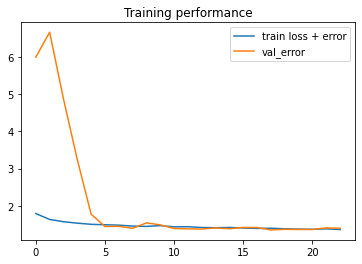

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

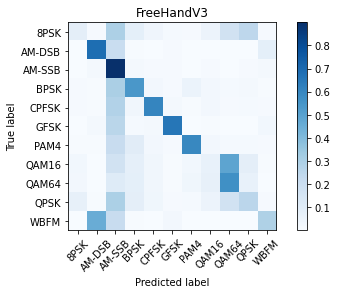

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08655274888558692


Overall Accuracy:  0.09685767097966728


Overall Accuracy:  0.09720749381406858


Overall Accuracy:  0.11454673225579762


Overall Accuracy:  0.15065028901734104


Overall Accuracy:  0.22090941639813821


Overall Accuracy:  0.3109996417054819


Overall Accuracy:  0.3960755813953488


Overall Accuracy:  0.5079872204472844


Overall Accuracy:  0.6240115025161754


Overall Accuracy:  0.6612200435729847


Overall Accuracy:  0.6985214569058781


Overall Accuracy:  0.7130929791271348


Overall Accuracy:  0.7111940298507463


Overall Accuracy:  0.7114553314121037


Overall Accuracy:  0.7101713452424353


Overall Accuracy:  0.6993706034801925


Overall Accuracy:  0.6807070327190673


Overall Accuracy:  0.6985998526160648


Overall Accuracy:  0.6709677419354839


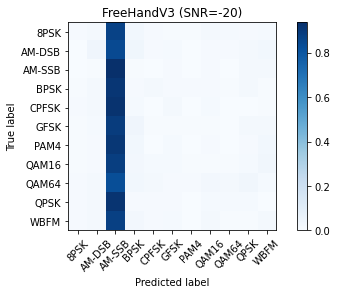

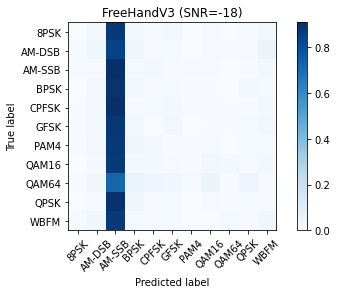

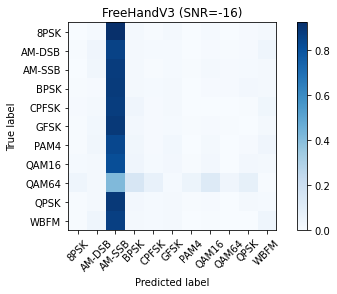

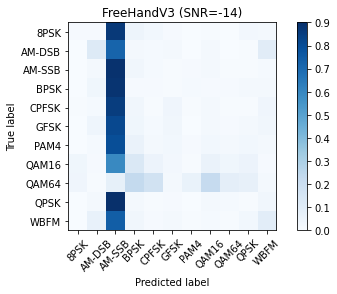

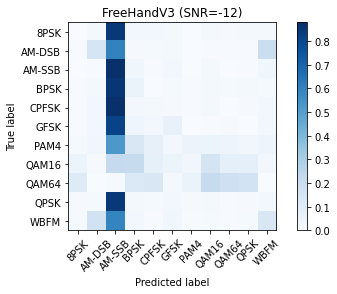

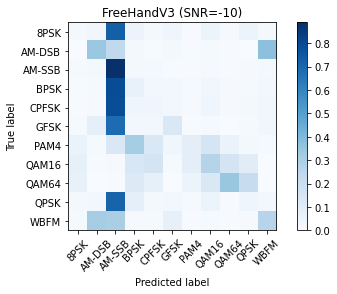

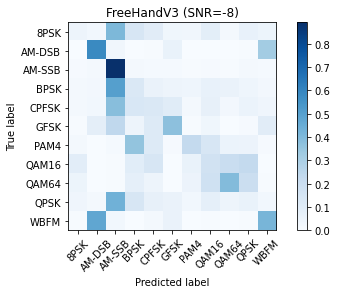

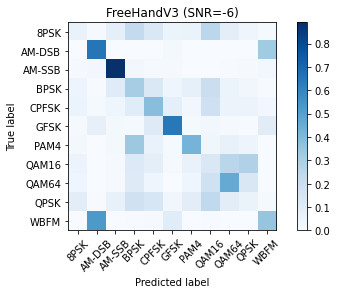

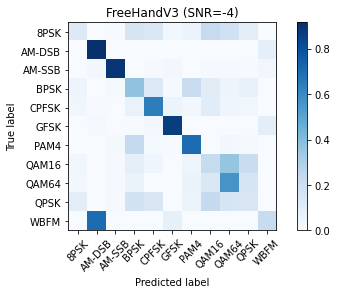

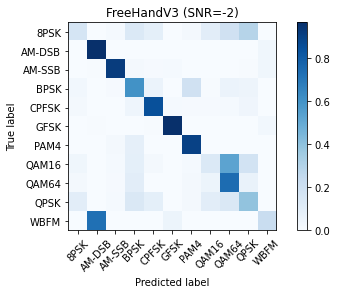

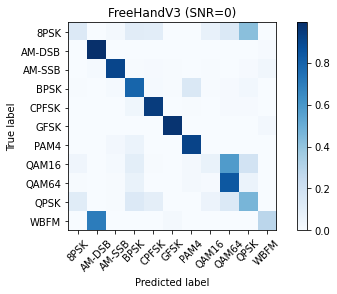

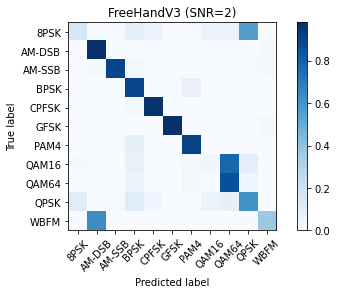

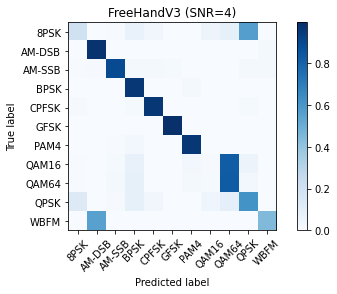

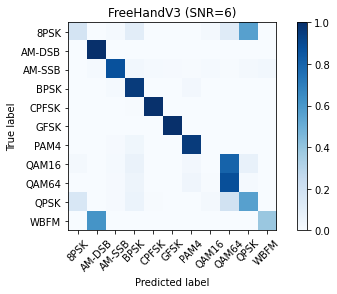

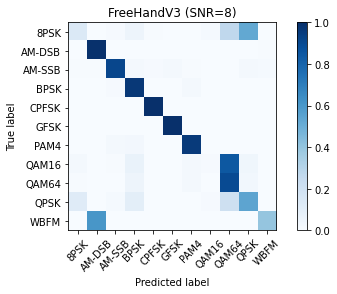

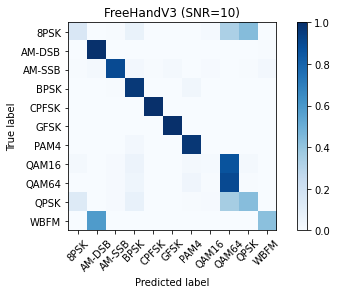

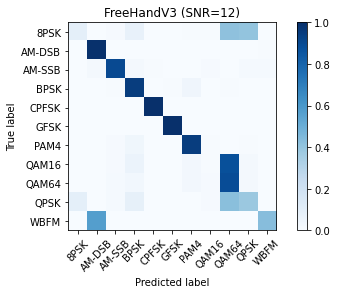

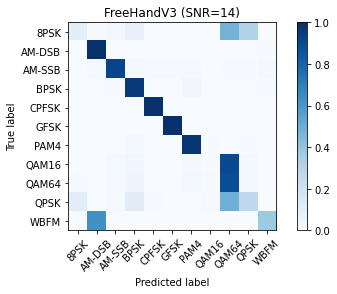

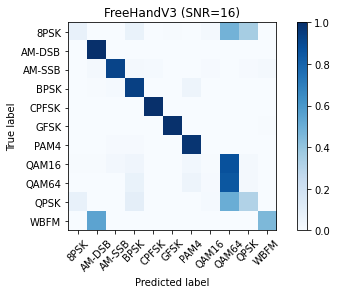

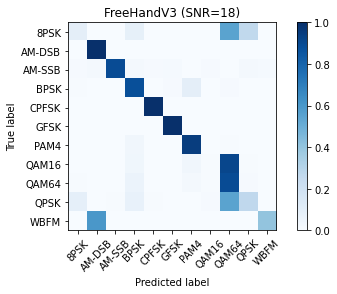

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,11,15,22,31,39,50,62,66,69,71,71,71,71,69,68,69,67


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

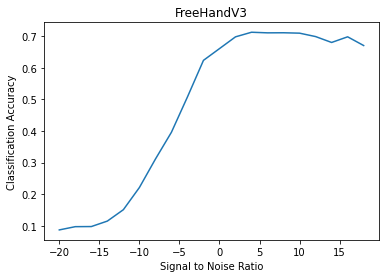

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)